In [1]:
%matplotlib inline
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Set up

Our first step is to instantiate some of the objects we will need to clean and featurize the data

In [2]:
import units
import icu_data_defs
import mimic
import logger
import pandas as pd
import utils

In [3]:
#random state used for random things
random_state=42

#Create a unit registry
ureg = units.MedicalUreg()

#We will need a data dictionary for some of the cleaning steps
data_dict = icu_data_defs.data_dictionary('config/data_definitions.xlsx')

Now we will define the features we wish to use in multivariate regression

The **labels**, in this case, are going to be a random lactate randomly sampled from the hospital admissions. There is a small gotcha in certain admissions where the VERY FIRST observation timewise is a lactate measurement. Clinically, this is somewhat bizarre. Practically, it means that these "first lactates" are ignored and not considered in sampling. If an admission has only one lactate, and that is the first lactate, then that admission is excluded.

In [4]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
import features
import transformers

from constants import ALL,column_names,variable_type,SEG_ID

#will ensure that there is at least 1 lactate before the sampled lactate
class keep_one_before_sample(features.preserve_datetime_sample):
    
    def transform(self, df, **transform_params):
        df = df.groupby(level=column_names.ID).apply(lambda grp: grp.iloc[1:]).reset_index(0,drop=True)
        return super(keep_one_before_sample,self).transform(df)
    

hdf5_fname = 'data/mimic_simple_all'
path = 'cleaned'
data_needs = [(data_dict.components.LACTATE,ALL)]


label_cleaners = Pipeline ([
        ('quantitative only',transformers.filter_var_type([variable_type.QUANTITATIVE])),
        ('combine_like_columns',transformers.combine_like_cols()),
        ('max_col',transformers.max_col_only()),
        ('two_or_more_lactate',transformers.more_than_n_component(1,data_dict.components.LACTATE)),
    ]) 

sampler = keep_one_before_sample(random_state)
sample_lactate = features.simple_featurizer(
    sampler,
    transformers.do_nothing(),
    [{column_names.COMPONENT : data_dict.components.LACTATE}],
    sampler.name + '_' + data_dict.components.LACTATE
)

label_pipeline = Pipeline ([
        ('data_loaader',features.data_loader(hdf5_fname,path,data_needs)),
        ('cleaners',label_cleaners),
        ('sampler',sample_lactate)
    ])

In [5]:
#bogus ids and make labels:
train_ids = mimic.get_all_hadm_ids()[:1000]
test_ids = mimic.get_all_hadm_ids()[1000:1100]
labels = label_pipeline.fit_transform(X=train_ids)
labels

(2017-06-26 16:50:43) Make DF for 1 components...
lactate
(2017-06-26 16:50:43)>> LACTATE: 1/1
(2017-06-26 16:50:43)>>>> Opening...
(2017-06-26 16:50:45)<<<< DONE (2.0s)
(2017-06-26 16:50:45)>>>> Filter & sort - (177451, 63)
(2017-06-26 16:50:45)<<<< DONE (0.0s)
(2017-06-26 16:50:45)>>>> Convert to dask - (2960, 63)
(2017-06-26 16:50:45)<<<< DONE (0.0s)
(2017-06-26 16:50:45)>>>> Join
(2017-06-26 16:50:45)<<<< DONE (0.0s)
(2017-06-26 16:50:45)<< DONE (2.0s)
(2017-06-26 16:50:45)>> Dask DF back to pandas
(2017-06-26 16:50:45)<< DONE (0.0s)
(2017-06-26 16:50:45) DONE (2.0s)
(2017-06-26 16:50:45) FIT Combine like columns (2960, 63)
(2017-06-26 16:50:45)>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-06-26 16:50:45)<< DONE (0.0s)
(2017-06-26 16:50:45)>> ('lactate', 'unknown', 'nom', 'no_units')
(2017-06-26 16:50:45)<< DONE (0.0s)
(2017-06-26 16:50:45)>> ('lactate', 'unknown', 'qn', 'no_units')
(2017-06-26 16:50:45)<< DONE (0.0s)
(2017-06-26 16:50:45) DONE (0.0s)
(2017-06-26 16:50:45) TRANSFOR

lactate_known_qn_mmol/L_all_SAMPLE
id     datetime                                               
100009 2162-05-17 17:14:00                                 1.5
100095 2108-10-01 06:53:00                                 1.1
100262 2142-04-29 18:46:00                                 3.8
100765 2126-03-12 03:57:00                                 1.3
101148 2197-12-17 02:50:00                                 2.0
101274 2170-03-28 18:12:00                                 1.3
101757 2133-01-03 19:28:00                                 1.1
102095 2114-11-27 22:28:00                                 2.5
102365 2137-10-27 01:28:00                                 0.6
102633 2177-03-24 08:56:00                                 3.0
103002 2143-02-16 15:13:00                                 1.5
103074 2125-10-21 20:17:00                                 0.7
103194 2154-08-23 22:21:00                                 1.8
103631 2158-06-29 06:14:00                                 1.0
104958 2200-03-11 03:11:00                                 4.6
105399 2113-07-28 05:23:00                                 1.3
105452 2155-05-11 07:41:00                                 4.8
105501 2172-07-08 08:44:00                                15.6
105588 2148-05-07 14:59:00                                 3.4
105694 2157-05-06 01:13:00                                 0.8
105764 2134-03-01 12:23:00                                 1.0
106296 2170-11-05 21:16:00                                 0.9
106767 2148-03-16 11:54:00                                 2.4
106909 2176-02-07 21:02:00                                 1.2
107064 2175-05-30 12:52:00                                 3.4
107660 2188-04-11 04:13:00                                 0.8
107880 2106-06-19 04:22:00                                 1.6
107882 2127-04-07 13:08:00                                 6.3
108015 2126-01-02 19:28:00                                 2.7
108329 2174-01-10 01:10:00                                11.9
...                                                        ...
190539 2186-11-22 03:10:00                                 1.5
190691 2144-05-13 15:19:00                                 2.5
190707 2119-12-25 01:11:00                                 2.8
190712 2137-07-19 14:39:00                                 4.8
191096 2131-11-18 10:17:00                                 1.6
191151 2139-03-20 09:52:00                                 1.0
191517 2157-03-07 20:28:00                                 2.6
191682 2201-04-08 05:50:00                                 6.0
191817 2165-05-08 17:17:00                                 1.4
192097 2190-03-01 18:38:00                                 1.1
192123 2142-04-25 01:15:00                                 1.1
192224 2164-06-13 12:47:00                                 2.6
194013 2169-07-05 13:24:00                                 2.1
194111 2198-08-03 04:38:00                                 1.3
194340 2129-09-07 08:18:00                                 4.4
195160 2171-03-04 15:33:00                                 1.0
195290 2138-02-14 03:33:00                                 1.5
195392 2149-11-29 20:40:00                                 5.1
195962 2180-12-11 17:48:00                                 1.2
196159 2163-01-08 00:29:00                                 4.7
196271 2141-12-20 09:13:00                                 5.0
197430 2130-06-01 15:00:00                                 3.2
197569 2133-03-02 03:03:00                                 1.8
198161 2144-05-08 03:07:00                                 2.3
198608 2176-05-28 20:29:00                                 2.5
199004 2189-06-12 23:06:00                                 1.3
199280 2121-01-04 00:46:00                                 1.5
199286 2159-07-27 15:21:00                                 1.2
199488 2107-09-08 18:11:00                                 1.7
199634 2174-05-18 01:01:00                                 0.6

[328 rows x 1 columns]

Lets start with just some basic **lactate** features

Now, we need to find some way to identify all of the discrete data needs for every feature in our list, and then create a featurizing pipeline for each of those things.

Since we cannot hold our entire data set in memory, we need to do this using the following steps:

1. **Data Loader** - will open the relevent transformed/cleaned dataframes for a given feature group with shared (currently IDENTICAL) data needs. This will both load AND filter data to relevent ids...there is no need to "fit" an ID filter because this will change from run to run or fold-to-fold
2. **Cleaning pipeline** - For each loaded data set, we will fit a series of data-dependent cleaning steps such that, for each train-test combination, each cleaning step can be FIT to the train data and then applied to the test data
3. **Segmenter** - This will take the cleaned data set and, using whatever behavior is encoded within the segmenter, it will assign a "segment" to each datetime within a give timeseries. There may be multiple segments per timeseries, and there may be some datetimes that ARE NOT part of a segment (encoded by segment index = -1 'NO SEGMENT')
4. **Featurizer** - this is either a featurizer object, or a pdFeatureUnion bundle that will join a bundle of featurizer results. Importantly, the _data loader_ should load all data needed by the featurizer.

The resulting pipline will then be unioned with other pipelines into a pdFeatureUnion pipeline. The final steps to the overall pipeline will be:
1. **Feature processing pipeline** - In most cases this will just be dropping all-NaN features, and do a standardized scaling. It could potentially include feature selection/creation.
2. ** A Model ** - so that we can finish the entire pipeline and run cross validation!

#### Data Loading and segmenting

initially will start with a segmenter that segments by n hours before a series of "end datetimes" which, in this case, will be the datetime of the sampled lactate

#### Cleaning pipeline
Now, for this series of machine learning models, we are going to use a simplified/cleaned version of our dataset. Specifically, we are going to combine all columns with the same component and unit into a single column (that is the "combine line colummns" cleaning step below).

In [6]:
from features import load_and_segment,data_loader
from segmenting import n_hrs_before

hdf5_fname = 'data/mimic_simple_all'
path = 'cleaned'
component = data_dict.components.HEART_RATE
data_needs = [(component,ALL)]
segmenter = n_hrs_before(n_hrs=ALL)

loader = features.load_and_segment(hdf5_fname,path,data_needs,segmenter)

In [111]:
y = labels
ids = y.index.get_level_values(column_names.ID).unique().tolist()
df_loaded = data_loader(hdf5_fname,path,data_needs).fit_transform(ids)
df_loaded.head()

(2017-06-26 18:07:21) Make DF for 1 components...
heart rate
(2017-06-26 18:07:21)>> HEART RATE: 1/1
(2017-06-26 18:07:21)>>>> Opening...
(2017-06-26 18:07:21)<<<< DONE (0.0s)
(2017-06-26 18:07:21)>>>> Filter & sort - (7922986, 6)
(2017-06-26 18:07:22)<<<< DONE (1.0s)
(2017-06-26 18:07:22)>>>> Convert to dask - (70798, 6)
(2017-06-26 18:07:22)<<<< DONE (0.0s)
(2017-06-26 18:07:22)>>>> Join
(2017-06-26 18:07:22)<<<< DONE (0.0s)
(2017-06-26 18:07:22)<< DONE (1.0s)
(2017-06-26 18:07:22)>> Dask DF back to pandas
(2017-06-26 18:07:22)<< DONE (0.0s)
(2017-06-26 18:07:22) DONE (1.0s)


component                  heart rate                                        
status                          known                       unknown          
variable_type                      qn                            qn          
units                       beats/min                      no_units          
description                  211(BPM) 211(bpm) 220045(bpm)     1332 1341 1725
id     datetime                                                              
100009 2162-05-17 18:23:00        NaN      NaN        80.0      NaN  NaN  NaN
       2162-05-17 18:25:00        NaN      NaN        80.0      NaN  NaN  NaN
       2162-05-17 18:30:00        NaN      NaN        80.0      NaN  NaN  NaN
       2162-05-17 18:45:00        NaN      NaN        80.0      NaN  NaN  NaN
       2162-05-17 19:00:00        NaN      NaN        80.0      NaN  NaN  NaN

In [1]:
import segmenting
import constants
reload(segmenting)
segmenter = segmenting.periodic(n_hrs=48)
df_segmented = segmenter.fit_transform(X=df_loaded, y=y)

NameError: name 'df_loaded' is not defined

In [62]:
df_loaded = loader.fit_transform(labels)
df_loaded.head()

(2017-06-22 10:31:32) Make DF for 1 components...
heart rate
(2017-06-22 10:31:32)>> HEART RATE: 1/1
(2017-06-22 10:31:32)>>>> Opening...
(2017-06-22 10:31:33)<<<< DONE (1.0s)
(2017-06-22 10:31:33)>>>> Join (70798, 6) to None
(2017-06-22 10:31:33)<<<< DONE (0.0s)
(2017-06-22 10:31:33)<< DONE (1.0s)
(2017-06-22 10:31:33) DONE (1.0s)
(2017-06-22 10:31:33) Segment df (70798, 6)
(2017-06-22 10:31:33)>> Get Segments
(2017-06-22 10:31:33)<< DONE (0.0s)
(2017-06-22 10:31:33)>> Apply Segments
(2017-06-22 10:31:34)<< DONE (1.0s)
(2017-06-22 10:31:34) DONE (1.0s)


component                         heart rate                                \
status                                 known                       unknown   
variable_type                             qn                            qn   
units                              beats/min                      no_units   
description                         211(BPM) 211(bpm) 220045(bpm)     1332   
id     datetime            seg_id                                            
100009 2162-05-17 18:23:00 -1            NaN      NaN        80.0      NaN   
       2162-05-17 18:25:00 -1            NaN      NaN        80.0      NaN   
       2162-05-17 18:30:00 -1            NaN      NaN        80.0      NaN   
       2162-05-17 18:45:00 -1            NaN      NaN        80.0      NaN   
       2162-05-17 19:00:00 -1            NaN      NaN        80.0      NaN   

component                                    
status                                       
variable_type                                
units                                        
description                       1341 1725  
id     datetime            seg_id            
100009 2162-05-17 18:23:00 -1      NaN  NaN  
       2162-05-17 18:25:00 -1      NaN  NaN  
       2162-05-17 18:30:00 -1      NaN  NaN  
       2162-05-17 18:45:00 -1      NaN  NaN  
       2162-05-17 19:00:00 -1      NaN  NaN

In [74]:
print df_loaded.index.get_level_values('id').unique().size
df_loaded[df_loaded.index.get_level_values('seg_id') != -1].index.get_level_values('id').unique().size

318


233

In [63]:
from transformers import remove_small_columns,record_threshold,combine_like_cols
def cleaner_pipeline():
    return Pipeline([
            ('drop_small_columns',remove_small_columns(threshold=50)),
            ('drop_low_id_count',record_threshold(threshold=5)),   
            ('combine_like_columns',combine_like_cols())
        ])

cleaners = cleaner_pipeline()

df_cleaned = cleaners.fit_transform(X=df_loaded,y=labels)
df_cleaned

(2017-06-22 10:31:36) Drop Small columns, threshold = 50 | (70798, 6)
(2017-06-22 10:31:36) DONE (0.0s)
318
318
318
(2017-06-22 10:31:36) FIT Combine like columns (70798, 2)
(2017-06-22 10:31:36)>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-06-22 10:31:36)<< DONE (0.0s)
(2017-06-22 10:31:36) DONE (0.0s)
(2017-06-22 10:31:36) TRANSFORM Combine like columns (70798, 2)
(2017-06-22 10:31:36)>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-06-22 10:31:38)<< DONE (2.0s)
(2017-06-22 10:31:38) DONE (2.0s)


component                         heart rate
status                                 known
variable_type                             qn
units                              beats/min
description                              all
id     datetime            seg_id           
100009 2162-05-17 18:23:00 -1           80.0
       2162-05-17 18:25:00 -1           80.0
       2162-05-17 18:30:00 -1           80.0
       2162-05-17 18:45:00 -1           80.0
       2162-05-17 19:00:00 -1           80.0
       2162-05-17 19:15:00 -1           80.0
       2162-05-17 19:30:00 -1           80.0
       2162-05-17 19:45:00 -1           88.0
       2162-05-17 20:00:00 -1           92.0
       2162-05-17 21:00:00 -1           80.0
       2162-05-17 22:00:00 -1           80.0
       2162-05-17 23:00:00 -1           80.0
       2162-05-18 00:00:00 -1           80.0
       2162-05-18 01:00:00 -1           79.0
       2162-05-18 02:00:00 -1           79.0
       2162-05-18 03:00:00 -1           80.0
       2162-05-18 04:00:00 -1           80.0
       2162-05-18 05:00:00 -1           72.0
       2162-05-18 06:00:00 -1           87.0
       2162-05-18 07:00:00 -1           70.0
       2162-05-18 08:00:00 -1           70.0
       2162-05-18 09:00:00 -1           70.0
       2162-05-18 10:00:00 -1           58.0
       2162-05-18 11:00:00 -1           55.0
       2162-05-18 11:30:00 -1           56.0
       2162-05-18 11:45:00 -1           52.0
       2162-05-18 12:00:00 -1           54.0
       2162-05-18 12:15:00 -1           49.0
       2162-05-18 12:30:00 -1           59.0
       2162-05-18 12:45:00 -1           59.0
...                                      ...
199488 2107-09-22 12:00:00 -1           88.0
       2107-09-22 13:00:00 -1           77.0
       2107-09-22 14:00:00 -1           89.0
       2107-09-22 15:00:00 -1           89.0
       2107-09-22 16:00:00 -1           99.0
       2107-09-22 17:00:00 -1           91.0
       2107-09-22 18:00:00 -1           99.0
       2107-09-22 19:30:00 -1           88.0
       2107-09-22 20:30:00 -1           86.0
       2107-09-22 21:00:00 -1           89.0
       2107-09-22 22:00:00 -1           87.0
       2107-09-22 23:00:00 -1           90.0
       2107-09-23 00:00:00 -1           91.0
       2107-09-23 01:00:00 -1           98.0
       2107-09-23 02:00:00 -1           99.0
       2107-09-23 03:00:00 -1           93.0
       2107-09-23 04:00:00 -1           87.0
       2107-09-23 05:00:00 -1           92.0
       2107-09-23 06:00:00 -1           97.0
       2107-09-23 07:00:00 -1           89.0
       2107-09-23 08:00:00 -1          108.0
       2107-09-23 09:00:00 -1          105.0
       2107-09-23 10:00:00 -1           84.0
       2107-09-23 11:00:00 -1           81.0
       2107-09-23 12:00:00 -1           77.0
       2107-09-23 13:00:00 -1           91.0
       2107-09-23 14:00:00 -1           96.0
       2107-09-23 15:00:00 -1           96.0
       2107-09-23 16:00:00 -1          108.0
       2107-09-23 17:00:00 -1           96.0

[70798 rows x 1 columns]

In [64]:
#mean, std, and last of all quantitative values
aggregator = features.segment_mean()
mean_component = features.simple_featurizer(
                    aggregator, #aggregator
                    transformers.fill_mean(), #how to fill empty features
                    [{
                        column_names.COMPONENT : component,
                        column_names.VAR_TYPE : variable_type.QUANTITATIVE
                    }], #what do we apply this to?
                    aggregator.name + '_' + component
                )

aggregator = features.segment_std()
std_component = features.simple_featurizer(
                    aggregator, #aggregator
                    transformers.fill_mean(), #how to fill empty features
                    [{
                        column_names.COMPONENT : component,
                        column_names.VAR_TYPE : variable_type.QUANTITATIVE
                    }], #what do we apply this to?
                    aggregator.name + '_' + component
                )

aggregator = features.segment_last()
last_component = features.simple_featurizer(
                    aggregator, #aggregator
                    transformers.fill_mean(), #how to fill empty features
                    [{
                        column_names.COMPONENT : component,
                        column_names.VAR_TYPE : variable_type.QUANTITATIVE
                    }], #what do we apply this to?
                    aggregator.name + '_' + component
                )

#count of everything, including nominal
aggregator = features.segment_count()
count_component = features.simple_featurizer(
                    aggregator, #aggregator
                    transformers.fill_mean(), #how to fill empty features
                    [{column_names.COMPONENT : component}], #what do we apply this to?
                    aggregator.name + '_' + component
                )

featurizer = features.pdFeatureUnion([
    (mean_component.name,mean_component),
    (std_component.name,std_component),
    (last_component.name,last_component),
    (count_component.name,count_component)
])

featurizer.fit_transform(X=df_cleaned,y=labels)

(2017-06-22 10:31:40) FIT features...
(2017-06-22 10:31:40)>> MEAN_heart rate
318
318
318
233
(2017-06-22 10:31:41)<< DONE (1.0s)
(2017-06-22 10:31:41)>> STD_heart rate
318
318
318
233
(2017-06-22 10:31:41)<< DONE (0.0s)
(2017-06-22 10:31:41)>> LAST_heart rate
318
318
318
233
(2017-06-22 10:31:41)<< DONE (0.0s)
(2017-06-22 10:31:41)>> COUNT_heart rate
318
318
318
233
(2017-06-22 10:31:41)<< DONE (0.0s)
(2017-06-22 10:31:41) DONE (1.0s)
(2017-06-22 10:31:41) Start Feature Union on DF (70798, 1)
(2017-06-22 10:31:41)>> MEAN_heart rate
318
318
318
233
(2017-06-22 10:31:41)<< DONE (0.0s)
(2017-06-22 10:31:41)>> STD_heart rate
318
318
318
233
(2017-06-22 10:31:41)<< DONE (0.0s)
(2017-06-22 10:31:41)>> LAST_heart rate
318
318
318
233
(2017-06-22 10:31:41)<< DONE (0.0s)
(2017-06-22 10:31:41)>> COUNT_heart rate
318
318
318
233
(2017-06-22 10:31:41)<< DONE (0.0s)
(2017-06-22 10:31:41) DONE (0.0s)


heart rate_known_qn_beats/min_all_MEAN  \
id     seg_id                                           
100095 0                                    86.918367   
100262 0                                   138.809524   
100765 0                                   103.750000   
101274 0                                    94.785714   
101757 0                                   100.700000   
102095 0                                   133.000000   
102365 0                                    85.209205   
102633 0                                   108.300000   
103002 0                                    71.666667   
103074 0                                    86.118519   
103194 0                                   102.444444   
103631 0                                    90.226415   
104958 0                                    92.000000   
105399 0                                    90.704918   
105501 0                                   101.937500   
105694 0                                    80.225989   
105764 0                                    75.000000   
106296 0                                   133.222222   
106909 0                                    81.838843   
107660 0                                    88.080000   
107880 0                                    89.000000   
107882 0                                    90.964286   
108015 0                                   100.500000   
108329 0                                   126.333333   
108462 0                                    89.600000   
108923 0                                    86.000000   
109185 0                                    91.157143   
109235 0                                    98.416667   
109451 0                                    67.550000   
109718 0                                    85.200000   
...                                               ...   
185910 0                                   106.234043   
186516 0                                    78.446154   
188038 0                                    69.416667   
188256 0                                   105.617857   
188576 0                                    83.402609   
188869 0                                    67.038462   
189081 0                                    74.555556   
189243 0                                   100.285714   
189332 0                                    87.578947   
190159 0                                   109.878049   
190462 0                                   107.333333   
190539 0                                    74.400000   
190707 0                                    82.315789   
191096 0                                    71.850000   
191517 0                                    83.214286   
191817 0                                    86.900000   
192123 0                                   125.060606   
194013 0                                    67.654639   
194111 0                                    41.090909   
194340 0                                   100.596774   
195160 0                                    78.971429   
195290 0                                    65.333333   
195962 0                                   105.659420   
197569 0                                    94.491228   
198161 0                                    91.477889   
198608 0                                    92.989899   
199004 0                                    74.000000   
199280 0                                    67.274510   
199286 0                                   107.637681   
199488 0                                   113.222222   

               heart rate_known_qn_beats/min_all_STD  \
id     seg_id                                          
100095 0                                   13.800249   
100262 0                                   10.766339   
100765 0                                    3.201562   
101274 0                                    5.294098   
101757 0                                    8.932463   
102095 0                       

#### Put it all together

In [65]:
feature_pipeline = Pipeline ([
        ('data_loader',loader),
        ('cleaners',cleaner_pipeline()),
        ('featurizer',featurizer)
    ])

df_features = feature_pipeline.fit_transform(labels)

(2017-06-22 10:32:03) Make DF for 1 components...
heart rate
(2017-06-22 10:32:03)>> HEART RATE: 1/1
(2017-06-22 10:32:03)>>>> Opening...
(2017-06-22 10:32:04)<<<< DONE (1.0s)
(2017-06-22 10:32:04)>>>> Join (70798, 6) to None
(2017-06-22 10:32:04)<<<< DONE (0.0s)
(2017-06-22 10:32:04)<< DONE (1.0s)
(2017-06-22 10:32:04) DONE (1.0s)
(2017-06-22 10:32:04) Segment df (70798, 6)
(2017-06-22 10:32:04)>> Get Segments
(2017-06-22 10:32:04)<< DONE (0.0s)
(2017-06-22 10:32:04)>> Apply Segments
(2017-06-22 10:32:04)<< DONE (0.0s)
(2017-06-22 10:32:04) DONE (0.0s)
(2017-06-22 10:32:04) Drop Small columns, threshold = 50 | (70798, 6)
(2017-06-22 10:32:05) DONE (1.0s)
318
318
318
(2017-06-22 10:32:05) FIT Combine like columns (70798, 2)
(2017-06-22 10:32:05)>> ('heart rate', 'known', 'qn', 'beats/min')
(2017-06-22 10:32:05)<< DONE (0.0s)
(2017-06-22 10:32:05) DONE (0.0s)
(2017-06-22 10:32:05) TRANSFORM Combine like columns (70798, 2)
(2017-06-22 10:32:05)>> ('heart rate', 'known', 'qn', 'beats/min'

In [66]:
df_features

heart rate_known_qn_beats/min_all_MEAN  \
id     seg_id                                           
100095 0                                    86.918367   
100262 0                                   138.809524   
100765 0                                   103.750000   
101274 0                                    94.785714   
101757 0                                   100.700000   
102095 0                                   133.000000   
102365 0                                    85.209205   
102633 0                                   108.300000   
103002 0                                    71.666667   
103074 0                                    86.118519   
103194 0                                   102.444444   
103631 0                                    90.226415   
104958 0                                    92.000000   
105399 0                                    90.704918   
105501 0                                   101.937500   
105694 0                                    80.225989   
105764 0                                    75.000000   
106296 0                                   133.222222   
106909 0                                    81.838843   
107660 0                                    88.080000   
107880 0                                    89.000000   
107882 0                                    90.964286   
108015 0                                   100.500000   
108329 0                                   126.333333   
108462 0                                    89.600000   
108923 0                                    86.000000   
109185 0                                    91.157143   
109235 0                                    98.416667   
109451 0                                    67.550000   
109718 0                                    85.200000   
...                                               ...   
185910 0                                   106.234043   
186516 0                                    78.446154   
188038 0                                    69.416667   
188256 0                                   105.617857   
188576 0                                    83.402609   
188869 0                                    67.038462   
189081 0                                    74.555556   
189243 0                                   100.285714   
189332 0                                    87.578947   
190159 0                                   109.878049   
190462 0                                   107.333333   
190539 0                                    74.400000   
190707 0                                    82.315789   
191096 0                                    71.850000   
191517 0                                    83.214286   
191817 0                                    86.900000   
192123 0                                   125.060606   
194013 0                                    67.654639   
194111 0                                    41.090909   
194340 0                                   100.596774   
195160 0                                    78.971429   
195290 0                                    65.333333   
195962 0                                   105.659420   
197569 0                                    94.491228   
198161 0                                    91.477889   
198608 0                                    92.989899   
199004 0                                    74.000000   
199280 0                                    67.274510   
199286 0                                   107.637681   
199488 0                                   113.222222   

               heart rate_known_qn_beats/min_all_STD  \
id     seg_id                                          
100095 0                                   13.800249   
100262 0                                   10.766339   
100765 0                                    3.201562   
101274 0                                    5.294098   
101757 0                                    8.932463   
102095 0                       

In [68]:
feature_pipeline.get_params()['featurizer'].get_params()['STD_heart rate'].get_params()['feature_fillna'].means

component   status  variable_type  units      description
heart rate  known   qn             beats/min  all            9.396389
dtype: float64

In [69]:
test_labels = label_pipeline.transform(X=test_ids)
test_features = feature_pipeline.transform(test_labels)

(2017-06-22 10:32:30) Make DF for 1 components...
lactate
(2017-06-22 10:32:30)>> LACTATE: 1/1
(2017-06-22 10:32:30)>>>> Opening...
(2017-06-22 10:32:31)<<<< DONE (1.0s)
(2017-06-22 10:32:31)>>>> Join (187, 63) to None
(2017-06-22 10:32:31)<<<< DONE (0.0s)
(2017-06-22 10:32:31)<< DONE (1.0s)
(2017-06-22 10:32:31) DONE (1.0s)
51
51
51
(2017-06-22 10:32:31) TRANSFORM Combine like columns (187, 63)
(2017-06-22 10:32:31)>> ('lactate', 'unknown', 'qn', 'no_units')
(2017-06-22 10:32:31)<< DONE (0.0s)
(2017-06-22 10:32:31)>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-06-22 10:32:31)<< DONE (0.0s)
(2017-06-22 10:32:31) DONE (0.0s)
30
30
30
30
(2017-06-22 10:32:31) Make DF for 1 components...
heart rate
(2017-06-22 10:32:31)>> HEART RATE: 1/1
(2017-06-22 10:32:31)>>>> Opening...
(2017-06-22 10:32:32)<<<< DONE (1.0s)
(2017-06-22 10:32:32)>>>> Join (7191, 6) to None
(2017-06-22 10:32:32)<<<< DONE (0.0s)
(2017-06-22 10:32:32)<< DONE (1.0s)
(2017-06-22 10:32:32) DONE (1.0s)
(2017-06-22 10:32:32) Se

In [70]:
print df_features.shape, labels.shape
print test_features.shape, test_labels.shape

(233, 4) (328, 1)
(25, 4) (30, 1)


Now, we will use this framework to define a more efficient helper method

In [48]:
from sklearn.pipeline import FeatureUnion
def build_features(component,var_type,is_intervention):
    
    count_aggregator = features.segment_count()
    tag = count_aggregator.name + '_' + component
    count_featurizer = features.simple_featurizer(
                count_aggregator, #aggregator
                transformers.fill_zero(), #how to fill empty features
                [{column_names.COMPONENT : component}], #what do we apply this to?
                tag
            )
    
    feature_list = [count_featurizer]
    
    #If this is nominal data, we are done.
    if var_type == variable_type.NOMINAL:
        return feature_list
    
    #Fill interventions with 0, observations with mean
    if is_intervention: 
        fill_method=transformers.fill_zero
    else: 
        fill_method=transformers.fill_mean
    
    #we will use mean, std, and last to describe each segment
    aggregators = [
        features.segment_mean,
        features.segment_std,
        features.segment_last
    ]
    
    #this will only be applied to this component and variable type
    slice_dict = {
        column_names.COMPONENT : component,
        column_names.VAR_TYPE : variable_type
    }
    
    #create featurizers
    for aggregator in aggregators:
        agg_instace = aggregator()
        tag = agg_instace.name + '_' + component
        featurizer = features.simple_featurizer(
            agg_instace, #aggregator
            fill_method(), #how to fill empty features
            [slice_dict], #what do we apply this to?
            tag
        )
        feature_list.append(featurizer)

    return feature_list

In [49]:
component = data_dict.components.HEART_RATE
featurizers = build_features(component,
                                var_type=variable_type.QUANTITATIVE,
                                is_intervention=False)
lactate_feature_union = FeatureUnion([(f.name,f) for f in featurizers])
lactate_feature_union.get_params()

{'COUNT_lactate': simple_featurizer(aggregator=None, fillna=None, name='COUNT_lactate',
          slice_dict_list=None),
 'COUNT_lactate__aggregator': None,
 'COUNT_lactate__feature_aggregator': segment_count(),
 'COUNT_lactate__feature_fillna': fill_zero(),
 'COUNT_lactate__fillna': None,
 'COUNT_lactate__flatten_columns': flatten_index(axis=1, suffix='COUNT'),
 'COUNT_lactate__flatten_columns__axis': 1,
 'COUNT_lactate__flatten_columns__suffix': 'COUNT',
 'COUNT_lactate__name': 'COUNT_lactate',
 'COUNT_lactate__preprocessor': multislice_filter(slice_dict_list=[{'component': 'lactate'}]),
 'COUNT_lactate__preprocessor__slice_dict_list': [{'component': 'lactate'}],
 'COUNT_lactate__slice_dict_list': None,
 'LAST_lactate': simple_featurizer(aggregator=None, fillna=None, name='LAST_lactate',
          slice_dict_list=None),
 'LAST_lactate__aggregator': None,
 'LAST_lactate__feature_aggregator': segment_last(),
 'LAST_lactate__feature_fillna': fill_mean(),
 'LAST_lactate__fillna': None,
 

Now, this should look slightly different for an intervention, lets say normal saline

In [50]:
component = data_dict.components.NORMAL_SALINE
featurizers = build_features(component,
                                var_type=variable_type.QUANTITATIVE,
                                is_intervention=True)
ns_feature_union = FeatureUnion([(f.name,f) for f in featurizers])
ns_feature_union.get_params()

{'COUNT_normal saline': simple_featurizer(aggregator=None, fillna=None, name='COUNT_normal saline',
          slice_dict_list=None),
 'COUNT_normal saline__aggregator': None,
 'COUNT_normal saline__feature_aggregator': segment_count(),
 'COUNT_normal saline__feature_fillna': fill_zero(),
 'COUNT_normal saline__fillna': None,
 'COUNT_normal saline__flatten_columns': flatten_index(axis=1, suffix='COUNT'),
 'COUNT_normal saline__flatten_columns__axis': 1,
 'COUNT_normal saline__flatten_columns__suffix': 'COUNT',
 'COUNT_normal saline__name': 'COUNT_normal saline',
 'COUNT_normal saline__preprocessor': multislice_filter(slice_dict_list=[{'component': 'normal saline'}]),
 'COUNT_normal saline__preprocessor__slice_dict_list': [{'component': 'normal saline'}],
 'COUNT_normal saline__slice_dict_list': None,
 'LAST_normal saline': simple_featurizer(aggregator=None, fillna=None, name='LAST_normal saline',
          slice_dict_list=None),
 'LAST_normal saline__aggregator': None,
 'LAST_normal sal

Sure enough, for interventions we see that na values will be filled with 0 instead of the population mean!

Finally, lets put this all together for our data dictionary and a list of data we want to use. 

In [51]:
from constants import clinical_source
def get_all_featurizers(components,data_dict):
    feature_list = []
    for component in components:
        clinical_src = data_dict.get_clinical_source(component)
        is_intervention = clinical_src == clinical_source.INTERVENTION
        variable_type = data_dict.get_variable_type(component)
        feature_list += build_features(component,
                                       variable_type,
                                       is_intervention=is_intervention)
    
    return feature_list

# vital signs
components = [data_dict.components.LACTATE,data_dict.components.RESPIRATORY_RATE]
featurizer_list = get_all_featurizers(components,data_dict)

Now, lets put this list of featurizers into a completed pipeline

In [52]:
#organize by data needs
data_needs_dict = {}
for featurizer in featurizer_list:
    data_needs = tuple(featurizer.get_data_needs())
    data_needs_dict[data_needs] = data_needs_dict.get(data_needs,[]) + [featurizer]
    
data_needs_dict

{(('lactate',
   'all'),): [simple_featurizer(aggregator=None, fillna=None, name='COUNT_lactate',
           slice_dict_list=None),
  simple_featurizer(aggregator=None, fillna=None, name='MEAN_lactate',
           slice_dict_list=None),
  simple_featurizer(aggregator=None, fillna=None, name='STD_lactate',
           slice_dict_list=None),
  simple_featurizer(aggregator=None, fillna=None, name='LAST_lactate',
           slice_dict_list=None)],
 (('respiratory rate',
   'all'),): [simple_featurizer(aggregator=None, fillna=None, name='COUNT_respiratory rate',
           slice_dict_list=None),
  simple_featurizer(aggregator=None, fillna=None, name='MEAN_respiratory rate',
           slice_dict_list=None),
  simple_featurizer(aggregator=None, fillna=None, name='STD_respiratory rate',
           slice_dict_list=None),
  simple_featurizer(aggregator=None, fillna=None, name='LAST_respiratory rate',
           slice_dict_list=None)]}

In [53]:
segmenter = n_hrs_before(n_hrs=ALL)

feature_tuples = []

for data_needs,featurizers in data_needs_dict.iteritems():
    loader = features.load_and_segment(hdf5_fname,path,data_needs,segmenter)
    featurizer_union = FeatureUnion([(f.name,f) for f in featurizers])
    
    feature_pipeline = Pipeline ([
        ('LOADER',loader),
        ('cleaners',cleaner_pipeline()),
        ('feature_union',featurizer_union)
    ])
    feature_tuples.append((str(data_needs),feature_pipeline))

all_features = FeatureUnion(feature_tuples)

In [57]:
train_lbl = label_pipeline.fit_transform(X=train_ids)

(2017-06-22 01:59:08) Make DF for 1 components...
lactate
(2017-06-22 01:59:08)>> LACTATE: 1/1
(2017-06-22 01:59:08)>>>> Opening...
(2017-06-22 01:59:09)<<<< DONE (1.0s)
(2017-06-22 01:59:09)>>>> Join (2960, 63) to None
(2017-06-22 01:59:09)<<<< DONE (0.0s)
(2017-06-22 01:59:09)<< DONE (1.0s)
(2017-06-22 01:59:09) DONE (1.0s)
482
482
482
(2017-06-22 01:59:09) FIT Combine like columns (2960, 63)
(2017-06-22 01:59:09)>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-06-22 01:59:09)<< DONE (0.0s)
(2017-06-22 01:59:09)>> ('lactate', 'unknown', 'nom', 'no_units')
(2017-06-22 01:59:09)<< DONE (0.0s)
(2017-06-22 01:59:09)>> ('lactate', 'unknown', 'qn', 'no_units')
(2017-06-22 01:59:09)<< DONE (0.0s)
(2017-06-22 01:59:09) DONE (0.0s)
(2017-06-22 01:59:09) TRANSFORM Combine like columns (2960, 63)
(2017-06-22 01:59:09)>> ('lactate', 'unknown', 'qn', 'no_units')
(2017-06-22 01:59:09)<< DONE (0.0s)
(2017-06-22 01:59:09)>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-06-22 01:59:09)<< DONE (0.0s)
(2017-

In [58]:
train_ft = all_features.fit_transform(train_lbl)

(2017-06-22 01:59:13) Make DF for 1 components...
respiratory rate
(2017-06-22 01:59:13)>> RESPIRATORY RATE: 1/1
(2017-06-22 01:59:13)>>>> Opening...
(2017-06-22 01:59:14)<<<< DONE (1.0s)
(2017-06-22 01:59:14)>>>> Join (69806, 6) to None
(2017-06-22 01:59:14)<<<< DONE (0.0s)
(2017-06-22 01:59:14)<< DONE (1.0s)
(2017-06-22 01:59:14) DONE (1.0s)
(2017-06-22 01:59:14) Segment df (69806, 6)
(2017-06-22 01:59:14)>> Get Segments
(2017-06-22 01:59:14)<< DONE (0.0s)
(2017-06-22 01:59:14)>> Apply Segments
(2017-06-22 01:59:15)<< DONE (1.0s)
(2017-06-22 01:59:15) DONE (1.0s)
(2017-06-22 01:59:15) Drop Small columns, threshold = 50 | (69806, 6)
(2017-06-22 01:59:15) DONE (0.0s)
318
318
318
(2017-06-22 01:59:15) FIT Combine like columns (69806, 2)
(2017-06-22 01:59:15)>> ('respiratory rate', 'known', 'qn', 'insp/min')
(2017-06-22 01:59:15)<< DONE (0.0s)
(2017-06-22 01:59:15) DONE (0.0s)
(2017-06-22 01:59:15) TRANSFORM Combine like columns (69806, 2)
(2017-06-22 01:59:15)>> ('respiratory rate', 'kn

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [23]:
test_lbl = label_pipeline.transform(X=test_ids)
test_ft = all_features.transform(test_lbl)

print train_ft.shape, train_lbl.shape
print test_ft.shape, test_lbl.shape

(2017-06-22 00:04:15) Make DF for 1 components...
lactate
(2017-06-22 00:04:15)>> LACTATE: 1/1
(2017-06-22 00:04:15)>>>> Opening...
(2017-06-22 00:04:15)<<<< DONE (0.0s)
(2017-06-22 00:04:15)>>>> Join (2960, 63) to None
(2017-06-22 00:04:15)<<<< DONE (0.0s)
(2017-06-22 00:04:15)<< DONE (0.0s)
(2017-06-22 00:04:15) DONE (0.0s)
482
482
482
(2017-06-22 00:04:15) FIT Combine like columns (2960, 63)
(2017-06-22 00:04:15)>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-06-22 00:04:16)<< DONE (1.0s)
(2017-06-22 00:04:16)>> ('lactate', 'unknown', 'nom', 'no_units')
(2017-06-22 00:04:16)<< DONE (0.0s)
(2017-06-22 00:04:16)>> ('lactate', 'unknown', 'qn', 'no_units')
(2017-06-22 00:04:16)<< DONE (0.0s)
(2017-06-22 00:04:16) DONE (1.0s)
(2017-06-22 00:04:16) TRANSFORM Combine like columns (2960, 63)
(2017-06-22 00:04:16)>> ('lactate', 'unknown', 'qn', 'no_units')
(2017-06-22 00:04:16)<< DONE (0.0s)
(2017-06-22 00:04:16)>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-06-22 00:04:16)<< DONE (0.0s)
(2017-

# Test-train split

In [5]:
`from sklearn.model_selection import train_test_split
import mimic

random_state = 42

all_ids = mimic.get_all_hadm_ids()

#these test IDs will never be touched again. They are sacred
train_ids,test_ids = train_test_split(all_ids,test_size=0.1,random_state=random_state)

print 'Train:', len(train_ids),'>', train_ids[:5],'...'
print 'Test:', len(test_ids),'>',test_ids[:5],'...'

# Small training set (20% train, 10% test)

small_ids,ignore = train_test_split(train_ids,test_size=(2.0/3.0),random_state=random_state)

train_ids_small,test_ids_small = train_test_split(small_ids,test_size=(1.0/3.0),random_state=random_state)

print 'Small train:', len(train_ids_small),'>',train_ids_small[:5],'...'
print 'Small test:', len(test_ids_small),'>',test_ids_small[:5],'...'

Small train: 11794 > [101710, 163819, 191145, 186834, 190681] ...
Small test: 5898 > [172993, 130996, 105594, 100458, 102476] ...


Lets get our labels now!

In [16]:
from sklearn.pipeline import Pipeline

In [ ]:
train = train_ids_small
test = test_ids_small

label extractor = lactate_label_extractor(data_dict.components.LACTATE,random_state=random_state)
label_pipeline = Pipeline([
        ('clean',cleaner_pipeline())
        ('label_extractor',extractor)
    ])

lbl_train = filter_and_transform(df_data,label_pipeline,ids=train,fit_pipeline=True)
lbl_test = filter_and_transform(df_data,label_pipeline,ids=test,fit_pipeline=False)

Now we need to make our **FEATURES**. The first step in this process is to define how we are going to **"segment"** the data. What that means is that we need to identify which chunks of each timeseries to use, and then we will create each entry/rows/instance by aggregating the timeseries data in each chunk. 

In this case, we will use once of our pre-made segmenters, the n-hrs before segmenter. This will get fit to the labels, and then determine a block of time n-hours before the label as the segment. Specifically we are going to use all time before

In [18]:
import segmenting
from constants import ALL

segmenter = segmenting.n_hrs_before(df_context,n_hrs=ALL)

In [5]:
#4. Which features do we want, and to which columns should those features be applied?
var_type_filter = transformers.filter_var_type([constants.variable_type.ORDINAL,constants.variable_type.QUANTITATIVE])
feature_tuples = [
    ('MEAN',
         features.segment_mean(),
         var_type_filter,
         transformers.fill_mean()),
    ('STD',
         features.segment_std(),
         var_type_filter,
         transformers.fill_mean()),
    ('COUNT',
         features.segment_count(),
         constants.ALL,
         transformers.fill_zero()),
    ('LAST',
         features.segment_last(),
         var_type_filter,
         transformers.fill_mean()),
    ('SUM',
         features.segment_sum(),
         transformers.summable_only(ureg,[data_dict.components.WEIGHT_BODY]),
         transformers.fill_mean())
]


valid_ids = labels.index.get_level_values(constants.column_names.ID).unique().tolist()
end_dt = labels.reset_index(constants.column_names.DATETIME,drop=False).iloc[:,0]

feature_pipeline = Pipeline([
        ('filter_ids',transformers.filter_ids()),
        ('segmenter',), #we are doing multivariate regression, so need to segment in this way for now
        ('featurizer',features.pdFeatureUnion(feature_tuples)),
        ('feature_cleaner',features.feature_cleaner())
    ])

featurizer = features.pdFeatureUnion(feature_tuples)

In [ ]:
import utils
df_all = utils.open_df('data/mimic_data','cleaned/all')

In [ ]:
logger.log('CLEANING',new_level=True)
df_cleaned = cleaners.fit_transform(df_all)
logger.end_log_level()

In [3]:
import pandas as pd
import utils
import icu_data_defs
import mimic
import transformers
import units
import logger
import constants
import segmenting
import features
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler

## Featurize

In [13]:
#small data set for now
train_ids = train_ids_small
test_ids = test_ids_small

train_ft,train_lbl = lin_reg_features_and_labels(train_ids,hdf5_fname,feature_components,label_components,cleaners,feature_tuples)
oh = lin_reg_features_and_labels(test_ids,hdf5_fname,feature_components,label_components,cleaners,feature_tuples)

(2017-06-07 21:18:55) Make DF for 11794 admission - [u'glasgow coma scale eye opening', u'glasgow coma scale motor', u'blood pressure systolic', u'oxygen saturation pulse oximetry', u'glasgow coma scale verbal', u'hemoglobin', u'lactate', u'blood pressure mean', u'vasopressin', u'weight body', u'normal saline', u'norepinephrine', u'temperature body', u'blood pressure diastolic', u'heart rate', u'output urine', u'lactated ringers', u'respiratory rate']
(2017-06-07 21:18:55)>> GLASGOW COMA SCALE EYE OPENING
(2017-06-07 21:18:55)>>>> Opening...


component     glasgow coma scale eye opening
status                                 known
variable_type                            ord
units                               no_units
description                              184
count                          190539.000000
mean                                3.277445
std                                 1.074103
min                                 1.000000
25%                                 3.000000
50%                                 4.000000
75%                                 4.000000
max                                 4.000000

(2017-06-07 21:18:55)<<<< DONE (0.0s)
(2017-06-07 21:18:55)>>>> Clean (190539, 1)
(2017-06-07 21:18:55)<<<< DONE (0.0s)
(2017-06-07 21:18:55)>>>> Nominal to OneHot
(2017-06-07 21:18:55)<<<< DONE (0.0s)
(2017-06-07 21:18:55)>>>> Drop Small columns, threshold = 5 | (190539, 1)
(2017-06-07 21:18:55)<<<< DONE (0.0s)
(2017-06-07 21:18:55)>>>> Drop OOB data | (190539, 1)
(2017-06-07 21:18:55)>>>>>> glasgow coma scale eye opening, no_units, 190539
(2017-06-07 21:18:57)<<<<<< DONE (2.0s)
(2017-06-07 21:18:57)<<<< DONE (2.0s)
(2017-06-07 21:18:57)>>>> Drop Small columns, threshold = 50 | (190539, 1)
(2017-06-07 21:18:57)<<<< DONE (0.0s)
(2017-06-07 21:18:57)>>>> Combine like columns (190539, 1)
(2017-06-07 21:18:57)>>>>>> (u'glasgow coma scale eye opening', 'known', u'ord', 'no_units')
(2017-06-07 21:18:57)<<<<<< DONE (0.0s)


component     glasgow coma scale eye opening
status                                 known
variable_type                            ord
units                               no_units
description                              all
count                          190539.000000
mean                                3.277445
std                                 1.074103
min                                 1.000000
25%                                 3.000000
50%                                 4.000000
75%                                 4.000000
max                                 4.000000

((190539, 1), (190539, 1), 0L, 0, '0.0% records')
(2017-06-07 21:18:57)<<<< DONE (0.0s)
(2017-06-07 21:18:57)>>>> Join (190539, 1) to None
(2017-06-07 21:18:57)<<<< DONE (0.0s)
(2017-06-07 21:18:57)<< DONE (2.0s)
(2017-06-07 21:18:57)>> GLASGOW COMA SCALE MOTOR
(2017-06-07 21:18:57)>>>> Opening...


component     glasgow coma scale motor
status                           known
variable_type                      ord
units                         no_units
description                        454
count                    189663.000000
mean                          5.218493
std                           1.468247
min                           1.000000
25%                           5.000000
50%                           6.000000
75%                           6.000000
max                           6.000000

(2017-06-07 21:18:57)<<<< DONE (0.0s)
(2017-06-07 21:18:57)>>>> Clean (189663, 1)
(2017-06-07 21:18:57)<<<< DONE (0.0s)
(2017-06-07 21:18:57)>>>> Nominal to OneHot
(2017-06-07 21:18:57)<<<< DONE (0.0s)
(2017-06-07 21:18:57)>>>> Drop Small columns, threshold = 5 | (189663, 1)
(2017-06-07 21:18:58)<<<< DONE (1.0s)
(2017-06-07 21:18:58)>>>> Drop OOB data | (189663, 1)
(2017-06-07 21:18:58)>>>>>> glasgow coma scale motor, no_units, 189663
(2017-06-07 21:19:00)<<<<<< DONE (2.0s)
(2017-06-07 21:19:00)<<<< DONE (2.0s)
(2017-06-07 21:19:00)>>>> Drop Small columns, threshold = 50 | (189663, 1)
(2017-06-07 21:19:00)<<<< DONE (0.0s)
(2017-06-07 21:19:00)>>>> Combine like columns (189663, 1)
(2017-06-07 21:19:00)>>>>>> (u'glasgow coma scale motor', 'known', u'ord', 'no_units')
(2017-06-07 21:19:00)<<<<<< DONE (0.0s)


component     glasgow coma scale motor
status                           known
variable_type                      ord
units                         no_units
description                        all
count                    189663.000000
mean                          5.218493
std                           1.468247
min                           1.000000
25%                           5.000000
50%                           6.000000
75%                           6.000000
max                           6.000000

((189663, 1), (189663, 1), 0L, 0, '0.0% records')
(2017-06-07 21:19:00)<<<< DONE (0.0s)
(2017-06-07 21:19:00)>>>> Join (189663, 1) to (190539, 1)
(2017-06-07 21:19:02)<<<< DONE (2.0s)
(2017-06-07 21:19:02)<< DONE (5.0s)
(2017-06-07 21:19:02)>> BLOOD PRESSURE SYSTOLIC
(2017-06-07 21:19:02)>>>> Opening...


component     blood pressure systolic                             \
status                          known                              
variable_type                      qn                              
units                            mmHg                              
description                    6              51          442      
count                             0.0  420257.000000  419.000000   
mean                              NaN     122.266249  117.883055   
std                               NaN      26.043698   26.740167   
min                               NaN       0.000000   60.000000   
25%                               NaN     104.000000   99.000000   
50%                               NaN     120.000000  118.000000   
75%                               NaN     139.000000  134.000000   
max                               NaN     295.000000  250.000000   

component                                                              \
status                                                                  
variable_type                                                           
units                                                                   
description           455           220050         220179      224167   
count          309232.000000  225246.00000  256585.000000  156.000000   
mean              120.410820     119.27193     120.142943  129.628205   
std                23.432058      48.30003     277.732478   36.817110   
min                 0.000000      -2.00000       0.000000    0.000000   
25%               104.000000     102.00000     103.000000  100.750000   
50%               118.000000     117.00000     117.000000  129.500000   
75%               135.000000     134.00000     133.000000  150.000000   
max               296.000000   14868.00000  119119.020000  240.000000   

component                                                                      \
status                                        unknown                           
variable_type                                      qn                           
units                                          cc/min                           
description          225309      227243        3313        3315        3317     
count          18089.000000  105.000000  28686.000000  341.000000  295.000000   
mean             110.893952  115.723810     66.384695   70.645161   69.786441   
std               24.545781   24.923535     12.060643   11.149791   10.591928   
min                0.000000   48.000000      0.000000   44.000000   40.000000   
25%               94.000000   98.000000     58.000000   63.000000   63.000000   
50%              108.000000  115.000000     67.000000   71.000000   71.000000   
75%              124.000000  130.000000     75.000000   78.000000   76.000000   
max              287.000000  190.000000    449.000000  103.000000   98.000000   

component                              
status                                 
variable_type                          
units                                  
description        3321        3323    
count          285.000000  271.000000  
mean            73.389474   70.557196  
std             10.264764   10.922431  
min             47.000000   33.000000  
25%             67.000000   64.000000  
50%             73.000000   71.000000  
75%             80.000000   78.000000  
max            107.000000  113.000000

(2017-06-07 21:19:06)<<<< DONE (4.0s)
(2017-06-07 21:19:06)>>>> Clean (1186786, 15)
(2017-06-07 21:19:06)<<<< DONE (0.0s)
(2017-06-07 21:19:06)>>>> Nominal to OneHot
(2017-06-07 21:19:14)<<<< DONE (8.0s)
(2017-06-07 21:19:14)>>>> Drop Small columns, threshold = 5 | (1186786, 40)
(2017-06-07 21:19:15)<<<< DONE (1.0s)
(2017-06-07 21:19:15)>>>> Drop OOB data | (1186786, 13)
(2017-06-07 21:19:16)>>>>>> blood pressure systolic, mmHg, 1230089
(2017-06-07 21:20:14)<<<<<< DONE (58.0s)
(2017-06-07 21:20:14)>>>>>> blood pressure systolic, cc/min, 29878
(2017-06-07 21:20:14)<<<<<< DONE (0.0s)
(2017-06-07 21:20:14)<<<< DONE (59.0s)
(2017-06-07 21:20:14)>>>> Drop Small columns, threshold = 50 | (1186786, 13)
(2017-06-07 21:20:14)<<<< DONE (0.0s)
(2017-06-07 21:20:14)>>>> Combine like columns (1186786, 13)
(2017-06-07 21:20:14)>>>>>> (u'blood pressure systolic', 'known', u'qn', u'mmHg')
(2017-06-07 21:20:15)<<<<<< DONE (1.0s)
(2017-06-07 21:20:15)>>>>>> (u'blood pressure systolic', 'unknown', u'qn',

component     blood pressure systolic              
status                          known       unknown
variable_type                      qn            qn
units                            mmHg        cc/min
description                       all           all
count                    1.157847e+06  28930.000000
mean                     1.207507e+02     66.432747
std                      2.406445e+01     12.064723
min                      0.000000e+00      0.000000
25%                      1.040000e+02     58.000000
50%                      1.180000e+02     67.000000
75%                      1.360000e+02     75.000000
max                      4.110000e+02    449.000000

((1186786, 14), (1186777, 2), 73190L, 0, '0.0% records')
(2017-06-07 21:20:32)<<<< DONE (18.0s)
(2017-06-07 21:20:32)>>>> Join (1186777, 2) to (190760, 2)
(2017-06-07 21:20:39)<<<< DONE (7.0s)
(2017-06-07 21:20:39)<< DONE (97.0s)
(2017-06-07 21:20:39)>> OXYGEN SATURATION PULSE OXIMETRY
(2017-06-07 21:20:39)>>>> Opening...


component     oxygen saturation pulse oximetry               
status                                   known               
variable_type                               qn               
units                                  percent               
description                          220277(%)         646(%)
count                            553064.000000  680431.000000
mean                                 96.458469      97.228694
std                                  29.151745       3.761861
min                                   0.000000       0.000000
25%                                  95.000000      96.000000
50%                                  97.000000      98.000000
75%                                  99.000000     100.000000
max                                9891.000000     109.000000

(2017-06-07 21:20:41)<<<< DONE (2.0s)
(2017-06-07 21:20:41)>>>> Clean (1233449, 2)
(2017-06-07 21:20:41)<<<< DONE (0.0s)
(2017-06-07 21:20:41)>>>> Nominal to OneHot
(2017-06-07 21:20:41)<<<< DONE (0.0s)
(2017-06-07 21:20:41)>>>> Drop Small columns, threshold = 5 | (1233449, 2)
(2017-06-07 21:20:41)<<<< DONE (0.0s)
(2017-06-07 21:20:41)>>>> Drop OOB data | (1233449, 2)
(2017-06-07 21:20:41)>>>>>> oxygen saturation pulse oximetry, percent, 1233495
(2017-06-07 21:21:01)<<<<<< DONE (20.0s)
(2017-06-07 21:21:01)<<<< DONE (20.0s)
(2017-06-07 21:21:01)>>>> Drop Small columns, threshold = 50 | (1233449, 2)
(2017-06-07 21:21:01)<<<< DONE (0.0s)
(2017-06-07 21:21:01)>>>> Combine like columns (1233449, 2)
(2017-06-07 21:21:01)>>>>>> (u'oxygen saturation pulse oximetry', 'known', u'qn', u'percent')
(2017-06-07 21:21:08)<<<<<< DONE (7.0s)


component     oxygen saturation pulse oximetry
status                                   known
variable_type                               qn
units                                  percent
description                                all
count                             1.233435e+06
mean                              9.684161e+01
std                               3.834325e+00
min                               0.000000e+00
25%                               9.500000e+01
50%                               9.800000e+01
75%                               9.900000e+01
max                               1.000000e+02

((1233449, 2), (1233435, 1), 60L, 0, '0.0% records')
(2017-06-07 21:21:08)<<<< DONE (7.0s)
(2017-06-07 21:21:08)>>>> Join (1233435, 1) to (1193505, 4)
(2017-06-07 21:21:21)<<<< DONE (13.0s)
(2017-06-07 21:21:21)<< DONE (42.0s)
(2017-06-07 21:21:21)>> GLASGOW COMA SCALE VERBAL
(2017-06-07 21:21:21)>>>> Opening...


component     glasgow coma scale verbal
status                            known
variable_type                       ord
units                          no_units
description                         723
count                     189945.000000
mean                           2.893353
std                            1.911507
min                            1.000000
25%                            1.000000
50%                            2.000000
75%                            5.000000
max                            5.000000

(2017-06-07 21:21:21)<<<< DONE (0.0s)
(2017-06-07 21:21:21)>>>> Clean (189945, 1)
(2017-06-07 21:21:21)<<<< DONE (0.0s)
(2017-06-07 21:21:21)>>>> Nominal to OneHot
(2017-06-07 21:21:21)<<<< DONE (0.0s)
(2017-06-07 21:21:21)>>>> Drop Small columns, threshold = 5 | (189945, 1)
(2017-06-07 21:21:21)<<<< DONE (0.0s)
(2017-06-07 21:21:21)>>>> Drop OOB data | (189945, 1)
(2017-06-07 21:21:21)>>>>>> glasgow coma scale verbal, no_units, 189945
(2017-06-07 21:21:24)<<<<<< DONE (3.0s)
(2017-06-07 21:21:24)<<<< DONE (3.0s)
(2017-06-07 21:21:24)>>>> Drop Small columns, threshold = 50 | (189945, 1)
(2017-06-07 21:21:24)<<<< DONE (0.0s)
(2017-06-07 21:21:24)>>>> Combine like columns (189945, 1)
(2017-06-07 21:21:24)>>>>>> (u'glasgow coma scale verbal', 'known', u'ord', 'no_units')
(2017-06-07 21:21:24)<<<<<< DONE (0.0s)


component     glasgow coma scale verbal
status                            known
variable_type                       ord
units                          no_units
description                         all
count                     189945.000000
mean                           2.893353
std                            1.911507
min                            1.000000
25%                            1.000000
50%                            2.000000
75%                            5.000000
max                            5.000000

((189945, 1), (189945, 1), 0L, 0, '0.0% records')
(2017-06-07 21:21:24)<<<< DONE (0.0s)
(2017-06-07 21:21:24)>>>> Join (189945, 1) to (1388960, 5)
(2017-06-07 21:21:32)<<<< DONE (8.0s)
(2017-06-07 21:21:32)<< DONE (11.0s)
(2017-06-07 21:21:32)>> HEMOGLOBIN
(2017-06-07 21:21:32)>>>> Opening...


component     hemoglobin                                           \
status             known                                            
variable_type         qn                                            
units               g/dL                                            
description         1165  220228(g/dl)         50811  50811(g/dl)   
count                0.0  27394.000000  10595.000000  3097.000000   
mean                 NaN     10.055235     10.249825    10.433904   
std                  NaN      1.800061      2.175106     2.919614   
min                  NaN      0.000000      0.000000     0.000000   
25%                  NaN      8.800000      8.700000     9.100000   
50%                  NaN      9.900000     10.100000    10.300000   
75%                  NaN     11.100000     11.600000    11.600000   
max                  NaN     23.000000     19.400000   130.000000   

component                                                             \
status                                                                 
variable_type                                                          
units                                                                  
description   50811(gm/dl)         51222   51222(g/dl)  51222(gm/dl)   
count          4169.000000  73675.000000  17720.000000  23327.000000   
mean             10.443536     10.315149     10.515125     10.588340   
std               2.030175      1.932909      1.959018      1.956675   
min               0.000000      0.000000      2.200000      3.400000   
25%               9.100000      9.000000      9.300000      9.300000   
50%              10.300000     10.100000     10.200000     10.300000   
75%              11.700000     11.400000     11.400000     11.400000   
max              21.000000     23.300000     24.400000     22.500000   

component                                   
status                       unknown        
variable_type                     qn        
units                       no_units        
description      814(gm/dl)    50811 51222  
count          37635.000000      0.0   0.0  
mean              10.268957      NaN   NaN  
std                1.615244      NaN   NaN  
min                0.000000      NaN   NaN  
25%                9.200000      NaN   NaN  
50%               10.100000      NaN   NaN  
75%               11.200000      NaN   NaN  
max               18.900000      NaN   NaN

(2017-06-07 21:21:33)<<<< DONE (1.0s)
(2017-06-07 21:21:33)>>>> Clean (134961, 14)
(2017-06-07 21:21:33)<<<< DONE (0.0s)
(2017-06-07 21:21:33)>>>> Nominal to OneHot
(2017-06-07 21:21:34)<<<< DONE (1.0s)
(2017-06-07 21:21:34)>>>> Drop Small columns, threshold = 5 | (134961, 21)
(2017-06-07 21:21:34)<<<< DONE (0.0s)
(2017-06-07 21:21:34)>>>> Drop OOB data | (134961, 10)
(2017-06-07 21:21:34)>>>>>> hemoglobin, g/dL, 197612
(2017-06-07 21:21:41)<<<<<< DONE (7.0s)
(2017-06-07 21:21:41)>>>>>> hemoglobin, no_units, 269922
(2017-06-07 21:21:41)<<<<<< DONE (0.0s)
(2017-06-07 21:21:41)<<<< DONE (7.0s)
(2017-06-07 21:21:41)>>>> Drop Small columns, threshold = 50 | (134961, 10)
(2017-06-07 21:21:41)<<<< DONE (0.0s)
(2017-06-07 21:21:41)>>>> Combine like columns (134961, 8)
(2017-06-07 21:21:41)>>>>>> ('hemoglobin', 'known', 'qn', 'g/dL')
(2017-06-07 21:21:42)<<<<<< DONE (1.0s)


component         hemoglobin
status                 known
variable_type             qn
units                   g/dL
description              all
count          134941.000000
mean               10.395801
std                 1.964194
min                 0.000000
25%                 9.100000
50%                10.200000
75%                11.400000
max                24.400000

((134961, 13), (134941, 1), 62677L, 0, '0.0% records')
(2017-06-07 21:21:42)<<<< DONE (1.0s)
(2017-06-07 21:21:42)>>>> Join (134941, 1) to (1388967, 6)
(2017-06-07 21:21:51)<<<< DONE (9.0s)
(2017-06-07 21:21:51)<< DONE (19.0s)
(2017-06-07 21:21:51)>> LACTATE
(2017-06-07 21:21:51)>>>> Opening...


component           lactate                                            \
status                known                                             
variable_type            qn                                             
units                mmol/L                                             
description            1531        225668         50813           818   
count          12763.000000  14445.000000  36017.000000  14604.000000   
mean               2.740604      2.554469      2.648551      2.816597   
std                2.807148      2.945601      2.548654      2.937797   
min                0.200000      0.200000      0.100000      0.200000   
25%                1.200000      1.200000      1.200000      1.300000   
50%                1.800000      1.800000      1.800000      1.800000   
75%                3.000000      2.900000      3.000000      3.100000   
max               31.000000    170.000000     32.000000     31.000000   

component                             
status            unknown             
variable_type          qn             
units            no_units             
description        225668 50813  818  
count            2.000000   0.0  0.0  
mean            75.400000   NaN  NaN  
std            105.500332   NaN  NaN  
min              0.800000   NaN  NaN  
25%             38.100000   NaN  NaN  
50%             75.400000   NaN  NaN  
75%            112.700000   NaN  NaN  
max            150.000000   NaN  NaN

(2017-06-07 21:21:52)<<<< DONE (1.0s)
(2017-06-07 21:21:52)>>>> Clean (36176, 10)
(2017-06-07 21:21:52)<<<< DONE (0.0s)
(2017-06-07 21:21:52)>>>> Nominal to OneHot
(2017-06-07 21:21:52)<<<< DONE (0.0s)
(2017-06-07 21:21:52)>>>> Drop Small columns, threshold = 5 | (36176, 31)
(2017-06-07 21:21:52)<<<< DONE (0.0s)
(2017-06-07 21:21:52)>>>> Drop OOB data | (36176, 5)
(2017-06-07 21:21:52)>>>>>> lactate, mmol/L, 77829
(2017-06-07 21:21:53)<<<<<< DONE (1.0s)
(2017-06-07 21:21:53)>>>>>> lactate, no_units, 36176
(2017-06-07 21:21:53)<<<<<< DONE (0.0s)
(2017-06-07 21:21:53)<<<< DONE (1.0s)
(2017-06-07 21:21:53)>>>> Drop Small columns, threshold = 50 | (36176, 5)
(2017-06-07 21:21:53)<<<< DONE (0.0s)
(2017-06-07 21:21:53)>>>> Combine like columns (36176, 4)
(2017-06-07 21:21:53)>>>>>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-06-07 21:21:54)<<<<<< DONE (1.0s)


component           lactate
status                known
variable_type            qn
units                mmol/L
description             all
count          36151.000000
mean               2.647771
std                2.550192
min                0.100000
25%                1.200000
50%                1.800000
75%                3.000000
max               32.000000

((36176, 9), (36151, 1), 41712L, 2, '0.0293% records')
(2017-06-07 21:21:54)<<<< DONE (1.0s)
(2017-06-07 21:21:54)>>>> Join (36151, 1) to (1515017, 7)
(2017-06-07 21:22:02)<<<< DONE (8.0s)
(2017-06-07 21:22:02)<< DONE (11.0s)
(2017-06-07 21:22:02)>> BLOOD PRESSURE MEAN
(2017-06-07 21:22:02)>>>> Opening...


component     blood pressure mean                             
status                      known                             
variable_type                  qn                             
units                        mmHg                             
description                220052         220181        225312
count               226772.000000  256986.000000  18276.000000
mean                    79.916207      76.241892     78.484187
std                     32.658920      27.999114     81.573943
min                    -40.000000       0.000000    -37.000000
25%                     68.000000      65.000000     66.000000
50%                     77.000000      75.000000     74.000000
75%                     88.000000      85.000000     86.000000
max                   9381.000000    8284.000000   8684.000000

(2017-06-07 21:22:03)<<<< DONE (1.0s)
(2017-06-07 21:22:03)>>>> Clean (475862, 3)
(2017-06-07 21:22:03)<<<< DONE (0.0s)
(2017-06-07 21:22:03)>>>> Nominal to OneHot
(2017-06-07 21:22:03)<<<< DONE (0.0s)
(2017-06-07 21:22:03)>>>> Drop Small columns, threshold = 5 | (475862, 3)
(2017-06-07 21:22:03)<<<< DONE (0.0s)
(2017-06-07 21:22:03)>>>> Drop OOB data | (475862, 3)
(2017-06-07 21:22:03)>>>>>> blood pressure mean, mmHg, 502034
(2017-06-07 21:22:14)<<<<<< DONE (11.0s)
(2017-06-07 21:22:14)<<<< DONE (11.0s)
(2017-06-07 21:22:14)>>>> Drop Small columns, threshold = 50 | (475862, 3)
(2017-06-07 21:22:14)<<<< DONE (0.0s)
(2017-06-07 21:22:14)>>>> Combine like columns (475862, 3)
(2017-06-07 21:22:14)>>>>>> (u'blood pressure mean', 'known', u'qn', u'mmHg')
(2017-06-07 21:22:17)<<<<<< DONE (3.0s)


component     blood pressure mean
status                      known
variable_type                  qn
units                        mmHg
description                   all
count               475685.000000
mean                    77.764329
std                     17.291234
min                      0.000000
25%                     67.000000
50%                     76.000000
75%                     87.000000
max                    361.000000

((475862, 3), (475685, 1), 26349L, 0, '0.0% records')
(2017-06-07 21:22:17)<<<< DONE (3.0s)
(2017-06-07 21:22:17)>>>> Join (475685, 1) to (1542075, 8)
(2017-06-07 21:22:29)<<<< DONE (12.0s)
(2017-06-07 21:22:29)<< DONE (27.0s)
(2017-06-07 21:22:29)>> VASOPRESSIN
(2017-06-07 21:22:29)>>>> Opening...


component     vasopressin                                                \
status              known                                                 
variable_type          qn                                                 
units               units                                                 
description       1136(U) 1222(U) 1327(U) 2248(U) 2445(U)      30051(U)   
count            3.000000     0.0     0.0     0.0     0.0  12442.000000   
mean             1.026667     NaN     NaN     NaN     NaN      2.507845   
std              1.708957     NaN     NaN     NaN     NaN      7.126552   
min              0.040000     NaN     NaN     NaN     NaN      0.000000   
25%              0.040000     NaN     NaN     NaN     NaN      2.200000   
50%              0.040000     NaN     NaN     NaN     NaN      2.400000   
75%              1.520000     NaN     NaN     NaN     NaN      2.400000   
max              3.000000     NaN     NaN     NaN     NaN    722.400000   

component                                                        ...   \
status                                                           ...    
variable_type                                                    ...    
units                                units/min                   ...    
description   6255(U) 7341(U) 1136(units/hour) 1222(units/hour)  ...    
count             0.0     0.0         3.000000              0.0  ...    
mean              NaN     NaN         0.033556              NaN  ...    
std               NaN     NaN         0.028483              NaN  ...    
min               NaN     NaN         0.000667              NaN  ...    
25%               NaN     NaN         0.025333              NaN  ...    
50%               NaN     NaN         0.050000              NaN  ...    
75%               NaN     NaN         0.050000              NaN  ...    
max               NaN     NaN         0.050000              NaN  ...    

component                                                            \
status                                                                
variable_type                                                         
units                                                                 
description   30051(Umin)(U/min) 30051(units/hour) 6255(units/hour)   
count               20747.000000        776.000000              0.0   
mean                    0.928640          0.055511              NaN   
std                     1.186254          0.077455              NaN   
min                     0.000000          0.000000              NaN   
25%                     0.040000          0.026250              NaN   
50%                     0.040000          0.040000              NaN   
75%                     2.400000          0.050000              NaN   
max                     8.000000          0.800000              NaN   

component                                                                   
status                            unknown                                   
variable_type                          qn                                   
units                                  ml                   no_units        
description   7341(units/hour)      30051 42273 42802 46570    30051 42802  
count                      0.0  33.000000   0.0   0.0   1.0      1.0   0.0  
mean                       NaN   4.281212   NaN   NaN   6.0      0.0   NaN  
std                        NaN   1.691116   NaN   NaN   NaN      NaN   NaN  
min                        NaN   0.000000   NaN   NaN   6.0      0.0   NaN  
25%                        NaN   3.000000   NaN   NaN   6.0      0.0   NaN  
50%                        NaN   3.000000   NaN   NaN   6.0      0.0   NaN  
75%                        NaN   6.020000   NaN   NaN   6.0      0.0   NaN  
max                        NaN   6.020000   NaN   NaN   6.0      0.0   NaN  

[8 rows x 28 columns]

(2017-06-07 21:22:29)<<<< DONE (0.0s)
(2017-06-07 21:22:29)>>>> Clean (23280, 31)
(2017-06-07 21:22:29)<<<< DONE (0.0s)
(2017-06-07 21:22:29)>>>> Nominal to OneHot
(2017-06-07 21:22:29)<<<< DONE (0.0s)
(2017-06-07 21:22:29)>>>> Drop Small columns, threshold = 5 | (23280, 28)
(2017-06-07 21:22:29)<<<< DONE (0.0s)
(2017-06-07 21:22:29)>>>> Drop OOB data | (23280, 6)
(2017-06-07 21:22:30)>>>>>> vasopressin, units, 12442
(2017-06-07 21:22:30)<<<<<< DONE (0.0s)
(2017-06-07 21:22:30)>>>>>> vasopressin, units/min, 23422
(2017-06-07 21:22:30)<<<<<< DONE (0.0s)
(2017-06-07 21:22:30)>>>>>> vasopressin, ml, 33
(2017-06-07 21:22:30)<<<<<< DONE (0.0s)
(2017-06-07 21:22:30)<<<< DONE (1.0s)
(2017-06-07 21:22:30)>>>> Drop Small columns, threshold = 50 | (23280, 6)
(2017-06-07 21:22:30)<<<< DONE (0.0s)
(2017-06-07 21:22:30)>>>> Combine like columns (23280, 5)
(2017-06-07 21:22:30)>>>>>> ('vasopressin', 'known', 'qn', 'units')
(2017-06-07 21:22:30)<<<<<< DONE (0.0s)
(2017-06-07 21:22:30)>>>>>> ('vasopre

component       vasopressin              
status                known              
variable_type            qn              
units                 units     units/min
description             all           all
count          12441.000000  22685.000000
mean               2.449981      0.849527
std                3.021413      1.139410
min                0.000000      0.000000
25%                2.200000      0.040000
50%                2.400000      0.040000
75%                2.400000      2.400000
max              144.000000      4.800000

((23280, 28), (23258, 2), 781L, 0, '0.0% records')
(2017-06-07 21:22:31)<<<< DONE (1.0s)
(2017-06-07 21:22:31)>>>> Join (23258, 2) to (1545464, 9)
(2017-06-07 21:22:39)<<<< DONE (8.0s)
(2017-06-07 21:22:39)<< DONE (10.0s)
(2017-06-07 21:22:39)>> WEIGHT BODY
(2017-06-07 21:22:39)>>>> Opening...


component      weight body                               
status               known                               
variable_type           qn                               
units                   kg                               
description            763        224639 3693(gms)(grams)
count          9489.000000  10119.000000       178.000000
mean             85.255536     86.870566         0.003098
std              24.257167     27.099830         0.000785
min               0.000000      0.000000         0.000675
25%              69.099998     70.200000         0.002702
50%              82.400002     83.400000         0.003260
75%              97.099998    100.200000         0.003559
max             300.000000    839.800000         0.004845

(2017-06-07 21:22:40)<<<< DONE (1.0s)
(2017-06-07 21:22:40)>>>> Clean (19786, 3)
(2017-06-07 21:22:40)<<<< DONE (0.0s)
(2017-06-07 21:22:40)>>>> Nominal to OneHot
(2017-06-07 21:22:40)<<<< DONE (0.0s)
(2017-06-07 21:22:40)>>>> Drop Small columns, threshold = 5 | (19786, 3)
(2017-06-07 21:22:40)<<<< DONE (0.0s)
(2017-06-07 21:22:40)>>>> Drop OOB data | (19786, 3)
(2017-06-07 21:22:40)>>>>>> weight body, kg, 19786
(2017-06-07 21:22:40)<<<<<< DONE (0.0s)
(2017-06-07 21:22:40)<<<< DONE (0.0s)
(2017-06-07 21:22:40)>>>> Drop Small columns, threshold = 50 | (19786, 3)
(2017-06-07 21:22:40)<<<< DONE (0.0s)
(2017-06-07 21:22:40)>>>> Combine like columns (19786, 3)
(2017-06-07 21:22:40)>>>>>> (u'weight body', 'known', u'qn', u'kg')
(2017-06-07 21:22:40)<<<<<< DONE (0.0s)


component       weight body
status                known
variable_type            qn
units                    kg
description             all
count          19784.000000
mean              85.239931
std               25.873351
min                0.000000
25%               69.400002
50%               82.600000
75%               98.400000
max              300.000000

((19786, 3), (19784, 1), 2L, 0, '0.0% records')
(2017-06-07 21:22:40)<<<< DONE (0.0s)
(2017-06-07 21:22:40)>>>> Join (19784, 1) to (1546902, 11)
(2017-06-07 21:22:49)<<<< DONE (9.0s)
(2017-06-07 21:22:49)<< DONE (10.0s)
(2017-06-07 21:22:49)>> NORMAL SALINE
(2017-06-07 21:22:49)>>>> Opening...


component     normal saline                                                   \
status                known                                                    
variable_type            qn                                                    
units                    mL                                                    
description           30190        225158 225158(L)   225158(ml)   30190(ml)   
count                   9.0   7827.000000       0.0   588.000000  775.000000   
mean                    0.0    462.549904       NaN   147.955984    4.952516   
std                     0.0    384.448372       NaN   271.403678    9.266936   
min                     0.0      0.000000       NaN     0.127507    0.100000   
25%                     0.0    200.000000       NaN    10.000000    0.800000   
50%                     0.0    500.000000       NaN    35.798919    1.000000   
75%                     0.0    500.000000       NaN   124.999998    2.050000   
max                     0.0  10000.000000       NaN  1500.000000   80.000000   

component                                                                   \
status                                                                       
variable_type                                                                
units                                                 mL/hr                  
description   41913(ml) 44053(ml) 44440(ml) 225158(mL/hour) 225158(mL/min)   
count               0.0       0.0       0.0    94729.000000            0.0   
mean                NaN       NaN       NaN       77.198774            NaN   
std                 NaN       NaN       NaN      287.993454            NaN   
min                 NaN       NaN       NaN        0.004152            NaN   
25%                 NaN       NaN       NaN        6.000659            NaN   
50%                 NaN       NaN       NaN       15.000000            NaN   
75%                 NaN       NaN       NaN       63.500001            NaN   
max                 NaN       NaN       NaN    51947.999400            NaN   

component                                                                  
status                                                      unknown        
variable_type                                                    qn        
units                                                      no_units        
description   30190(mL/hour) 41913(mL/hour) 44440(mL/hour)    30190 44053  
count                   60.0            0.0            0.0     34.0   0.0  
mean                     0.0            NaN            NaN      0.0   NaN  
std                      0.0            NaN            NaN      0.0   NaN  
min                      0.0            NaN            NaN      0.0   NaN  
25%                      0.0            NaN            NaN      0.0   NaN  
50%                      0.0            NaN            NaN      0.0   NaN  
75%                      0.0            NaN            NaN      0.0   NaN  
max                      0.0            NaN            NaN      0.0   NaN

(2017-06-07 21:22:50)<<<< DONE (1.0s)
(2017-06-07 21:22:50)>>>> Clean (103822, 17)
(2017-06-07 21:22:50)<<<< DONE (0.0s)
(2017-06-07 21:22:50)>>>> Nominal to OneHot
(2017-06-07 21:22:50)<<<< DONE (0.0s)
(2017-06-07 21:22:50)>>>> Drop Small columns, threshold = 5 | (103822, 16)
(2017-06-07 21:22:51)<<<< DONE (1.0s)
(2017-06-07 21:22:51)>>>> Drop OOB data | (103822, 8)
(2017-06-07 21:22:51)>>>>>> normal saline, mL, 9199
(2017-06-07 21:22:53)<<<<<< DONE (2.0s)
(2017-06-07 21:22:53)>>>>>> normal saline, mL/hr, 94789
(2017-06-07 21:22:55)<<<<<< DONE (2.0s)
(2017-06-07 21:22:55)>>>>>> normal saline, no_units, 103856
(2017-06-07 21:22:55)<<<<<< DONE (0.0s)
(2017-06-07 21:22:55)<<<< DONE (4.0s)
(2017-06-07 21:22:55)>>>> Drop Small columns, threshold = 50 | (103822, 8)
(2017-06-07 21:22:55)<<<< DONE (0.0s)
(2017-06-07 21:22:55)>>>> Combine like columns (103822, 5)
(2017-06-07 21:22:55)>>>>>> (u'normal saline', 'known', u'qn', u'mL')
(2017-06-07 21:22:55)<<<<<< DONE (0.0s)
(2017-06-07 21:22:55)>

component     normal saline              
status                known              
variable_type            qn              
units                    mL         mL/hr
description             all           all
count           9190.000000  94782.000000
mean             403.831819     75.628628
std              388.761192    194.704919
min                0.000000      0.000000
25%              100.000000      6.000001
50%              250.000000     14.995838
75%              500.000000     63.342520
max            10000.000000   8571.429000

((103822, 16), (103772, 2), 50L, 2, '0.0508% records')
(2017-06-07 21:22:57)<<<< DONE (2.0s)
(2017-06-07 21:22:57)>>>> Join (103772, 2) to (1550148, 12)
(2017-06-07 21:23:06)<<<< DONE (9.0s)
(2017-06-07 21:23:06)<< DONE (17.0s)
(2017-06-07 21:23:06)>> NOREPINEPHRINE
(2017-06-07 21:23:06)>>>> Opening...


component     norepinephrine                                              \
status                 known                                               
variable_type             qn                                               
units                    mcg                                  mcg/kg/min   
description       221906(mg)     30047(mg)     30120(mg) 30120(mcgkgmin)   
count           16187.000000   1632.000000  37019.000000    58405.000000   
mean              159.361275    913.854309    649.333353        0.147238   
std              2837.146697   2065.996665   1142.376948        0.397275   
min                 0.001595      0.000000      0.000000        0.000000   
25%                40.006897    150.000000    147.360001        0.040000   
50%                83.569031    360.000000    377.459839        0.083117   
75%               181.773259    900.000000    794.580017        0.189630   
max            359550.584270  32000.000000  96768.000000       50.000000   

component                    
status                       
variable_type                
units               mcg/min  
description   30047(mcgmin)  
count           3035.000000  
mean              13.276772  
std               25.624617  
min                0.000000  
25%                2.666667  
50%                6.133333  
75%               13.333333  
max              250.000000

(2017-06-07 21:23:06)<<<< DONE (0.0s)
(2017-06-07 21:23:06)>>>> Clean (79901, 5)
(2017-06-07 21:23:06)<<<< DONE (0.0s)
(2017-06-07 21:23:06)>>>> Nominal to OneHot
(2017-06-07 21:23:06)<<<< DONE (0.0s)
(2017-06-07 21:23:06)>>>> Drop Small columns, threshold = 5 | (79901, 5)
(2017-06-07 21:23:06)<<<< DONE (0.0s)
(2017-06-07 21:23:06)>>>> Drop OOB data | (79901, 5)
(2017-06-07 21:23:06)>>>>>> norepinephrine, mcg, 54838
(2017-06-07 21:23:09)<<<<<< DONE (3.0s)
(2017-06-07 21:23:09)>>>>>> norepinephrine, mcg/kg/min, 58405
(2017-06-07 21:23:09)<<<<<< DONE (0.0s)
(2017-06-07 21:23:09)>>>>>> norepinephrine, mcg/min, 3035
(2017-06-07 21:23:09)<<<<<< DONE (0.0s)
(2017-06-07 21:23:09)<<<< DONE (3.0s)
(2017-06-07 21:23:09)>>>> Drop Small columns, threshold = 50 | (79901, 5)
(2017-06-07 21:23:09)<<<< DONE (0.0s)
(2017-06-07 21:23:09)>>>> Combine like columns (79901, 5)
(2017-06-07 21:23:09)>>>>>> ('norepinephrine', 'known', 'qn', 'mcg')
(2017-06-07 21:23:09)<<<<<< DONE (0.0s)
(2017-06-07 21:23:09)>>

component     norepinephrine                           
status                 known                           
variable_type             qn                           
units                    mcg    mcg/kg/min      mcg/min
description              all           all          all
count           54829.000000  58390.000000  2974.000000
mean              505.964727      0.142429    10.307035
std              1042.709780      0.208669    13.728729
min                 0.000000      0.000000     0.000000
25%                80.048355      0.040000     2.666667
50%               234.375017      0.082963     6.000000
75%               576.468018      0.189461    12.466667
max             96768.000000     10.000000   100.000000

((79901, 5), (79849, 3), 85L, 0, '0.0% records')
(2017-06-07 21:23:11)<<<< DONE (2.0s)
(2017-06-07 21:23:11)>>>> Join (79849, 3) to (1637026, 14)
(2017-06-07 21:23:21)<<<< DONE (10.0s)
(2017-06-07 21:23:21)<< DONE (15.0s)
(2017-06-07 21:23:21)>> TEMPERATURE BODY
(2017-06-07 21:23:21)>>>> Opening...


component     temperature body                                     \
status                   known                                      
variable_type               qn                                      
units                     degF                                      
description         223761(?F) 223762(?C)(degC) 676(Deg. C)(degC)   
count            103803.000000      14719.00000      77753.000000   
mean                 98.381161         99.25841         98.816350   
std                   2.901359          9.66066          2.448264   
min                   0.000000         32.00000         32.000000   
25%                  97.500000         97.52000         98.060002   
50%                  98.400000         98.60000         98.960002   
75%                  99.300000         99.68000         99.860002   
max                 421.000000        217.40000        106.160002   

component                     
status                        
variable_type                 
units                         
description      678(Deg. F)  
count          152788.000000  
mean               98.573288  
std                 2.589280  
min                 0.000000  
25%                97.599998  
50%                98.599998  
75%                99.599998  
max               106.900002

(2017-06-07 21:23:21)<<<< DONE (0.0s)
(2017-06-07 21:23:21)>>>> Clean (348445, 4)
(2017-06-07 21:23:21)<<<< DONE (0.0s)
(2017-06-07 21:23:21)>>>> Nominal to OneHot
(2017-06-07 21:23:21)<<<< DONE (0.0s)
(2017-06-07 21:23:21)>>>> Drop Small columns, threshold = 5 | (348445, 4)
(2017-06-07 21:23:21)<<<< DONE (0.0s)
(2017-06-07 21:23:21)>>>> Drop OOB data | (348445, 4)
(2017-06-07 21:23:21)>>>>>> temperature body, degF, 349063
(2017-06-07 21:23:31)<<<<<< DONE (10.0s)
(2017-06-07 21:23:31)<<<< DONE (10.0s)
(2017-06-07 21:23:31)>>>> Drop Small columns, threshold = 50 | (348445, 4)
(2017-06-07 21:23:31)<<<< DONE (0.0s)
(2017-06-07 21:23:31)>>>> Combine like columns (348445, 4)
(2017-06-07 21:23:31)>>>>>> (u'temperature body', 'known', u'qn', u'degF')
(2017-06-07 21:23:33)<<<<<< DONE (2.0s)


component     temperature body
status                   known
variable_type               qn
units                     degF
description                all
count            348397.000000
mean                 98.576780
std                   2.448804
min                   0.000000
25%                  97.699997
50%                  98.600000
75%                  99.599998
max                 107.060000

((348445, 4), (348397, 1), 666L, 0, '0.0% records')
(2017-06-07 21:23:33)<<<< DONE (2.0s)
(2017-06-07 21:23:33)>>>> Join (348397, 1) to (1638590, 17)
(2017-06-07 21:23:45)<<<< DONE (12.0s)
(2017-06-07 21:23:45)<< DONE (24.0s)
(2017-06-07 21:23:45)>> BLOOD PRESSURE DIASTOLIC
(2017-06-07 21:23:45)>>>> Opening...


component     blood pressure diastolic                             \
status                           known                              
variable_type                       qn                              
units                             mmHg                              
description                       8364           8368        8440   
count                              0.0  420151.000000  383.000000   
mean                               NaN      59.795535   57.503916   
std                                NaN      14.164921   16.900056   
min                                NaN       0.000000   17.000000   
25%                                NaN      51.000000   46.000000   
50%                                NaN      58.000000   60.000000   
75%                                NaN      68.000000   70.000000   
max                                NaN     298.000000  110.000000   

component                                                                \
status                                                                    
variable_type                                                             
units                                                                     
description             8441         8555         220051         220180   
count          308872.000000  4253.000000  225199.000000  256448.000000   
mean               58.283753    60.088173      61.041212      65.366250   
std                15.770894    13.216323     301.010444     420.484995   
min                 0.000000     0.000000     -12.000000       0.000000   
25%                47.000000    52.000000      50.000000      52.000000   
50%                57.000000    59.000000      58.000000      61.000000   
75%                68.000000    67.000000      67.000000      72.000000   
max               201.000000   150.000000   90100.970000  114108.980000   

component                                                               \
status                                                                   
variable_type                                                            
units                                                                    
description        224643        225310      227242 8503(cmH20)(cmH2O)   
count          135.000000  18076.000000   94.000000         341.000000   
mean            67.296296     59.304437   62.180851          30.050071   
std             14.652733     35.784021   16.762069           6.998469   
min             34.000000      1.000000   11.000000          13.240064   
25%             58.000000     50.000000   50.000000          25.744570   
50%             66.000000     57.000000   62.000000          29.422365   
75%             76.000000     66.000000   72.000000          34.571279   
max            100.000000   4341.000000  106.000000          61.051408   

component                                                        
status              unknown                                      
variable_type            qn                                      
units                cc/min                                      
description            8502        8504        8506        8507  
count          28689.000000  295.000000  285.000000  271.000000  
mean              37.555939   38.871186   42.926316   38.361624  
std               10.445309    8.420720   22.165308    9.062450  
min                0.000000   12.000000    4.000000   11.000000  
25%               31.000000   33.000000   36.000000   32.000000  
50%               37.000000   39.000000   41.000000   38.000000  
75%               43.000000   45.000000   48.000000   44.000000  
max              742.000000   69.000000  378.000000   76.000000

(2017-06-07 21:23:48)<<<< DONE (3.0s)
(2017-06-07 21:23:48)>>>> Clean (1187390, 15)
(2017-06-07 21:23:48)<<<< DONE (0.0s)
(2017-06-07 21:23:48)>>>> Nominal to OneHot
(2017-06-07 21:23:48)<<<< DONE (0.0s)
(2017-06-07 21:23:48)>>>> Drop Small columns, threshold = 5 | (1187390, 15)
(2017-06-07 21:23:49)<<<< DONE (1.0s)
(2017-06-07 21:23:49)>>>> Drop OOB data | (1187390, 14)
(2017-06-07 21:23:50)>>>>>> blood pressure diastolic, mmHg, 1233952
(2017-06-07 21:25:00)<<<<<< DONE (70.0s)
(2017-06-07 21:25:00)>>>>>> blood pressure diastolic, cc/min, 29540
(2017-06-07 21:25:00)<<<<<< DONE (0.0s)
(2017-06-07 21:25:00)<<<< DONE (71.0s)
(2017-06-07 21:25:00)>>>> Drop Small columns, threshold = 50 | (1187390, 14)
(2017-06-07 21:25:01)<<<< DONE (1.0s)
(2017-06-07 21:25:01)>>>> Combine like columns (1187390, 14)
(2017-06-07 21:25:01)>>>>>> (u'blood pressure diastolic', 'known', u'qn', u'mmHg')
(2017-06-07 21:25:01)<<<<<< DONE (0.0s)
(2017-06-07 21:25:01)>>>>>> (u'blood pressure diastolic', 'unknown', u'

component     blood pressure diastolic              
status                           known       unknown
variable_type                       qn            qn
units                             mmHg        cc/min
description                        all           all
count                     1.158759e+06  28914.000000
mean                      6.018887e+01     37.571292
std                       1.480046e+01     10.429457
min                       0.000000e+00      0.000000
25%                       5.000000e+01     31.000000
50%                       5.900000e+01     37.000000
75%                       6.900000e+01     43.000000
max                       4.450000e+02    742.000000

((1187390, 15), (1187351, 2), 75819L, 0, '0.0% records')
(2017-06-07 21:25:18)<<<< DONE (17.0s)
(2017-06-07 21:25:18)>>>> Join (1187351, 2) to (1644835, 18)
(2017-06-07 21:25:34)<<<< DONE (16.0s)
(2017-06-07 21:25:34)<< DONE (109.0s)
(2017-06-07 21:25:34)>> HEART RATE
(2017-06-07 21:25:34)>>>> Opening...


component             heart rate                                           \
status                     known                                            
variable_type                 qn                                            
units                  beats/min                                            
description   211(BPM)(beat/min) 211(bpm)(beat/min) 220045(bpm)(beat/min)   
count              693377.000000      330413.000000         567348.000000   
mean                   86.795088         154.349049             87.826761   
std                    18.003278          15.560119             20.641808   
min                     0.000000           1.000000              0.000000   
25%                    74.000000         144.000000             74.000000   
50%                    85.000000         156.000000             87.000000   
75%                    98.000000         166.000000            100.000000   
max                   303.000000         292.000000           6632.000000   

component                                
status         unknown                   
variable_type       qn                   
units         no_units                   
description       1332        1341 1725  
count              0.0    4.000000  0.0  
mean               NaN  104.250000  NaN  
std                NaN    9.878428  NaN  
min                NaN   92.000000  NaN  
25%                NaN  100.250000  NaN  
50%                NaN  104.500000  NaN  
75%                NaN  108.500000  NaN  
max                NaN  116.000000  NaN

(2017-06-07 21:25:36)<<<< DONE (2.0s)
(2017-06-07 21:25:36)>>>> Clean (1591085, 6)
(2017-06-07 21:25:36)<<<< DONE (0.0s)
(2017-06-07 21:25:36)>>>> Nominal to OneHot
(2017-06-07 21:25:36)<<<< DONE (0.0s)
(2017-06-07 21:25:36)>>>> Drop Small columns, threshold = 5 | (1591085, 6)
(2017-06-07 21:25:37)<<<< DONE (1.0s)
(2017-06-07 21:25:37)>>>> Drop OOB data | (1591085, 3)
(2017-06-07 21:25:37)>>>>>> heart rate, beats/min, 1591138
(2017-06-07 21:26:11)<<<<<< DONE (34.0s)
(2017-06-07 21:26:11)<<<< DONE (34.0s)
(2017-06-07 21:26:11)>>>> Drop Small columns, threshold = 50 | (1591085, 3)
(2017-06-07 21:26:11)<<<< DONE (0.0s)
(2017-06-07 21:26:11)>>>> Combine like columns (1591085, 3)
(2017-06-07 21:26:11)>>>>>> (u'heart rate', 'known', u'qn', u'beats/min')
(2017-06-07 21:26:19)<<<<<< DONE (8.0s)


component        heart rate
status                known
variable_type            qn
units             beats/min
description             all
count          1.591080e+06
mean           1.011863e+02
std            3.250182e+01
min            0.000000e+00
25%            7.700000e+01
50%            9.200000e+01
75%            1.180000e+02
max            3.030000e+02

((1591085, 6), (1591080, 1), 62L, 0, '0.0% records')
(2017-06-07 21:26:19)<<<< DONE (8.0s)
(2017-06-07 21:26:19)>>>> Join (1591080, 1) to (1644862, 20)
(2017-06-07 21:26:36)<<<< DONE (17.0s)
(2017-06-07 21:26:36)<< DONE (62.0s)
(2017-06-07 21:26:36)>> OUTPUT URINE
(2017-06-07 21:26:36)>>>> Opening...


component       output urine                                             \
status                 known                                              
variable_type             qn                                              
units                     mL                                              
description           226559        226560      40055(ml)     40069(ml)   
count          236361.000000  12134.000000  385310.000000  12063.000000   
mean              117.298465    304.842616     118.369532    284.002901   
std               427.681976    204.713335     130.160936    201.201076   
min                 0.000000      0.000000       0.000000      0.000000   
25%                40.000000    160.000000      40.000000    150.000000   
50%                80.000000    250.000000      80.000000    250.000000   
75%               150.000000    400.000000     150.000000    400.000000   
max            160220.000000   2275.000000    7300.000000   2400.000000   

component                                                           \
status                                                               
variable_type                                                        
units                                                                
description      40405(ml) 41857(ml) 42042(ml) 42592(ml) 42666(ml)   
count           322.000000       0.0       0.0       1.0       1.0   
mean            156.270186       NaN       NaN     696.0     600.0   
std             250.854114       NaN       NaN       NaN       NaN   
min               0.000000       NaN       NaN     696.0     600.0   
25%              50.000000       NaN       NaN     696.0     600.0   
50%              80.000000       NaN       NaN     696.0     600.0   
75%             123.750000       NaN       NaN     696.0     600.0   
max            2000.000000       NaN       NaN     696.0     600.0   

component                  ...                                                \
status                     ...   unknown                                       
variable_type              ...        qn                                       
units                      ...  no_units                                       
description     42810(ml)  ...     44253 44325 44684 44706 44824 45415 45991   
count            2.000000  ...       0.0   1.0   0.0   0.0   1.0   0.0   0.0   
mean           725.000000  ...       NaN   0.0   NaN   NaN   0.0   NaN   NaN   
std             35.355339  ...       NaN   NaN   NaN   NaN   NaN   NaN   NaN   
min            700.000000  ...       NaN   0.0   NaN   NaN   0.0   NaN   NaN   
25%            712.500000  ...       NaN   0.0   NaN   NaN   0.0   NaN   NaN   
50%            725.000000  ...       NaN   0.0   NaN   NaN   0.0   NaN   NaN   
75%            737.500000  ...       NaN   0.0   NaN   NaN   0.0   NaN   NaN   
max            750.000000  ...       NaN   0.0   NaN   NaN   0.0   NaN   NaN   

component                        
status                           
variable_type                    
units                            
description   46180 46578 46658  
count           0.0   0.0   0.0  
mean            NaN   NaN   NaN  
std             NaN   NaN   NaN  
min             NaN   NaN   NaN  
25%             NaN   NaN   NaN  
50%             NaN   NaN   NaN  
75%             NaN   NaN   NaN  
max             NaN   NaN   NaN  

[8 rows x 51 columns]

(2017-06-07 21:26:44)<<<< DONE (8.0s)
(2017-06-07 21:26:44)>>>> Clean (725171, 54)
(2017-06-07 21:26:44)<<<< DONE (0.0s)
(2017-06-07 21:26:44)>>>> Nominal to OneHot
(2017-06-07 21:26:51)<<<< DONE (7.0s)
(2017-06-07 21:26:51)>>>> Drop Small columns, threshold = 5 | (725171, 55)
(2017-06-07 21:26:52)<<<< DONE (1.0s)
(2017-06-07 21:26:52)>>>> Drop OOB data | (725171, 10)
(2017-06-07 21:26:52)>>>>>> output urine, mL, 646190
(2017-06-07 21:27:16)<<<<<< DONE (24.0s)
(2017-06-07 21:27:16)>>>>>> output urine, no_units, 2176313
(2017-06-07 21:27:16)<<<<<< DONE (0.0s)
(2017-06-07 21:27:16)<<<< DONE (24.0s)
(2017-06-07 21:27:16)>>>> Drop Small columns, threshold = 50 | (725171, 10)
(2017-06-07 21:27:16)<<<< DONE (0.0s)
(2017-06-07 21:27:16)>>>> Combine like columns (725171, 10)
(2017-06-07 21:27:16)>>>>>> (u'output urine', 'known', u'qn', u'mL')
(2017-06-07 21:27:16)<<<<<< DONE (0.0s)
(2017-06-07 21:27:16)>>>>>> (u'output urine', 'unknown', 'nom', 'no_units')
(2017-06-07 21:27:27)<<<<<< DONE (11.

component       output urine                                       \
status                 known          unknown                       
variable_type             qn              nom                       
units                     mL         no_units                       
description              all 3686(ml)_No Void 3686(ml)_Voiding qs   
count          645840.000000    725171.000000       725171.000000   
mean              124.077543         0.001202            0.107296   
std               132.986829         0.034656            0.309490   
min                 0.000000         0.000000            0.000000   
25%                45.000000         0.000000            0.000000   
50%                80.000000         0.000000            0.000000   
75%               160.000000         0.000000            0.000000   
max              7300.000000         1.000000            1.000000   

component                               
status                                  
variable_type                       qn  
units                         no_units  
description   3686_Voiding qs      all  
count           725171.000000    800.0  
mean                 0.000154      0.0  
std                  0.012427      0.0  
min                  0.000000      0.0  
25%                  0.000000      0.0  
50%                  0.000000      0.0  
75%                  0.000000      0.0  
max                  1.000000      0.0

((725171, 53), (725171, 5), -2096467L, 0, '0.0% records')
(2017-06-07 21:27:36)<<<< DONE (20.0s)
(2017-06-07 21:27:36)>>>> Join (725171, 5) to (1963446, 21)
(2017-06-07 21:27:50)<<<< DONE (14.0s)
(2017-06-07 21:27:50)<< DONE (74.0s)
(2017-06-07 21:27:50)>> LACTATED RINGERS
(2017-06-07 21:27:50)>>>> Opening...


component     lactated ringers                                            \
status                   known                                             
variable_type               qn                                             
units                       mL                                             
description           1634(ml)       225828   225828(ml) 2971(ml)  30021   
count                      0.0    97.000000  9614.000000      5.0  104.0   
mean                       NaN   696.855670   479.561926    100.0    0.0   
std                        NaN   276.372823   436.213858      0.0    0.0   
min                        NaN   180.000000     0.000000    100.0    0.0   
25%                        NaN   500.000000    99.999996    100.0    0.0   
50%                        NaN   500.000000   499.999980    100.0    0.0   
75%                        NaN  1000.000000   999.999960    100.0    0.0   
max                        NaN  1000.000000  6000.000000    100.0    0.0   

component                                                                      \
status                                                                          
variable_type                                                                   
units                                                                           
description       30021(ml) 44184(ml) 44367(ml) 44521(ml) 44815(ml) 46207(ml)   
count          41253.000000       1.0       1.0       0.0       0.0       1.0   
mean             139.773697     500.0    1000.0       NaN       NaN     500.0   
std              211.933281       NaN       NaN       NaN       NaN       NaN   
min                0.000000     500.0    1000.0       NaN       NaN     500.0   
25%               10.000000     500.0    1000.0       NaN       NaN     500.0   
50%              100.000000     500.0    1000.0       NaN       NaN     500.0   
75%              150.000000     500.0    1000.0       NaN       NaN     500.0   
max             8000.000000     500.0    1000.0       NaN       NaN     500.0   

component                                                                    \
status                                                  unknown               
variable_type                                                qn               
units                             mL/hr                no_units               
description   46781(ml) 225828(mL/hour) 30021(mL/hour)    30021 44184 44367   
count               0.0      296.000000          148.0    954.0   1.0   1.0   
mean                NaN      467.222506            0.0      0.0   0.0   0.0   
std                 NaN      468.711347            0.0      0.0   NaN   NaN   
min                 NaN        5.000000            0.0      0.0   0.0   0.0   
25%                 NaN       99.980496            0.0      0.0   0.0   0.0   
50%                 NaN      246.457485            0.0      0.0   0.0   0.0   
75%                 NaN      980.400012            0.0      0.0   0.0   0.0   
max                 NaN     2999.999996            0.0      0.0   0.0   0.0   

component                        
status                           
variable_type                    
units                            
description   44521 44815 46207  
count           0.0   0.0   1.0  
mean            NaN   NaN   0.0  
std             NaN   NaN   NaN  
min             NaN   NaN   0.0  
25%             NaN   NaN   0.0  
50%             NaN   NaN   0.0  
75%             NaN   NaN   0.0  
max             NaN   NaN   0.0

(2017-06-07 21:27:51)<<<< DONE (1.0s)
(2017-06-07 21:27:51)>>>> Clean (52255, 20)
(2017-06-07 21:27:51)<<<< DONE (0.0s)
(2017-06-07 21:27:51)>>>> Nominal to OneHot
(2017-06-07 21:27:51)<<<< DONE (0.0s)
(2017-06-07 21:27:51)>>>> Drop Small columns, threshold = 5 | (52255, 20)
(2017-06-07 21:27:52)<<<< DONE (1.0s)
(2017-06-07 21:27:52)>>>> Drop OOB data | (52255, 7)
(2017-06-07 21:27:52)>>>>>> lactated ringers, mL, 51068
(2017-06-07 21:27:53)<<<<<< DONE (1.0s)
(2017-06-07 21:27:53)>>>>>> lactated ringers, mL/hr, 444
(2017-06-07 21:27:53)<<<<<< DONE (0.0s)
(2017-06-07 21:27:53)>>>>>> lactated ringers, no_units, 954
(2017-06-07 21:27:53)<<<<<< DONE (0.0s)
(2017-06-07 21:27:53)<<<< DONE (1.0s)
(2017-06-07 21:27:53)>>>> Drop Small columns, threshold = 50 | (52255, 7)
(2017-06-07 21:27:53)<<<< DONE (0.0s)
(2017-06-07 21:27:53)>>>> Combine like columns (52255, 7)
(2017-06-07 21:27:53)>>>>>> ('lactated ringers', 'known', 'qn', 'mL')
(2017-06-07 21:27:53)<<<<<< DONE (0.0s)
(2017-06-07 21:27:53)>

component     lactated ringers                      
status                   known               unknown
variable_type               qn                    qn
units                       mL        mL/hr no_units
description                all          all      all
count             51061.000000   444.000000    954.0
mean                204.541875   311.481671      0.0
std                 300.710507   441.491600      0.0
min                   0.000000     0.000000      0.0
25%                  15.000000     0.000000      0.0
50%                 100.000000    99.972558      0.0
75%                 200.000000   499.999980      0.0
max                8000.000000  2999.999996      0.0

((52255, 20), (52249, 3), 18L, 2, '0.0593% records')
(2017-06-07 21:27:54)<<<< DONE (1.0s)
(2017-06-07 21:27:54)>>>> Join (52249, 3) to (2005450, 26)
(2017-06-07 21:28:05)<<<< DONE (11.0s)
(2017-06-07 21:28:05)<< DONE (15.0s)
(2017-06-07 21:28:05)>> RESPIRATORY RATE
(2017-06-07 21:28:05)>>>> Opening...


component     respiratory rate                                             
status                   known                             unknown         
variable_type               qn                                  qn         
units                 insp/min                              Breath no_units
description             220210 618(BPM)(breath/min)           3603     8113
count            560572.000000        675421.000000  326779.000000      0.0
mean                 19.870985            20.105434      49.832115      NaN
std                   7.827766             6.396381      13.518997      NaN
min                   0.000000             0.000000       0.000000      NaN
25%                  16.000000            16.000000      40.000000      NaN
50%                  19.000000            19.000000      48.000000      NaN
75%                  23.000000            24.000000      59.000000      NaN
max                2822.000000           127.000000     150.000000      NaN

(2017-06-07 21:28:08)<<<< DONE (3.0s)
(2017-06-07 21:28:08)>>>> Clean (1562723, 5)
(2017-06-07 21:28:08)<<<< DONE (0.0s)
(2017-06-07 21:28:08)>>>> Nominal to OneHot
(2017-06-07 21:28:17)<<<< DONE (9.0s)
(2017-06-07 21:28:17)>>>> Drop Small columns, threshold = 5 | (1562723, 5)
(2017-06-07 21:28:18)<<<< DONE (1.0s)
(2017-06-07 21:28:18)>>>> Drop OOB data | (1562723, 4)
(2017-06-07 21:28:19)>>>>>> respiratory rate, insp/min, 1235993
(2017-06-07 21:28:44)<<<<<< DONE (25.0s)
(2017-06-07 21:28:44)>>>>>> respiratory rate, no_units, 1562723
(2017-06-07 21:28:44)<<<<<< DONE (0.0s)
(2017-06-07 21:28:44)>>>>>> respiratory rate, Breath, 326779
(2017-06-07 21:28:44)<<<<<< DONE (0.0s)
(2017-06-07 21:28:44)<<<< DONE (26.0s)
(2017-06-07 21:28:44)>>>> Drop Small columns, threshold = 50 | (1562723, 4)
(2017-06-07 21:28:45)<<<< DONE (1.0s)
(2017-06-07 21:28:45)>>>> Combine like columns (1562723, 3)
(2017-06-07 21:28:45)>>>>>> (u'respiratory rate', 'known', u'qn', u'insp/min')
(2017-06-07 21:28:45)<<<<<<

component     respiratory rate               
status                   known        unknown
variable_type               qn             qn
units                 insp/min         Breath
description                all            all
count             1.235933e+06  326779.000000
mean              1.999278e+01      49.832115
std               6.175009e+00      13.518997
min               0.000000e+00       0.000000
25%               1.600000e+01      40.000000
50%               1.900000e+01      48.000000
75%               2.400000e+01      59.000000
max               1.400000e+02     150.000000

((1562723, 4), (1562712, 2), 60L, 0, '0.0% records')
(2017-06-07 21:29:07)<<<< DONE (22.0s)
(2017-06-07 21:29:07)>>>> Join (1562712, 2) to (2014264, 29)
(2017-06-07 21:29:25)<<<< DONE (18.0s)
(2017-06-07 21:29:25)<< DONE (80.0s)
(2017-06-07 21:29:25) DONE (630.0s)
(2017-06-07 21:29:25) Extract lactate label
(2017-06-07 21:29:54) DONE (29.0s)
(2017-06-07 21:29:54) Segment df (1421738, 31)
(2017-06-07 21:29:54)>> Get Segments
(2017-06-07 21:29:57)<< DONE (3.0s)
(2017-06-07 21:29:57)>> Apply Segments
(2017-06-07 21:30:09)<< DONE (12.0s)
(2017-06-07 21:30:09) DONE (15.0s)
(2017-06-07 21:30:09) Start Feature Union on DF (1421738, 31)
(2017-06-07 21:30:09)>> MEAN
(2017-06-07 21:30:09)<< DONE (0.0s)
(2017-06-07 21:30:09)>> STD
(2017-06-07 21:30:09)<< DONE (0.0s)
(2017-06-07 21:30:09)>> COUNT
(2017-06-07 21:30:40)<< DONE (31.0s)
(2017-06-07 21:30:40)>> LAST
(2017-06-07 21:32:26)<< DONE (106.0s)
(2017-06-07 21:32:26)>> SUM
(2017-06-07 21:32:26)<< DONE (0.0s)
(2017-06-07 21:32:26)>> HStack
(2017

component     glasgow coma scale eye opening
status                                 known
variable_type                            ord
units                               no_units
description                              184
count                           93875.000000
mean                                3.283430
std                                 1.060477
min                                 1.000000
25%                                 3.000000
50%                                 4.000000
75%                                 4.000000
max                                 4.000000

(2017-06-07 21:32:27)<<<< DONE (1.0s)
(2017-06-07 21:32:27)>>>> Clean (93875, 1)
(2017-06-07 21:32:27)<<<< DONE (0.0s)
(2017-06-07 21:32:27)>>>> Nominal to OneHot
(2017-06-07 21:32:27)<<<< DONE (0.0s)
(2017-06-07 21:32:27)>>>> Drop Small columns, threshold = 5 | (93875, 1)
(2017-06-07 21:32:27)<<<< DONE (0.0s)
(2017-06-07 21:32:27)>>>> Drop OOB data | (93875, 1)
(2017-06-07 21:32:27)>>>>>> glasgow coma scale eye opening, no_units, 93875
(2017-06-07 21:32:28)<<<<<< DONE (1.0s)
(2017-06-07 21:32:28)<<<< DONE (1.0s)
(2017-06-07 21:32:28)>>>> Drop Small columns, threshold = 50 | (93875, 1)
(2017-06-07 21:32:28)<<<< DONE (0.0s)
(2017-06-07 21:32:28)>>>> Combine like columns (93875, 1)
(2017-06-07 21:32:28)>>>>>> (u'glasgow coma scale eye opening', 'known', u'ord', 'no_units')
(2017-06-07 21:32:28)<<<<<< DONE (0.0s)


component     glasgow coma scale eye opening
status                                 known
variable_type                            ord
units                               no_units
description                              all
count                           93875.000000
mean                                3.283430
std                                 1.060477
min                                 1.000000
25%                                 3.000000
50%                                 4.000000
75%                                 4.000000
max                                 4.000000

((93875, 1), (93875, 1), 0L, 0, '0.0% records')
(2017-06-07 21:32:28)<<<< DONE (0.0s)
(2017-06-07 21:32:28)>>>> Join (93875, 1) to None
(2017-06-07 21:32:28)<<<< DONE (0.0s)
(2017-06-07 21:32:28)<< DONE (2.0s)
(2017-06-07 21:32:28)>> GLASGOW COMA SCALE MOTOR
(2017-06-07 21:32:28)>>>> Opening...


component     glasgow coma scale motor
status                           known
variable_type                      ord
units                         no_units
description                        454
count                     93468.000000
mean                          5.274479
std                           1.404227
min                           1.000000
25%                           5.000000
50%                           6.000000
75%                           6.000000
max                           6.000000

(2017-06-07 21:32:28)<<<< DONE (0.0s)
(2017-06-07 21:32:28)>>>> Clean (93468, 1)
(2017-06-07 21:32:28)<<<< DONE (0.0s)
(2017-06-07 21:32:28)>>>> Nominal to OneHot
(2017-06-07 21:32:28)<<<< DONE (0.0s)
(2017-06-07 21:32:28)>>>> Drop Small columns, threshold = 5 | (93468, 1)
(2017-06-07 21:32:28)<<<< DONE (0.0s)
(2017-06-07 21:32:28)>>>> Drop OOB data | (93468, 1)
(2017-06-07 21:32:28)>>>>>> glasgow coma scale motor, no_units, 93468
(2017-06-07 21:32:29)<<<<<< DONE (1.0s)
(2017-06-07 21:32:29)<<<< DONE (1.0s)
(2017-06-07 21:32:29)>>>> Drop Small columns, threshold = 50 | (93468, 1)
(2017-06-07 21:32:29)<<<< DONE (0.0s)
(2017-06-07 21:32:29)>>>> Combine like columns (93468, 1)
(2017-06-07 21:32:29)>>>>>> (u'glasgow coma scale motor', 'known', u'ord', 'no_units')
(2017-06-07 21:32:29)<<<<<< DONE (0.0s)


component     glasgow coma scale motor
status                           known
variable_type                      ord
units                         no_units
description                        all
count                     93468.000000
mean                          5.274479
std                           1.404227
min                           1.000000
25%                           5.000000
50%                           6.000000
75%                           6.000000
max                           6.000000

((93468, 1), (93468, 1), 0L, 0, '0.0% records')
(2017-06-07 21:32:29)<<<< DONE (0.0s)
(2017-06-07 21:32:29)>>>> Join (93468, 1) to (93875, 1)
(2017-06-07 21:32:30)<<<< DONE (1.0s)
(2017-06-07 21:32:30)<< DONE (2.0s)
(2017-06-07 21:32:30)>> BLOOD PRESSURE SYSTOLIC
(2017-06-07 21:32:30)>>>> Opening...


component     blood pressure systolic                             \
status                          known                              
variable_type                      qn                              
units                            mmHg                              
description                    6              51          442      
count                             0.0  201737.000000  207.000000   
mean                              NaN     122.730456  115.371981   
std                               NaN      26.519557   26.518574   
min                               NaN       0.000000   50.000000   
25%                               NaN     105.000000   96.000000   
50%                               NaN     120.000000  116.000000   
75%                               NaN     139.000000  134.000000   
max                               NaN     298.000000  215.000000   

component                                                               \
status                                                                   
variable_type                                                            
units                                                                    
description           455            220050         220179      224167   
count          156265.000000  105900.000000  126692.000000  107.000000   
mean              119.610662     119.420057     120.033175  122.766355   
std                23.618350     292.905918     357.465107   26.127618   
min                 0.000000       0.000000       0.000000   70.000000   
25%               103.000000     102.000000     103.000000  101.500000   
50%               118.000000     116.000000     117.000000  122.000000   
75%               135.000000     133.000000     133.000000  142.500000   
max               266.000000   95119.040000  127105.990000  196.000000   

component                                                                     \
status                                       unknown                           
variable_type                                     qn                           
units                                         cc/min                           
description         225309      227243        3313        3315        3317     
count          8024.000000   54.000000  12911.000000  168.000000  133.000000   
mean            110.431082  133.592593     66.547118   71.827381   73.533835   
std              79.539756   26.536922     11.704124   15.125027   13.635709   
min              14.000000   80.000000      0.000000    0.000000   48.000000   
25%              94.000000  112.750000     59.000000   64.750000   63.000000   
50%             107.000000  134.000000     67.000000   72.500000   73.000000   
75%             124.000000  147.750000     75.000000   80.250000   82.000000   
max            6918.000000  205.000000    129.000000  119.000000  130.000000   

component                              
status                                 
variable_type                          
units                                  
description        3321        3323    
count          128.000000  127.000000  
mean            76.109375   72.645669  
std             12.622461   12.848030  
min             45.000000   45.000000  
25%             68.000000   65.000000  
50%             76.000000   73.000000  
75%             84.250000   79.500000  
max            120.000000  120.000000

(2017-06-07 21:32:33)<<<< DONE (3.0s)
(2017-06-07 21:32:33)>>>> Clean (578256, 15)
(2017-06-07 21:32:33)<<<< DONE (0.0s)
(2017-06-07 21:32:33)>>>> Nominal to OneHot
(2017-06-07 21:32:33)<<<< DONE (0.0s)
(2017-06-07 21:32:33)>>>> Drop Small columns, threshold = 5 | (578256, 14)
(2017-06-07 21:32:33)<<<< DONE (0.0s)
(2017-06-07 21:32:33)>>>> Drop OOB data | (578256, 13)
(2017-06-07 21:32:34)>>>>>> blood pressure systolic, mmHg, 598986
(2017-06-07 21:33:03)<<<<<< DONE (29.0s)
(2017-06-07 21:33:03)>>>>>> blood pressure systolic, cc/min, 13467
(2017-06-07 21:33:03)<<<<<< DONE (0.0s)
(2017-06-07 21:33:03)<<<< DONE (30.0s)
(2017-06-07 21:33:03)>>>> Drop Small columns, threshold = 50 | (578256, 13)
(2017-06-07 21:33:03)<<<< DONE (0.0s)
(2017-06-07 21:33:03)>>>> Combine like columns (578256, 13)
(2017-06-07 21:33:03)>>>>>> (u'blood pressure systolic', 'known', u'qn', u'mmHg')
(2017-06-07 21:33:03)<<<<<< DONE (0.0s)
(2017-06-07 21:33:03)>>>>>> (u'blood pressure systolic', 'unknown', u'qn', u'cc/

component     blood pressure systolic              
status                          known       unknown
variable_type                      qn            qn
units                            mmHg        cc/min
description                       all           all
count                    565232.00000  13022.000000
mean                        120.54268     66.621935
std                          24.36781     11.733246
min                           0.00000      0.000000
25%                         103.00000     59.000000
50%                         118.00000     67.000000
75%                         136.00000     75.000000
max                         311.00000    129.000000

((578256, 14), (578254, 2), 34199L, 0, '0.0% records')
(2017-06-07 21:33:12)<<<< DONE (9.0s)
(2017-06-07 21:33:12)>>>> Join (578254, 2) to (94010, 2)
(2017-06-07 21:33:16)<<<< DONE (4.0s)
(2017-06-07 21:33:16)<< DONE (46.0s)
(2017-06-07 21:33:16)>> OXYGEN SATURATION PULSE OXIMETRY
(2017-06-07 21:33:16)>>>> Opening...


component     oxygen saturation pulse oximetry               
status                                   known               
variable_type                               qn               
units                                  percent               
description                          220277(%)         646(%)
count                            255273.000000  335406.000000
mean                                 96.966040      97.243172
std                                  19.772876       3.688021
min                                   0.000000       0.000000
25%                                  95.000000      96.000000
50%                                  97.000000      98.000000
75%                                  99.000000     100.000000
max                                9892.000000     100.000000

(2017-06-07 21:33:17)<<<< DONE (1.0s)
(2017-06-07 21:33:17)>>>> Clean (590655, 2)
(2017-06-07 21:33:17)<<<< DONE (0.0s)
(2017-06-07 21:33:17)>>>> Nominal to OneHot
(2017-06-07 21:33:17)<<<< DONE (0.0s)
(2017-06-07 21:33:17)>>>> Drop Small columns, threshold = 5 | (590655, 2)
(2017-06-07 21:33:17)<<<< DONE (0.0s)
(2017-06-07 21:33:17)>>>> Drop OOB data | (590655, 2)
(2017-06-07 21:33:17)>>>>>> oxygen saturation pulse oximetry, percent, 590679
(2017-06-07 21:33:27)<<<<<< DONE (10.0s)
(2017-06-07 21:33:27)<<<< DONE (10.0s)
(2017-06-07 21:33:27)>>>> Drop Small columns, threshold = 50 | (590655, 2)
(2017-06-07 21:33:27)<<<< DONE (0.0s)
(2017-06-07 21:33:27)>>>> Combine like columns (590655, 2)
(2017-06-07 21:33:27)>>>>>> (u'oxygen saturation pulse oximetry', 'known', u'qn', u'percent')
(2017-06-07 21:33:30)<<<<<< DONE (3.0s)


component     oxygen saturation pulse oximetry
status                                   known
variable_type                               qn
units                                  percent
description                                all
count                            590653.000000
mean                                 97.105262
std                                   3.597904
min                                   0.000000
25%                                  96.000000
50%                                  98.000000
75%                                  99.000000
max                                 100.000000

((590655, 2), (590653, 1), 26L, 0, '0.0% records')
(2017-06-07 21:33:30)<<<< DONE (3.0s)
(2017-06-07 21:33:30)>>>> Join (590653, 1) to (582457, 4)
(2017-06-07 21:33:37)<<<< DONE (7.0s)
(2017-06-07 21:33:37)<< DONE (21.0s)
(2017-06-07 21:33:37)>> GLASGOW COMA SCALE VERBAL
(2017-06-07 21:33:37)>>>> Opening...


component     glasgow coma scale verbal
status                            known
variable_type                       ord
units                          no_units
description                         723
count                      93655.000000
mean                           2.897144
std                            1.913756
min                            1.000000
25%                            1.000000
50%                            2.000000
75%                            5.000000
max                            5.000000

(2017-06-07 21:33:37)<<<< DONE (0.0s)
(2017-06-07 21:33:37)>>>> Clean (93655, 1)
(2017-06-07 21:33:37)<<<< DONE (0.0s)
(2017-06-07 21:33:37)>>>> Nominal to OneHot
(2017-06-07 21:33:37)<<<< DONE (0.0s)
(2017-06-07 21:33:37)>>>> Drop Small columns, threshold = 5 | (93655, 1)
(2017-06-07 21:33:37)<<<< DONE (0.0s)
(2017-06-07 21:33:37)>>>> Drop OOB data | (93655, 1)
(2017-06-07 21:33:37)>>>>>> glasgow coma scale verbal, no_units, 93655
(2017-06-07 21:33:39)<<<<<< DONE (2.0s)
(2017-06-07 21:33:39)<<<< DONE (2.0s)
(2017-06-07 21:33:39)>>>> Drop Small columns, threshold = 50 | (93655, 1)
(2017-06-07 21:33:39)<<<< DONE (0.0s)
(2017-06-07 21:33:39)>>>> Combine like columns (93655, 1)
(2017-06-07 21:33:39)>>>>>> (u'glasgow coma scale verbal', 'known', u'ord', 'no_units')
(2017-06-07 21:33:39)<<<<<< DONE (0.0s)


component     glasgow coma scale verbal
status                            known
variable_type                       ord
units                          no_units
description                         all
count                      93655.000000
mean                           2.897144
std                            1.913756
min                            1.000000
25%                            1.000000
50%                            2.000000
75%                            5.000000
max                            5.000000

((93655, 1), (93655, 1), 0L, 0, '0.0% records')
(2017-06-07 21:33:39)<<<< DONE (0.0s)
(2017-06-07 21:33:39)>>>> Join (93655, 1) to (668033, 5)
(2017-06-07 21:33:43)<<<< DONE (4.0s)
(2017-06-07 21:33:43)<< DONE (6.0s)
(2017-06-07 21:33:43)>> HEMOGLOBIN
(2017-06-07 21:33:43)>>>> Opening...


component     hemoglobin                                                       \
status             known                                                        
variable_type         qn                                                        
units               g/dL                                                        
description         1165  220228(g/dl)        50811  50811(g/dl) 50811(gm/dl)   
count                0.0  13206.000000  4780.000000  1512.000000  2065.000000   
mean                 NaN     10.087063    10.359351    10.211111    10.346102   
std                  NaN      1.789972     2.136835     1.991397     2.107787   
min                  NaN      0.000000     0.000000     3.200000     3.700000   
25%                  NaN      8.800000     8.900000     8.900000     9.000000   
50%                  NaN      9.900000    10.200000    10.100000    10.200000   
75%                  NaN     11.200000    11.700000    11.400000    11.600000   
max                  NaN     19.300000    19.800000    20.200000    20.700000   

component                                                                      \
status                                                                unknown   
variable_type                                                              qn   
units                                                                no_units   
description           51222  51222(g/dl)  51222(gm/dl)    814(gm/dl)    50811   
count          36859.000000  8475.000000  12017.000000  18565.000000      0.0   
mean              10.346374    10.489015     10.478996     10.292920      NaN   
std                1.935027     1.964976      1.885599      1.596385      NaN   
min                2.000000     3.200000      2.900000      0.000000      NaN   
25%                9.000000     9.200000      9.200000      9.200000      NaN   
50%               10.100000    10.200000     10.200000     10.100000      NaN   
75%               11.400000    11.400000     11.400000     11.200000      NaN   
max               21.900000    23.800000     23.100000     26.299999      NaN   

component            
status               
variable_type        
units                
description   51222  
count           0.0  
mean            NaN  
std             NaN  
min             NaN  
25%             NaN  
50%             NaN  
75%             NaN  
max             NaN

(2017-06-07 21:33:44)<<<< DONE (1.0s)
(2017-06-07 21:33:44)>>>> Clean (66715, 14)
(2017-06-07 21:33:44)<<<< DONE (0.0s)
(2017-06-07 21:33:44)>>>> Nominal to OneHot
(2017-06-07 21:33:44)<<<< DONE (0.0s)
(2017-06-07 21:33:44)>>>> Drop Small columns, threshold = 5 | (66715, 16)
(2017-06-07 21:33:44)<<<< DONE (0.0s)
(2017-06-07 21:33:44)>>>> Drop OOB data | (66715, 8)
(2017-06-07 21:33:44)>>>>>> hemoglobin, g/dL, 97479
(2017-06-07 21:33:48)<<<<<< DONE (4.0s)
(2017-06-07 21:33:48)<<<< DONE (4.0s)
(2017-06-07 21:33:48)>>>> Drop Small columns, threshold = 50 | (66715, 8)
(2017-06-07 21:33:48)<<<< DONE (0.0s)
(2017-06-07 21:33:48)>>>> Combine like columns (66715, 8)
(2017-06-07 21:33:48)>>>>>> ('hemoglobin', 'known', 'qn', 'g/dL')
(2017-06-07 21:33:49)<<<<<< DONE (1.0s)


component        hemoglobin
status                known
variable_type            qn
units                  g/dL
description             all
count          66711.000000
mean              10.391383
std                1.948147
min                0.000000
25%                9.100000
50%               10.100000
75%               11.400000
max               26.299999

((66715, 13), (66711, 1), 30770L, 0, '0.0% records')
(2017-06-07 21:33:49)<<<< DONE (1.0s)
(2017-06-07 21:33:49)>>>> Join (66711, 1) to (668038, 6)
(2017-06-07 21:33:53)<<<< DONE (4.0s)
(2017-06-07 21:33:53)<< DONE (10.0s)
(2017-06-07 21:33:53)>> LACTATE
(2017-06-07 21:33:53)>>>> Opening...


component          lactate                                                   \
status               known                                          unknown   
variable_type           qn                                               qn   
units               mmol/L                                         no_units   
description           1531       225668         50813          818   225668   
count          6431.000000  6832.000000  17650.000000  7264.000000      1.0   
mean              2.807416     2.372753      2.552463     2.810871      4.4   
std               2.881607     3.500056      2.390068     2.872278      NaN   
min               0.300000     0.050000      0.050000     0.300000      4.4   
25%               1.300000     1.200000      1.200000     1.300000      4.4   
50%               1.800000     1.700000      1.800000     1.800000      4.4   
75%               3.100000     2.700000      2.900000     3.200000      4.4   
max              36.000000   170.000000     36.000000    36.000000      4.4   

component                 
status                    
variable_type             
units                     
description   50813  818  
count           0.0  0.0  
mean            NaN  NaN  
std             NaN  NaN  
min             NaN  NaN  
25%             NaN  NaN  
50%             NaN  NaN  
75%             NaN  NaN  
max             NaN  NaN

(2017-06-07 21:33:54)<<<< DONE (1.0s)
(2017-06-07 21:33:54)>>>> Clean (17713, 10)
(2017-06-07 21:33:54)<<<< DONE (0.0s)
(2017-06-07 21:33:54)>>>> Nominal to OneHot
(2017-06-07 21:33:54)<<<< DONE (0.0s)
(2017-06-07 21:33:54)>>>> Drop Small columns, threshold = 5 | (17713, 14)
(2017-06-07 21:33:54)<<<< DONE (0.0s)
(2017-06-07 21:33:54)>>>> Drop OOB data | (17713, 4)
(2017-06-07 21:33:54)>>>>>> lactate, mmol/L, 38177
(2017-06-07 21:33:54)<<<<<< DONE (0.0s)
(2017-06-07 21:33:54)<<<< DONE (0.0s)
(2017-06-07 21:33:54)>>>> Drop Small columns, threshold = 50 | (17713, 4)
(2017-06-07 21:33:54)<<<< DONE (0.0s)
(2017-06-07 21:33:54)>>>> Combine like columns (17713, 4)
(2017-06-07 21:33:54)>>>>>> ('lactate', 'known', 'qn', 'mmol/L')
(2017-06-07 21:33:55)<<<<<< DONE (1.0s)


component           lactate
status                known
variable_type            qn
units                mmol/L
description             all
count          17705.000000
mean               2.553035
std                2.389333
min                0.050000
25%                1.200000
50%                1.800000
75%                2.900000
max               36.000000

((17713, 9), (17705, 1), 20478L, 0, '0.0% records')
(2017-06-07 21:33:55)<<<< DONE (1.0s)
(2017-06-07 21:33:55)>>>> Join (17705, 1) to (730624, 7)
(2017-06-07 21:33:59)<<<< DONE (4.0s)
(2017-06-07 21:33:59)<< DONE (6.0s)
(2017-06-07 21:33:59)>> BLOOD PRESSURE MEAN
(2017-06-07 21:33:59)>>>> Opening...


component     blood pressure mean                           
status                      known                           
variable_type                  qn                           
units                        mmHg                           
description                220052         220181      225312
count               106321.000000  126912.000000  8087.00000
mean                    80.828011      76.854332    77.33053
std                     33.685722     338.401762    88.05119
min                    -38.000000       0.000000   -30.00000
25%                     69.000000      65.000000    67.00000
50%                     78.000000      74.000000    74.00000
75%                     90.000000      85.000000    84.00000
max                   8687.000000  120130.030000  7763.00000

(2017-06-07 21:34:00)<<<< DONE (1.0s)
(2017-06-07 21:34:00)>>>> Clean (229225, 3)
(2017-06-07 21:34:00)<<<< DONE (0.0s)
(2017-06-07 21:34:00)>>>> Nominal to OneHot
(2017-06-07 21:34:00)<<<< DONE (0.0s)
(2017-06-07 21:34:00)>>>> Drop Small columns, threshold = 5 | (229225, 3)
(2017-06-07 21:34:00)<<<< DONE (0.0s)
(2017-06-07 21:34:00)>>>> Drop OOB data | (229225, 3)
(2017-06-07 21:34:00)>>>>>> blood pressure mean, mmHg, 241320
(2017-06-07 21:34:05)<<<<<< DONE (5.0s)
(2017-06-07 21:34:05)<<<< DONE (5.0s)
(2017-06-07 21:34:05)>>>> Drop Small columns, threshold = 50 | (229225, 3)
(2017-06-07 21:34:05)<<<< DONE (0.0s)
(2017-06-07 21:34:05)>>>> Combine like columns (229225, 3)
(2017-06-07 21:34:05)>>>>>> (u'blood pressure mean', 'known', u'qn', u'mmHg')
(2017-06-07 21:34:07)<<<<<< DONE (2.0s)


component     blood pressure mean
status                      known
variable_type                  qn
units                        mmHg
description                   all
count               229141.000000
mean                    77.960487
std                     17.670114
min                      0.000000
25%                     67.000000
50%                     76.000000
75%                     87.000000
max                    361.000000

((229225, 3), (229141, 1), 12179L, 0, '0.0% records')
(2017-06-07 21:34:07)<<<< DONE (2.0s)
(2017-06-07 21:34:07)>>>> Join (229141, 1) to (744003, 8)
(2017-06-07 21:34:13)<<<< DONE (6.0s)
(2017-06-07 21:34:13)<< DONE (14.0s)
(2017-06-07 21:34:13)>> VASOPRESSIN
(2017-06-07 21:34:13)>>>> Opening...


component     vasopressin                                               \
status              known                                                
variable_type          qn                                                
units               units                                                
description       1136(U) 1222(U) 1327(U) 2248(U) 2445(U)     30051(U)   
count                 0.0     0.0     0.0     0.0     0.0  5930.000000   
mean                  NaN     NaN     NaN     NaN     NaN     2.484185   
std                   NaN     NaN     NaN     NaN     NaN     2.946331   
min                   NaN     NaN     NaN     NaN     NaN     0.000000   
25%                   NaN     NaN     NaN     NaN     NaN     1.200000   
50%                   NaN     NaN     NaN     NaN     NaN     2.400000   
75%                   NaN     NaN     NaN     NaN     NaN     2.400000   
max                   NaN     NaN     NaN     NaN     NaN    60.000000   

component                                                        ...   \
status                                                           ...    
variable_type                                                    ...    
units                                units/min                   ...    
description   6255(U) 7341(U) 1136(units/hour) 1222(units/hour)  ...    
count             0.0     0.0              0.0              0.0  ...    
mean              NaN     NaN              NaN              NaN  ...    
std               NaN     NaN              NaN              NaN  ...    
min               NaN     NaN              NaN              NaN  ...    
25%               NaN     NaN              NaN              NaN  ...    
50%               NaN     NaN              NaN              NaN  ...    
75%               NaN     NaN              NaN              NaN  ...    
max               NaN     NaN              NaN              NaN  ...    

component                                                            \
status                                                                
variable_type                                                         
units                                                                 
description   30051(Umin)(U/min) 30051(units/hour) 6255(units/hour)   
count                9941.000000        516.000000              0.0   
mean                    1.441951          0.061290              NaN   
std                     1.184972          0.090906              NaN   
min                     0.000000          0.000000              NaN   
25%                     0.040000          0.040000              NaN   
50%                     1.800000          0.040000              NaN   
75%                     2.400000          0.080000              NaN   
max                    10.000000          0.826667              NaN   

component                                                                
status                         unknown                                   
variable_type                       qn                                   
units                               ml                   no_units        
description   7341(units/hour)   30051 42273 42802 46570    30051 42802  
count                      0.0     0.0   0.0   0.0   0.0      0.0   0.0  
mean                       NaN     NaN   NaN   NaN   NaN      NaN   NaN  
std                        NaN     NaN   NaN   NaN   NaN      NaN   NaN  
min                        NaN     NaN   NaN   NaN   NaN      NaN   NaN  
25%                        NaN     NaN   NaN   NaN   NaN      NaN   NaN  
50%                        NaN     NaN   NaN   NaN   NaN      NaN   NaN  
75%                        NaN     NaN   NaN   NaN   NaN      NaN   NaN  
max                        NaN     NaN   NaN   NaN   NaN      NaN   NaN  

[8 rows x 28 columns]

(2017-06-07 21:34:13)<<<< DONE (0.0s)
(2017-06-07 21:34:13)>>>> Clean (11209, 31)
(2017-06-07 21:34:13)<<<< DONE (0.0s)
(2017-06-07 21:34:13)>>>> Nominal to OneHot
(2017-06-07 21:34:13)<<<< DONE (0.0s)
(2017-06-07 21:34:13)>>>> Drop Small columns, threshold = 5 | (11209, 33)
(2017-06-07 21:34:13)<<<< DONE (0.0s)
(2017-06-07 21:34:13)>>>> Drop OOB data | (11209, 5)
(2017-06-07 21:34:13)>>>>>> vasopressin, units, 5930
(2017-06-07 21:34:13)<<<<<< DONE (0.0s)
(2017-06-07 21:34:13)>>>>>> vasopressin, units/min, 11415
(2017-06-07 21:34:14)<<<<<< DONE (1.0s)
(2017-06-07 21:34:14)<<<< DONE (1.0s)
(2017-06-07 21:34:14)>>>> Drop Small columns, threshold = 50 | (11209, 5)
(2017-06-07 21:34:14)<<<< DONE (0.0s)
(2017-06-07 21:34:14)>>>> Combine like columns (11209, 5)
(2017-06-07 21:34:14)>>>>>> ('vasopressin', 'known', 'qn', 'units')
(2017-06-07 21:34:14)<<<<<< DONE (0.0s)
(2017-06-07 21:34:14)>>>>>> ('vasopressin', 'known', 'qn', 'units/min')
(2017-06-07 21:34:14)<<<<<< DONE (0.0s)


component      vasopressin              
status               known              
variable_type           qn              
units                units     units/min
description            all           all
count          5930.000000  10948.000000
mean              2.484185      1.316514
std               2.946331      1.193791
min               0.000000      0.000000
25%               1.200000      0.040000
50%               2.400000      1.200000
75%               2.400000      2.400000
max              60.000000      5.000000

((11209, 30), (11200, 2), 475L, 1, '0.4274% records')
(2017-06-07 21:34:14)<<<< DONE (0.0s)
(2017-06-07 21:34:14)>>>> Join (11200, 2) to (745692, 9)
(2017-06-07 21:34:18)<<<< DONE (4.0s)
(2017-06-07 21:34:18)<< DONE (5.0s)
(2017-06-07 21:34:18)>> WEIGHT BODY
(2017-06-07 21:34:18)>>>> Opening...


component      weight body                              
status               known                              
variable_type           qn                              
units                   kg                              
description            763       224639 3693(gms)(grams)
count          4596.000000  4105.000000        97.000000
mean             84.717737    88.638685         0.003049
std              24.173361    27.543902         0.000888
min               0.000000     0.000000         0.000782
25%              68.500000    72.400000         0.002600
50%              82.099998    84.800000         0.003200
75%              97.300003   102.000000         0.003690
max             283.000000   927.000000         0.004595

(2017-06-07 21:34:18)<<<< DONE (0.0s)
(2017-06-07 21:34:18)>>>> Clean (8798, 3)
(2017-06-07 21:34:18)<<<< DONE (0.0s)
(2017-06-07 21:34:18)>>>> Nominal to OneHot
(2017-06-07 21:34:18)<<<< DONE (0.0s)
(2017-06-07 21:34:18)>>>> Drop Small columns, threshold = 5 | (8798, 3)
(2017-06-07 21:34:18)<<<< DONE (0.0s)
(2017-06-07 21:34:18)>>>> Drop OOB data | (8798, 3)
(2017-06-07 21:34:18)>>>>>> weight body, kg, 8798
(2017-06-07 21:34:19)<<<<<< DONE (1.0s)
(2017-06-07 21:34:19)<<<< DONE (1.0s)
(2017-06-07 21:34:19)>>>> Drop Small columns, threshold = 50 | (8798, 3)
(2017-06-07 21:34:19)<<<< DONE (0.0s)
(2017-06-07 21:34:19)>>>> Combine like columns (8798, 3)
(2017-06-07 21:34:19)>>>>>> (u'weight body', 'known', u'qn', u'kg')
(2017-06-07 21:34:19)<<<<<< DONE (0.0s)


component      weight body
status               known
variable_type           qn
units                   kg
description            all
count          8797.000000
mean             85.517542
std              25.773247
min               0.000000
25%              69.700000
50%              83.000000
75%              99.300003
max             283.000000

((8798, 3), (8797, 1), 1L, 0, '0.0% records')
(2017-06-07 21:34:19)<<<< DONE (0.0s)
(2017-06-07 21:34:19)>>>> Join (8797, 1) to (746358, 11)
(2017-06-07 21:34:23)<<<< DONE (4.0s)
(2017-06-07 21:34:23)<< DONE (5.0s)
(2017-06-07 21:34:23)>> NORMAL SALINE
(2017-06-07 21:34:23)>>>> Opening...


component     normal saline                                                  \
status                known                                                   
variable_type            qn                                                   
units                    mL                                                   
description           30190       225158 225158(L)   225158(ml)   30190(ml)   
count                   3.0  3776.000000       0.0   986.000000  513.000000   
mean                    0.0   476.925662       NaN   122.512144    5.421131   
std                     0.0   373.842501       NaN   251.742402    9.628846   
min                     0.0     0.000000       NaN     0.016678    0.000000   
25%                     0.0   200.000000       NaN     8.294235    1.100000   
50%                     0.0   500.000000       NaN    20.122664    2.100000   
75%                     0.0   500.000000       NaN    99.999996    4.700000   
max                     0.0  6000.000000       NaN  3000.000000  117.000000   

component                                                                   \
status                                                                       
variable_type                                                                
units                                                 mL/hr                  
description   41913(ml) 44053(ml) 44440(ml) 225158(mL/hour) 225158(mL/min)   
count               0.0       0.0       0.0    43877.000000      70.000000   
mean                NaN       NaN       NaN       78.148208    7028.571429   
std                 NaN       NaN       NaN      197.985623    2697.134435   
min                 NaN       NaN       NaN        0.020988    6000.000000   
25%                 NaN       NaN       NaN        6.013423    6000.000000   
50%                 NaN       NaN       NaN       15.300982    6000.000000   
75%                 NaN       NaN       NaN       62.075080    6000.000000   
max                 NaN       NaN       NaN     7500.000000   18000.000000   

component                                                                  
status                                                      unknown        
variable_type                                                    qn        
units                                                      no_units        
description   30190(mL/hour) 41913(mL/hour) 44440(mL/hour)    30190 44053  
count                   28.0            0.0            0.0     12.0   0.0  
mean                     0.0            NaN            NaN      0.0   NaN  
std                      0.0            NaN            NaN      0.0   NaN  
min                      0.0            NaN            NaN      0.0   NaN  
25%                      0.0            NaN            NaN      0.0   NaN  
50%                      0.0            NaN            NaN      0.0   NaN  
75%                      0.0            NaN            NaN      0.0   NaN  
max                      0.0            NaN            NaN      0.0   NaN

(2017-06-07 21:34:24)<<<< DONE (1.0s)
(2017-06-07 21:34:24)>>>> Clean (49143, 17)
(2017-06-07 21:34:24)<<<< DONE (0.0s)
(2017-06-07 21:34:24)>>>> Nominal to OneHot
(2017-06-07 21:34:24)<<<< DONE (0.0s)
(2017-06-07 21:34:24)>>>> Drop Small columns, threshold = 5 | (49143, 15)
(2017-06-07 21:34:24)<<<< DONE (0.0s)
(2017-06-07 21:34:24)>>>> Drop OOB data | (49143, 7)
(2017-06-07 21:34:24)>>>>>> normal saline, mL, 5275
(2017-06-07 21:34:25)<<<<<< DONE (1.0s)
(2017-06-07 21:34:25)>>>>>> normal saline, mL/hr, 43975
(2017-06-07 21:34:26)<<<<<< DONE (1.0s)
(2017-06-07 21:34:26)>>>>>> normal saline, no_units, 12
(2017-06-07 21:34:26)<<<<<< DONE (0.0s)
(2017-06-07 21:34:26)<<<< DONE (2.0s)
(2017-06-07 21:34:26)>>>> Drop Small columns, threshold = 50 | (49143, 7)
(2017-06-07 21:34:26)<<<< DONE (0.0s)
(2017-06-07 21:34:26)>>>> Combine like columns (49143, 5)
(2017-06-07 21:34:26)>>>>>> (u'normal saline', 'known', u'qn', u'mL')
(2017-06-07 21:34:26)<<<<<< DONE (0.0s)
(2017-06-07 21:34:26)>>>>>> (u'

component     normal saline              
status                known              
variable_type            qn              
units                    mL         mL/hr
description             all           all
count           5275.000000  43935.000000
mean             364.824514     85.965834
std              380.025542    292.200820
min                0.000000      0.020988
25%               49.999999      6.017431
50%              250.000000     15.357691
75%              500.000000     62.833339
max             6000.000000   7500.000000

((49143, 15), (49092, 2), 55L, 3, '0.1501% records')
(2017-06-07 21:34:27)<<<< DONE (1.0s)
(2017-06-07 21:34:27)>>>> Join (49092, 2) to (747628, 12)
(2017-06-07 21:34:32)<<<< DONE (5.0s)
(2017-06-07 21:34:32)<< DONE (9.0s)
(2017-06-07 21:34:32)>> NOREPINEPHRINE
(2017-06-07 21:34:32)>>>> Opening...


component     norepinephrine                                              \
status                 known                                               
variable_type             qn                                               
units                    mcg                                  mcg/kg/min   
description       221906(mg)     30047(mg)     30120(mg) 30120(mcgkgmin)   
count            8148.000000    438.000000  19680.000000    29898.000000   
mean              126.284480    685.164003    686.694749        0.136690   
std               213.561785   1388.862177    962.666821        0.196081   
min                 0.001600      0.000000      0.000000        0.000000   
25%                31.658734    120.000000    160.000000        0.037647   
50%                80.024033    320.000000    384.000000        0.080000   
75%               179.931926    655.000000    863.100098        0.190000   
max              9797.541298  14400.000000  25200.000000        9.000000   

component                    
status                       
variable_type                
units               mcg/min  
description   30047(mcgmin)  
count            903.000000  
mean               9.294083  
std               11.256667  
min                0.000000  
25%                2.000000  
50%                6.000000  
75%               12.000000  
max               60.000000

(2017-06-07 21:34:32)<<<< DONE (0.0s)
(2017-06-07 21:34:32)>>>> Clean (40268, 5)
(2017-06-07 21:34:32)<<<< DONE (0.0s)
(2017-06-07 21:34:32)>>>> Nominal to OneHot
(2017-06-07 21:34:32)<<<< DONE (0.0s)
(2017-06-07 21:34:32)>>>> Drop Small columns, threshold = 5 | (40268, 5)
(2017-06-07 21:34:32)<<<< DONE (0.0s)
(2017-06-07 21:34:32)>>>> Drop OOB data | (40268, 5)
(2017-06-07 21:34:32)>>>>>> norepinephrine, mcg, 28266
(2017-06-07 21:34:33)<<<<<< DONE (1.0s)
(2017-06-07 21:34:33)>>>>>> norepinephrine, mcg/kg/min, 29898
(2017-06-07 21:34:33)<<<<<< DONE (0.0s)
(2017-06-07 21:34:33)>>>>>> norepinephrine, mcg/min, 903
(2017-06-07 21:34:33)<<<<<< DONE (0.0s)
(2017-06-07 21:34:33)<<<< DONE (1.0s)
(2017-06-07 21:34:33)>>>> Drop Small columns, threshold = 50 | (40268, 5)
(2017-06-07 21:34:33)<<<< DONE (0.0s)
(2017-06-07 21:34:33)>>>> Combine like columns (40268, 5)
(2017-06-07 21:34:33)>>>>>> ('norepinephrine', 'known', 'qn', 'mcg')
(2017-06-07 21:34:33)<<<<<< DONE (0.0s)
(2017-06-07 21:34:33)>>>

component     norepinephrine                          
status                 known                          
variable_type             qn                          
units                    mcg    mcg/kg/min     mcg/min
description              all           all         all
count           28265.000000  29898.000000  903.000000
mean              525.119421      0.136690    9.294083
std               867.548814      0.196081   11.256667
min                 0.000000      0.000000    0.000000
25%                79.995710      0.037647    2.000000
50%               240.363680      0.080000    6.000000
75%               612.000061      0.190000   12.000000
max             25200.000000      9.000000   60.000000

((40268, 5), (40268, 3), 1L, 0, '0.0% records')
(2017-06-07 21:34:34)<<<< DONE (1.0s)
(2017-06-07 21:34:34)>>>> Join (40268, 3) to (788924, 14)
(2017-06-07 21:34:40)<<<< DONE (6.0s)
(2017-06-07 21:34:40)<< DONE (8.0s)
(2017-06-07 21:34:40)>> TEMPERATURE BODY
(2017-06-07 21:34:40)>>>> Opening...


component     temperature body                                     \
status                   known                                      
variable_type               qn                                      
units                     degF                                      
description         223761(?F) 223762(?C)(degC) 676(Deg. C)(degC)   
count             51128.000000      8556.000000      37088.000000   
mean                 98.388801        99.676010         98.795385   
std                   9.432410        10.395099          2.509944   
min                   0.000000        32.000000         32.000000   
25%                  97.500000        97.700000         98.060002   
50%                  98.300000        98.960000         98.960002   
75%                  99.200000       100.040000         99.860002   
max                1111.000000       214.880000        106.879998   

component                    
status                       
variable_type                
units                        
description     678(Deg. F)  
count          74823.000000  
mean              98.520238  
std                2.558967  
min                0.000000  
25%               97.599998  
50%               98.500000  
75%               99.500000  
max              109.000000

(2017-06-07 21:34:40)<<<< DONE (0.0s)
(2017-06-07 21:34:40)>>>> Clean (171306, 4)
(2017-06-07 21:34:40)<<<< DONE (0.0s)
(2017-06-07 21:34:40)>>>> Nominal to OneHot
(2017-06-07 21:34:40)<<<< DONE (0.0s)
(2017-06-07 21:34:40)>>>> Drop Small columns, threshold = 5 | (171306, 4)
(2017-06-07 21:34:40)<<<< DONE (0.0s)
(2017-06-07 21:34:40)>>>> Drop OOB data | (171306, 4)
(2017-06-07 21:34:40)>>>>>> temperature body, degF, 171595
(2017-06-07 21:34:45)<<<<<< DONE (5.0s)
(2017-06-07 21:34:45)<<<< DONE (5.0s)
(2017-06-07 21:34:45)>>>> Drop Small columns, threshold = 50 | (171306, 4)
(2017-06-07 21:34:45)<<<< DONE (0.0s)
(2017-06-07 21:34:45)>>>> Combine like columns (171306, 4)
(2017-06-07 21:34:45)>>>>>> (u'temperature body', 'known', u'qn', u'degF')
(2017-06-07 21:34:46)<<<<<< DONE (1.0s)


component     temperature body
status                   known
variable_type               qn
units                     degF
description                all
count            171258.000000
mean                 98.537549
std                   2.476494
min                   0.000000
25%                  97.600000
50%                  98.599998
75%                  99.500000
max                 109.000000

((171306, 4), (171258, 1), 337L, 0, '0.0% records')
(2017-06-07 21:34:46)<<<< DONE (1.0s)
(2017-06-07 21:34:46)>>>> Join (171258, 1) to (789883, 17)
(2017-06-07 21:34:52)<<<< DONE (6.0s)
(2017-06-07 21:34:52)<< DONE (12.0s)
(2017-06-07 21:34:52)>> BLOOD PRESSURE DIASTOLIC
(2017-06-07 21:34:52)>>>> Opening...


component     blood pressure diastolic                             \
status                           known                              
variable_type                       qn                              
units                             mmHg                              
description                       8364           8368        8440   
count                              0.0  201694.000000  193.000000   
mean                               NaN      59.708504   62.316062   
std                                NaN      14.172999   15.289519   
min                                NaN       0.000000   30.000000   
25%                                NaN      50.000000   50.000000   
50%                                NaN      58.000000   60.000000   
75%                                NaN      67.000000   72.000000   
max                                NaN     294.000000  100.000000   

component                                                               \
status                                                                   
variable_type                                                            
units                                                                    
description             8441         8555        220051         220180   
count          156096.000000  2142.000000  105866.00000  126625.000000   
mean               57.992835    56.979458      64.22657      64.386472   
std                15.497842    13.526784     480.58826     331.364549   
min                 0.000000     0.000000      -2.00000       0.000000   
25%                47.000000    48.000000      52.00000      52.000000   
50%                57.000000    56.000000      60.00000      61.000000   
75%                67.000000    64.000000      69.00000      72.000000   
max               226.000000   155.000000   85100.98000   75104.970000   

component                                                              \
status                                                                  
variable_type                                                           
units                                                                   
description        224643       225310      227242 8503(cmH20)(cmH2O)   
count           97.000000  8020.000000   51.000000         166.000000   
mean            66.422680    57.914339   68.352941          31.190366   
std             17.126268    14.396624   16.369268           6.976237   
min             35.000000     5.000000   35.000000          16.182301   
25%             53.000000    49.000000   57.000000          26.480129   
50%             66.000000    57.000000   65.000000          30.157925   
75%             77.000000    66.000000   80.000000          35.858508   
max            110.000000   232.000000  110.000000          57.373613   

component                                                       
status              unknown                                     
variable_type            qn                                     
units                cc/min                                     
description            8502       8504        8506        8507  
count          12913.000000  133.00000  128.000000  127.000000  
mean              37.754124   40.75188   43.437500   40.456693  
std               10.500318    9.74400   10.232533   11.288958  
min                0.000000   21.00000   22.000000   18.000000  
25%               32.000000   34.00000   36.000000   34.000000  
50%               37.000000   40.00000   42.500000   40.000000  
75%               43.000000   46.00000   50.250000   47.500000  
max              647.000000   74.00000   87.000000   81.000000

(2017-06-07 21:34:54)<<<< DONE (2.0s)
(2017-06-07 21:34:54)>>>> Clean (578689, 15)
(2017-06-07 21:34:54)<<<< DONE (0.0s)
(2017-06-07 21:34:54)>>>> Nominal to OneHot
(2017-06-07 21:34:54)<<<< DONE (0.0s)
(2017-06-07 21:34:54)>>>> Drop Small columns, threshold = 5 | (578689, 15)
(2017-06-07 21:34:55)<<<< DONE (1.0s)
(2017-06-07 21:34:55)>>>> Drop OOB data | (578689, 14)
(2017-06-07 21:34:55)>>>>>> blood pressure diastolic, mmHg, 600950
(2017-06-07 21:35:30)<<<<<< DONE (35.0s)
(2017-06-07 21:35:30)>>>>>> blood pressure diastolic, cc/min, 13301
(2017-06-07 21:35:30)<<<<<< DONE (0.0s)
(2017-06-07 21:35:30)<<<< DONE (35.0s)
(2017-06-07 21:35:30)>>>> Drop Small columns, threshold = 50 | (578689, 14)
(2017-06-07 21:35:30)<<<< DONE (0.0s)
(2017-06-07 21:35:30)>>>> Combine like columns (578689, 14)
(2017-06-07 21:35:30)>>>>>> (u'blood pressure diastolic', 'known', u'qn', u'mmHg')
(2017-06-07 21:35:31)<<<<<< DONE (1.0s)
(2017-06-07 21:35:31)>>>>>> (u'blood pressure diastolic', 'unknown', u'qn', u

component     blood pressure diastolic              
status                           known       unknown
variable_type                       qn            qn
units                             mmHg        cc/min
description                        all           all
count                    565812.000000  13012.000000
mean                         60.228537     37.783354
std                          14.861842     10.494939
min                           0.000000      0.000000
25%                          50.000000     32.000000
50%                          59.000000     37.000000
75%                          69.000000     43.000000
max                         448.000000    647.000000

((578689, 15), (578670, 2), 35427L, 0, '0.0% records')
(2017-06-07 21:35:39)<<<< DONE (9.0s)
(2017-06-07 21:35:39)>>>> Join (578670, 2) to (792967, 18)
(2017-06-07 21:35:48)<<<< DONE (9.0s)
(2017-06-07 21:35:48)<< DONE (56.0s)
(2017-06-07 21:35:48)>> HEART RATE
(2017-06-07 21:35:48)>>>> Opening...


component             heart rate                                           \
status                     known                                            
variable_type                 qn                                            
units                  beats/min                                            
description   211(BPM)(beat/min) 211(bpm)(beat/min) 220045(bpm)(beat/min)   
count              342633.000000      153000.000000         264113.000000   
mean                   85.993935         154.783721             90.048595   
std                    17.964728          15.873190            170.147868   
min                     0.000000           0.000000              0.000000   
25%                    73.000000         144.000000             75.000000   
50%                    84.000000         156.000000             87.000000   
75%                    97.000000         166.000000            103.000000   
max                   300.000000         218.000000          86101.000000   

component                         
status         unknown            
variable_type       qn            
units         no_units            
description       1332 1341 1725  
count              0.0  0.0  0.0  
mean               NaN  NaN  NaN  
std                NaN  NaN  NaN  
min                NaN  NaN  NaN  
25%                NaN  NaN  NaN  
50%                NaN  NaN  NaN  
75%                NaN  NaN  NaN  
max                NaN  NaN  NaN

(2017-06-07 21:35:49)<<<< DONE (1.0s)
(2017-06-07 21:35:49)>>>> Clean (759724, 6)
(2017-06-07 21:35:49)<<<< DONE (0.0s)
(2017-06-07 21:35:49)>>>> Nominal to OneHot
(2017-06-07 21:35:49)<<<< DONE (0.0s)
(2017-06-07 21:35:49)>>>> Drop Small columns, threshold = 5 | (759724, 6)
(2017-06-07 21:35:49)<<<< DONE (0.0s)
(2017-06-07 21:35:49)>>>> Drop OOB data | (759724, 3)
(2017-06-07 21:35:50)>>>>>> heart rate, beats/min, 759746
(2017-06-07 21:36:06)<<<<<< DONE (16.0s)
(2017-06-07 21:36:06)<<<< DONE (17.0s)
(2017-06-07 21:36:06)>>>> Drop Small columns, threshold = 50 | (759724, 3)
(2017-06-07 21:36:06)<<<< DONE (0.0s)
(2017-06-07 21:36:06)>>>> Combine like columns (759724, 3)
(2017-06-07 21:36:06)>>>>>> (u'heart rate', 'known', u'qn', u'beats/min')
(2017-06-07 21:36:10)<<<<<< DONE (4.0s)


component         heart rate
status                 known
variable_type             qn
units              beats/min
description              all
count          759721.000000
mean              101.127339
std                32.758477
min                 0.000000
25%                77.000000
50%                92.000000
75%               120.000000
max               300.000000

((759724, 6), (759721, 1), 25L, 0, '0.0% records')
(2017-06-07 21:36:10)<<<< DONE (4.0s)
(2017-06-07 21:36:10)>>>> Join (759721, 1) to (793006, 20)
(2017-06-07 21:36:19)<<<< DONE (9.0s)
(2017-06-07 21:36:19)<< DONE (31.0s)
(2017-06-07 21:36:19)>> OUTPUT URINE
(2017-06-07 21:36:19)>>>> Opening...


component       output urine                                           \
status                 known                                            
variable_type             qn                                            
units                     mL                                            
description           226559       226560      40055(ml)    40069(ml)   
count          114944.000000  6175.000000  185482.000000  6459.000000   
mean              117.290454   313.692955     113.807256   283.836352   
std               121.702750   201.128231     122.603773   198.742273   
min                 0.000000 -1500.000000       0.000000     0.000000   
25%                40.000000   200.000000      40.000000   150.000000   
50%                80.000000   300.000000      80.000000   250.000000   
75%               150.000000   400.000000     140.000000   400.000000   
max              4000.000000  1800.000000    3105.000000  3350.000000   

component                                                                     \
status                                                                         
variable_type                                                                  
units                                                                          
description     40405(ml) 41857(ml)  42042(ml) 42592(ml) 42666(ml) 42810(ml)   
count          855.000000       0.0    2.00000       0.0       0.0       0.0   
mean           104.824561       NaN  362.50000       NaN       NaN       NaN   
std             78.220562       NaN  371.23106       NaN       NaN       NaN   
min              0.000000       NaN  100.00000       NaN       NaN       NaN   
25%             50.000000       NaN  231.25000       NaN       NaN       NaN   
50%             90.000000       NaN  362.50000       NaN       NaN       NaN   
75%            130.000000       NaN  493.75000       NaN       NaN       NaN   
max            850.000000       NaN  625.00000       NaN       NaN       NaN   

component      ...                                                            \
status         ...   unknown                                                   
variable_type  ...        qn                                                   
units          ...  no_units                                                   
description    ...     44253 44325 44684 44706 44824 45415 45991 46180 46578   
count          ...       1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
mean           ...       0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
std            ...       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
min            ...       0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
25%            ...       0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
50%            ...       0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
75%            ...       0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
max            ...       0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

component            
status               
variable_type        
units                
description   46658  
count           0.0  
mean            NaN  
std             NaN  
min             NaN  
25%             NaN  
50%             NaN  
75%             NaN  
max             NaN  

[8 rows x 51 columns]

(2017-06-07 21:36:25)<<<< DONE (6.0s)
(2017-06-07 21:36:25)>>>> Clean (350906, 54)
(2017-06-07 21:36:25)<<<< DONE (0.0s)
(2017-06-07 21:36:25)>>>> Nominal to OneHot
(2017-06-07 21:36:28)<<<< DONE (3.0s)
(2017-06-07 21:36:28)>>>> Drop Small columns, threshold = 5 | (350906, 54)
(2017-06-07 21:36:28)<<<< DONE (0.0s)
(2017-06-07 21:36:28)>>>> Drop OOB data | (350906, 10)
(2017-06-07 21:36:28)>>>>>> output urine, mL, 313915
(2017-06-07 21:36:40)<<<<<< DONE (12.0s)
(2017-06-07 21:36:40)>>>>>> output urine, no_units, 1053076
(2017-06-07 21:36:40)<<<<<< DONE (0.0s)
(2017-06-07 21:36:40)<<<< DONE (12.0s)
(2017-06-07 21:36:40)>>>> Drop Small columns, threshold = 50 | (350906, 10)
(2017-06-07 21:36:40)<<<< DONE (0.0s)
(2017-06-07 21:36:40)>>>> Combine like columns (350906, 10)
(2017-06-07 21:36:40)>>>>>> (u'output urine', 'known', u'qn', u'mL')
(2017-06-07 21:36:40)<<<<<< DONE (0.0s)
(2017-06-07 21:36:40)>>>>>> (u'output urine', 'unknown', 'nom', 'no_units')
(2017-06-07 21:36:46)<<<<<< DONE (6.0

component       output urine                                       \
status                 known          unknown                       
variable_type             qn              nom                       
units                     mL         no_units                       
description              all 3686(ml)_No Void 3686(ml)_Voiding qs   
count          313743.000000    350906.000000       350906.000000   
mean              122.412638         0.001200            0.103891   
std               131.133621         0.034617            0.305120   
min                 0.000000         0.000000            0.000000   
25%                40.000000         0.000000            0.000000   
50%                80.000000         0.000000            0.000000   
75%               150.000000         0.000000            0.000000   
max              4000.000000         1.000000            1.000000   

component                               
status                                  
variable_type                       qn  
units                         no_units  
description   3686_Voiding qs      all  
count           350906.000000    355.0  
mean                 0.000180      0.0  
std                  0.013398      0.0  
min                  0.000000      0.0  
25%                  0.000000      0.0  
50%                  0.000000      0.0  
75%                  0.000000      0.0  
max                  1.000000      0.0

((350906, 53), (350906, 5), -1015657L, 0, '0.0% records')
(2017-06-07 21:36:50)<<<< DONE (10.0s)
(2017-06-07 21:36:50)>>>> Join (350906, 5) to (942361, 21)
(2017-06-07 21:36:58)<<<< DONE (8.0s)
(2017-06-07 21:36:58)<< DONE (39.0s)
(2017-06-07 21:36:58)>> LACTATED RINGERS
(2017-06-07 21:36:58)>>>> Opening...


component     lactated ringers                                            \
status                   known                                             
variable_type               qn                                             
units                       mL                                             
description           1634(ml)       225828    225828(ml) 2971(ml) 30021   
count                      0.0    58.000000   4985.000000      0.0  53.0   
mean                       NaN   666.379310    457.298098      NaN   0.0   
std                        NaN   306.277585    558.438082      NaN   0.0   
min                        NaN   200.000000      0.000000      NaN   0.0   
25%                        NaN   500.000000    100.003500      NaN   0.0   
50%                        NaN   500.000000    357.782820      NaN   0.0   
75%                        NaN  1000.000000    999.550425      NaN   0.0   
max                        NaN  2000.000000  28500.000000      NaN   0.0   

component                                                                     \
status                                                                         
variable_type                                                                  
units                                                                          
description      30021(ml) 44184(ml) 44367(ml) 44521(ml) 44815(ml) 46207(ml)   
count          17887.00000       0.0       0.0       0.0       0.0       0.0   
mean             152.96111       NaN       NaN       NaN       NaN       NaN   
std              241.34666       NaN       NaN       NaN       NaN       NaN   
min                0.00000       NaN       NaN       NaN       NaN       NaN   
25%               10.00000       NaN       NaN       NaN       NaN       NaN   
50%              100.00000       NaN       NaN       NaN       NaN       NaN   
75%              150.00000       NaN       NaN       NaN       NaN       NaN   
max             9050.00000       NaN       NaN       NaN       NaN       NaN   

component                                                                    \
status                                                  unknown               
variable_type                                                qn               
units                             mL/hr                no_units               
description   46781(ml) 225828(mL/hour) 30021(mL/hour)    30021 44184 44367   
count               0.0      186.000000           71.0    461.0   0.0   0.0   
mean                NaN      390.569193            0.0      0.0   NaN   NaN   
std                 NaN      456.754619            0.0      0.0   NaN   NaN   
min                 NaN        2.502769            0.0      0.0   NaN   NaN   
25%                 NaN       80.475401            0.0      0.0   NaN   NaN   
50%                 NaN      199.976871            0.0      0.0   NaN   NaN   
75%                 NaN      582.863952            0.0      0.0   NaN   NaN   
max                 NaN     3113.564575            0.0      0.0   NaN   NaN   

component                        
status                           
variable_type                    
units                            
description   44521 44815 46207  
count           0.0   0.0   0.0  
mean            NaN   NaN   NaN  
std             NaN   NaN   NaN  
min             NaN   NaN   NaN  
25%             NaN   NaN   NaN  
50%             NaN   NaN   NaN  
75%             NaN   NaN   NaN  
max             NaN   NaN   NaN

(2017-06-07 21:36:58)<<<< DONE (0.0s)
(2017-06-07 21:36:58)>>>> Clean (23566, 20)
(2017-06-07 21:36:58)<<<< DONE (0.0s)
(2017-06-07 21:36:58)>>>> Nominal to OneHot
(2017-06-07 21:36:58)<<<< DONE (0.0s)
(2017-06-07 21:36:58)>>>> Drop Small columns, threshold = 5 | (23566, 20)
(2017-06-07 21:36:59)<<<< DONE (1.0s)
(2017-06-07 21:36:59)>>>> Drop OOB data | (23566, 7)
(2017-06-07 21:36:59)>>>>>> lactated ringers, mL, 22983
(2017-06-07 21:36:59)<<<<<< DONE (0.0s)
(2017-06-07 21:36:59)>>>>>> lactated ringers, mL/hr, 257
(2017-06-07 21:37:00)<<<<<< DONE (1.0s)
(2017-06-07 21:37:00)>>>>>> lactated ringers, no_units, 461
(2017-06-07 21:37:00)<<<<<< DONE (0.0s)
(2017-06-07 21:37:00)<<<< DONE (1.0s)
(2017-06-07 21:37:00)>>>> Drop Small columns, threshold = 50 | (23566, 7)
(2017-06-07 21:37:00)<<<< DONE (0.0s)
(2017-06-07 21:37:00)>>>> Combine like columns (23566, 7)
(2017-06-07 21:37:00)>>>>>> ('lactated ringers', 'known', 'qn', 'mL')
(2017-06-07 21:37:00)<<<<<< DONE (0.0s)
(2017-06-07 21:37:00)>

component     lactated ringers                      
status                   known               unknown
variable_type               qn                    qn
units                       mL        mL/hr no_units
description                all          all      all
count             22978.000000   257.000000    461.0
mean                219.918896   282.668754      0.0
std                 359.912106   425.891097      0.0
min                   0.000000     0.000000      0.0
25%                  30.000000     0.000000      0.0
50%                 100.000000    99.999996      0.0
75%                 248.401788   411.476382      0.0
max               28500.000000  3113.564575      0.0

((23566, 20), (23566, 3), 5L, 0, '0.0% records')
(2017-06-07 21:37:00)<<<< DONE (0.0s)
(2017-06-07 21:37:00)>>>> Join (23566, 3) to (964641, 26)
(2017-06-07 21:37:06)<<<< DONE (6.0s)
(2017-06-07 21:37:06)<< DONE (8.0s)
(2017-06-07 21:37:06)>> RESPIRATORY RATE
(2017-06-07 21:37:06)>>>> Opening...


component     respiratory rate                                             
status                   known                             unknown         
variable_type               qn                                  qn         
units                 insp/min                              Breath no_units
description             220210 618(BPM)(breath/min)           3603     8113
count            262083.000000        332289.000000  150731.000000      0.0
mean                 20.097110            20.108883      50.193185      NaN
std                   9.195059             6.406466      13.773678      NaN
min                   0.000000             0.000000       0.000000      NaN
25%                  16.000000            16.000000      40.000000      NaN
50%                  19.000000            20.000000      49.000000      NaN
75%                  23.000000            24.000000      60.000000      NaN
max                2615.000000           123.000000     148.000000      NaN

(2017-06-07 21:37:08)<<<< DONE (2.0s)
(2017-06-07 21:37:08)>>>> Clean (745082, 5)
(2017-06-07 21:37:08)<<<< DONE (0.0s)
(2017-06-07 21:37:08)>>>> Nominal to OneHot
(2017-06-07 21:37:12)<<<< DONE (4.0s)
(2017-06-07 21:37:12)>>>> Drop Small columns, threshold = 5 | (745082, 5)
(2017-06-07 21:37:13)<<<< DONE (1.0s)
(2017-06-07 21:37:13)>>>> Drop OOB data | (745082, 3)
(2017-06-07 21:37:13)>>>>>> respiratory rate, insp/min, 594372
(2017-06-07 21:37:25)<<<<<< DONE (12.0s)
(2017-06-07 21:37:25)>>>>>> respiratory rate, Breath, 150731
(2017-06-07 21:37:25)<<<<<< DONE (0.0s)
(2017-06-07 21:37:25)<<<< DONE (12.0s)
(2017-06-07 21:37:25)>>>> Drop Small columns, threshold = 50 | (745082, 3)
(2017-06-07 21:37:25)<<<< DONE (0.0s)
(2017-06-07 21:37:25)>>>> Combine like columns (745082, 3)
(2017-06-07 21:37:25)>>>>>> (u'respiratory rate', 'known', u'qn', u'insp/min')
(2017-06-07 21:37:26)<<<<<< DONE (1.0s)
(2017-06-07 21:37:26)>>>>>> (u'respiratory rate', 'unknown', u'qn', u'Breath')
(2017-06-07 21:37:

component     respiratory rate               
status                   known        unknown
variable_type               qn             qn
units                 insp/min         Breath
description                all            all
count            594344.000000  150731.000000
mean                 20.093735      50.193185
std                   6.210768      13.773678
min                   0.000000       0.000000
25%                  16.000000      40.000000
50%                  20.000000      49.000000
75%                  24.000000      60.000000
max                 126.000000     148.000000

((745082, 4), (745075, 2), 28L, 0, '0.0% records')
(2017-06-07 21:37:37)<<<< DONE (12.0s)
(2017-06-07 21:37:37)>>>> Join (745075, 2) to (969222, 29)
(2017-06-07 21:37:46)<<<< DONE (9.0s)
(2017-06-07 21:37:46)<< DONE (40.0s)
(2017-06-07 21:37:46) DONE (320.0s)
(2017-06-07 21:37:46) Extract lactate label
(2017-06-07 21:38:01) DONE (15.0s)
(2017-06-07 21:38:01) Segment df (699465, 31)
(2017-06-07 21:38:01)>> Get Segments
(2017-06-07 21:38:03)<< DONE (2.0s)
(2017-06-07 21:38:03)>> Apply Segments
(2017-06-07 21:38:09)<< DONE (6.0s)
(2017-06-07 21:38:09) DONE (8.0s)
(2017-06-07 21:38:09) Start Feature Union on DF (699465, 31)
(2017-06-07 21:38:09)>> MEAN
(2017-06-07 21:38:09)<< DONE (0.0s)
(2017-06-07 21:38:09)>> STD
(2017-06-07 21:38:09)<< DONE (0.0s)
(2017-06-07 21:38:09)>> COUNT
(2017-06-07 21:38:25)<< DONE (16.0s)
(2017-06-07 21:38:25)>> LAST
(2017-06-07 21:39:20)<< DONE (55.0s)
(2017-06-07 21:39:20)>> SUM
(2017-06-07 21:39:20)<< DONE (0.0s)
(2017-06-07 21:39:20)>> HStack
(2017-06-07 21:

In [14]:
print "Train:",train_ft.shape, train_lbl.shape
print "Test:",test_ft.shape, test_lbl.shape

Train: (6616, 119) (6616L,)
Test: (3344, 119) (3344L,)


In [96]:
train_ft.head().T

0  \
glasgow coma scale eye opening_known_ord_no_uni...      2.981695   
glasgow coma scale motor_known_ord_no_units_all...      4.896178   
blood pressure systolic_known_qn_mmHg_all_MEAN        118.585375   
blood pressure systolic_unknown_qn_cc/min_all_MEAN     67.213383   
oxygen saturation pulse oximetry_known_qn_perce...     97.086505   
glasgow coma scale verbal_known_ord_no_units_al...      2.822271   
hemoglobin_known_qn_g/dL_all_MEAN                      13.000000   
lactate_known_qn_mmol/L_all_MEAN                        2.487958   
blood pressure mean_known_qn_mmHg_all_MEAN             78.098120   
vasopressin_known_qn_units_all_MEAN                     2.438013   
vasopressin_known_qn_units/min_all_MEAN                 0.662927   
weight body_known_qn_kg_all_MEAN                       83.453349   
normal saline_known_qn_mL_all_MEAN                    616.280061   
normal saline_known_qn_mL/hr_all_MEAN                  88.819017   
norepinephrine_known_qn_mcg_all_MEAN                  442.367701   
norepinephrine_known_qn_mcg/kg/min_all_MEAN             0.151286   
norepinephrine_known_qn_mcg/min_all_MEAN               11.641748   
temperature body_known_qn_degF_all_MEAN                98.122104   
blood pressure diastolic_known_qn_mmHg_all_MEAN        61.010500   
blood pressure diastolic_unknown_qn_cc/min_all_...     41.533994   
heart rate_known_qn_beats/min_all_MEAN                 88.502874   
output urine_known_qn_mL_all_MEAN                     150.213438   
output urine_unknown_qn_no_units_all_MEAN               0.000000   
lactated ringers_known_qn_mL_all_MEAN                 440.510867   
lactated ringers_known_qn_mL/hr_all_MEAN              207.151224   
lactated ringers_unknown_qn_no_units_all_MEAN           0.000000   
respiratory rate_known_qn_insp/min_all_MEAN            19.336424   
respiratory rate_unknown_qn_Breath_all_MEAN            46.714318   
glasgow coma scale eye opening_known_ord_no_uni...      0.564250   
glasgow coma scale motor_known_ord_no_units_all...      0.761486   
...                                                          ...   
blood pressure systolic_known_qn_mmHg_all_LAST        119.025309   
blood pressure systolic_unknown_qn_cc/min_all_LAST     70.000000   
oxygen saturation pulse oximetry_known_qn_perce...     96.865129   
glasgow coma scale verbal_known_ord_no_units_al...      2.827318   
hemoglobin_known_qn_g/dL_all_LAST                      13.000000   
lactate_known_qn_mmol/L_all_LAST                        2.424450   
blood pressure mean_known_qn_mmHg_all_LAST             78.002572   
vasopressin_known_qn_units_all_LAST                     1.944078   
vasopressin_known_qn_units/min_all_LAST                 0.580697   
weight body_known_qn_kg_all_LAST                       83.437229   
normal saline_known_qn_mL_all_LAST                    608.646326   
normal saline_known_qn_mL/hr_all_LAST                 102.570817   
norepinephrine_known_qn_mcg_all_LAST                  404.510889   
norepinephrine_known_qn_mcg/kg/min_all_LAST             0.126223   
norepinephrine_known_qn_mcg/min_all_LAST                8.396190   
temperature body_known_qn_degF_all_LAST                98.237947   
blood pressure diastolic_known_qn_mmHg_all_LAST        60.584437   
blood pressure diastolic_unknown_qn_cc/min_all_...     43.285714   
heart rate_known_qn_beats/min_all_LAST                 88.100059   
output urine_known_qn_mL_all_LAST                     134.812808   
output urine_unknown_qn_no_units_all_LAST               0.000000   
lactated ringers_known_qn_mL_all_LAST                 421.071475   
lactated ringers_known_qn_mL/hr_all_LAST              269.133890   
lactated ringers_unknown_qn_no_units_all_LAST           0.000000   
respiratory rate_known_qn_insp/min_all_LAST            19.578249   
respiratory rate_unknown_qn_Breath_all_LAST            45.428571   
normal saline_known_qn_mL_all_SUM                    2242.123639   
norepinephrine_known_qn_mcg_all_SUM                

In [167]:
hdf5_fname_features = 'data/feature_sets'
utils.save_df(train_ft,hdf5_fname,'simple_mvr/train_ft')
utils.save_df(train_lbl,hdf5_fname,'simple_mvr/train_lbl')
utils.save_df(test_ft,hdf5_fname,'simple_mvr/test_ft')
utils.save_df(test_lbl,hdf5_fname,'simple_mvr/test_lbl')

id      datetime           
100010  2109-12-10 12:11:00    0.9
100011  2177-08-29 06:55:00    2.3
100109  2166-04-11 20:47:00    6.7
100188  2193-04-11 13:36:00    1.4
100250  2106-02-18 10:14:00    2.0
100271  2103-02-20 14:57:00    2.2
100337  2174-12-21 10:14:00    1.6
100364  2124-02-03 09:50:00    1.3
100434  2142-07-17 11:30:00    7.3
100445  2132-07-05 08:18:00    2.5
100458  2148-05-28 00:42:00    0.6
100490  2133-03-08 01:16:00    1.0
100543  2176-04-22 08:33:00    1.3
100621  2147-06-16 11:48:00    1.0
100635  2102-11-08 02:23:00    3.7
100653  2157-07-29 15:22:00    3.0
100686  2157-11-30 02:08:00    1.0
100724  2118-07-14 20:42:00    2.3
100787  2168-07-10 05:04:00    1.3
100789  2152-10-20 12:53:00    0.7
100834  2128-10-25 01:17:00    5.4
100918  2123-08-17 06:47:00    2.9
100938  2197-12-08 15:25:00    1.6
101018  2116-07-01 04:14:00    1.2
101062  2171-02-08 23:27:00    2.7
101073  2125-09-01 16:57:00    1.9
101077  2157-08-01 10:41:00    3.1
101104  2183-06-13 15:00:00

## Models!!

In [6]:
hdf5_fname_features = 'data/feature_sets'

train_ft = utils.open_df(hdf5_fname,'simple_mvr/train_ft')
train_lbl = utils.open_df(hdf5_fname,'simple_mvr/train_ft')
test_ft = utils.open_df(hdf5_fnaame,'simple_mvr/test_ft')
test_lbl = utils.open_df(hdf5_fname,'simple_mvr/test_lbl')

KeyError: 'No object named simple_mvr/train_ft in the file'

In [218]:
from sklearn.metrics import mean_squared_error

def try_model(train_ft,train_lbl,test_ft,test_lbl,prep_pipeline,model):
    # apply final cleaning to our data
    X_train = prep_pipeline.fit_transform(train_ft)
    y_train = train_lbl.reset_index(drop=True)
    X_test = prep_pipeline.fit_transform(test_ft)
    y_test = test_lbl.reset_index(drop=True).values
        
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    rmse = pd.np.sqrt(mean_squared_error(y_test,y_pred))

    results = pd.DataFrame(zip(y_test,y_pred), columns=['actual','predicted'])
    
    display(results.head())
    display(results.describe())
    print("Training set score: %f" % model.score(X_train, y_train))
    print("Test set score: %f" % model.score(X_test, y_test))
    
    print "RMSE:",rmse
    
    return model,results,rmse
    

## Linear Regression

In [193]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

model,results,rmse = try_model(train_ft,train_lbl,test_ft,test_lbl,StandardScaler(),lin_reg)

actual     predicted
0     0.9 -4.735030e+09
1     2.3 -4.735030e+09
2     6.7 -4.735030e+09
3     1.4 -4.735030e+09
4     2.0 -4.735030e+09

actual     predicted
count  3344.000000  3.344000e+03
mean      2.223583  1.749131e+00
std       1.849955  4.585368e+12
min       0.300000 -1.152666e+14
25%       1.200000 -4.735030e+09
50%       1.700000 -4.735030e+09
75%       2.600000 -4.735030e+09
max      19.800000  1.460645e+14

Training set score: 0.420901
Test set score: -6143647084954342802849792.000000
RMSE: 4.58468261388e+12


## Elastic Net

In [10]:
from sklearn.linear_model import ElasticNet
model,results,rmse = try_model(train_ft,train_lbl,test_ft,test_lbl,StandardScaler(),ElasticNet())

NameError: name 'try_model' is not defined

In [12]:
ElasticNet()

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [195]:
train_ft.loc[:,model.coef_ > 0].head()

lactate_known_qn_mmol/L_all_MEAN  lactate_known_qn_mmol/L_all_LAST
0                          2.487958                           2.42445
1                          1.100000                           1.10000
2                          2.000000                           2.60000
3                          2.487958                           2.42445
4                          2.000000                           2.00000

In [196]:
#enet with pca
from sklearn.decomposition import PCA

pipeline = Pipeline([
#         ('scaler',StandardScaler()),
        ('pca',PCA(n_components=0.95))
    ])

model,results,rmse = try_model(train_ft,train_lbl,test_ft,test_lbl,pipeline,ElasticNet())
model.coef_

actual  predicted
0     0.9   2.232344
1     2.3   2.258501
2     6.7   2.265061
3     1.4   2.232344
4     2.0   2.232344

actual    predicted
count  3344.000000  3344.000000
mean      2.223583     2.232323
std       1.849955     0.134357
min       0.300000     1.254813
25%       1.200000     2.232344
50%       1.700000     2.232345
75%       2.600000     2.254982
max      19.800000     6.962132

Training set score: 0.004094
Test set score: 0.005918
RMSE: 1.84419716799


array([  8.01371947e-06,  -1.13534758e-05])

In [203]:
# lets try DELTA lactate
train_ft_delta = train_ft.loc[train_ft.loc[:,train_ft.columns.str.contains('lactate_')].iloc[:,2] > 0]
last_lactate = train_ft_delta.loc[:,train_ft.columns.str.contains('lactate_')].iloc[:,3]
train_lbl_delta = train_lbl.reset_index(drop=True).loc[train_ft_delta.index] - last_lactate

test_ft_delta = test_ft.loc[train_ft.loc[:,test_ft.columns.str.contains('lactate_')].iloc[:,2] > 0]
last_lactate = test_ft_delta.loc[:,test_ft.columns.str.contains('lactate_')].iloc[:,3]
test_lbl_delta = test_lbl.reset_index(drop=True).loc[test_ft_delta.index] - last_lactate

In [204]:
model,results,rmse = try_model(train_ft_delta,train_lbl_delta,test_ft_delta,test_lbl_delta,StandardScaler(),ElasticNet())

actual  predicted
0 -1.500000  -0.266715
1  4.331777  -0.172069
2  0.300000  -0.152334
3 -0.768223  -0.172069
4 -1.700000  -0.618851

actual    predicted
count  1877.000000  1877.000000
mean     -0.148187    -0.171677
std       1.526032     0.099309
min     -12.100000    -1.356982
25%      -0.968223    -0.172069
50%      -0.300000    -0.172069
75%       0.300000    -0.124506
max      15.600000    -0.036472

Training set score: 0.054252
Test set score: 0.033211
RMSE: 1.5000780178


In [205]:
test_ft_delta.loc[:,abs(model.coef_) > 0].head()

lactate_known_qn_mmol/L_all_MEAN  lactate_known_qn_mmol/L_all_LAST
1                          3.800000                          3.800000
2                          2.413916                          2.368223
4                          2.250000                          1.700000
6                          2.413916                          2.368223
8                          9.000000                          9.000000

In [206]:
pipeline = Pipeline([
#         ('scaler',StandardScaler()),
        ('pca',PCA(n_components=0.95))
    ])

model,results,rmse = try_model(train_ft_delta,train_lbl_delta,test_ft_delta,test_lbl_delta,pipeline,ElasticNet())

actual  predicted
0 -1.500000  -0.190492
1  4.331777  -0.195569
2  0.300000  -0.172998
3 -0.768223  -0.172998
4 -1.700000  -0.172998

actual    predicted
count  1877.000000  1877.000000
mean     -0.148187    -0.171677
std       1.526032     0.105956
min     -12.100000    -0.283685
25%      -0.968223    -0.194433
50%      -0.300000    -0.172998
75%       0.300000    -0.172998
max      15.600000     2.654343

Training set score: 0.005331
Test set score: -0.002815
RMSE: 1.52777172148


## Random Forest

In [207]:
from sklearn.ensemble import RandomForestClassifier

In [208]:
train_lbl_clf = (train_lbl > 2).astype(int)
test_lbl_clf = (test_lbl > 2).astype(int)

In [209]:
clf,results,rmse = try_model(train_ft,train_lbl_clf,test_ft,test_lbl_clf,StandardScaler(),RandomForestClassifier(n_jobs=2))

actual  predicted
0       0          0
1       1          1
2       1          0
3       0          0
4       0          0

actual    predicted
count  3344.000000  3344.000000
mean      0.365730     0.238038
std       0.481706     0.425946
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       1.000000     0.000000
max       1.000000     1.000000

Training set score: 0.903416
Test set score: 0.694677
RMSE: 0.552560373631


In [210]:
str_results = results.replace(to_replace=[0,1],value=['normal','abnormal'])
pd.crosstab(str_results['actual'],str_results['predicted'])

predicted  abnormal  normal
actual                     
abnormal        499     724
normal          297    1824

In [211]:
pd.DataFrame(list(zip(train_ft.columns, clf.feature_importances_))).sort_values(1,ascending=False)

0         1
94                    lactate_known_qn_mmol/L_all_LAST  0.105640
6                    hemoglobin_known_qn_g/dL_all_MEAN  0.096484
93                   hemoglobin_known_qn_g/dL_all_LAST  0.088996
34                    hemoglobin_known_qn_g/dL_all_STD  0.081528
7                     lactate_known_qn_mmol/L_all_MEAN  0.074967
62                  hemoglobin_known_qn_g/dL_all_COUNT  0.034051
107             heart rate_known_qn_beats/min_all_LAST  0.018052
17             temperature body_known_qn_degF_all_MEAN  0.017661
20              heart rate_known_qn_beats/min_all_MEAN  0.017269
2       blood pressure systolic_known_qn_mmHg_all_MEAN  0.013622
85        respiratory rate_known_qn_insp/min_all_COUNT  0.013351
63                   lactate_known_qn_mmol/L_all_COUNT  0.012803
105    blood pressure diastolic_known_qn_mmHg_all_LAST  0.012785
32   oxygen saturation pulse oximetry_known_qn_perc...  0.011848
46      blood pressure diastolic_known_qn_mmHg_all_STD  0.011683
108                  output urine_known_qn_mL_all_LAST  0.011472
104            temperature body_known_qn_degF_all_LAST  0.011305
18     blood pressure diastolic_known_qn_mmHg_all_MEAN  0.011030
48               heart rate_known_qn_beats/min_all_STD  0.010999
35                     lactate_known_qn_mmol/L_all_STD  0.010906
79   output urine_unknown_nom_no_units_3686(ml)_Voi...  0.010892
30       blood pressure systolic_known_qn_mmHg_all_STD  0.010776
117                   output urine_known_qn_mL_all_SUM  0.010145
4    oxygen saturation pulse oximetry_known_qn_perc...  0.010020
26         respiratory rate_known_qn_insp/min_all_MEAN  0.009950
89      blood pressure systolic_known_qn_mmHg_all_LAST  0.009950
54          respiratory rate_known_qn_insp/min_all_STD  0.009800
113        respiratory rate_known_qn_insp/min_all_LAST  0.009220
74    blood pressure diastolic_known_qn_mmHg_all_COUNT  0.009123
45              temperature body_known_qn_degF_all_STD  0.008873
..                                                 ...       ...
66            vasopressin_known_qn_units/min_all_COUNT  0.000466
37                  vasopressin_known_qn_units_all_STD  0.000379
24            lactated ringers_known_qn_mL/hr_all_MEAN  0.000283
27         respiratory rate_unknown_qn_Breath_all_MEAN  0.000219
103           norepinephrine_known_qn_mcg/min_all_LAST  0.000193
47   blood pressure diastolic_unknown_qn_cc/min_all...  0.000184
83           lactated ringers_known_qn_mL/hr_all_COUNT  0.000131
114        respiratory rate_unknown_qn_Breath_all_LAST  0.000120
106  blood pressure diastolic_unknown_qn_cc/min_all...  0.000085
59   blood pressure systolic_unknown_qn_cc/min_all_...  0.000076
84      lactated ringers_unknown_qn_no_units_all_COUNT  0.000076
111           lactated ringers_known_qn_mL/hr_all_LAST  0.000073
65                vasopressin_known_qn_units_all_COUNT  0.000071
52             lactated ringers_known_qn_mL/hr_all_STD  0.000054
90   blood pressure systolic_unknown_qn_cc/min_all_...  0.000053
3    blood pressure systolic_unknown_qn_cc/min_all_...  0.000026
55          respiratory rate_unknown_qn_Breath_all_STD  0.000014
72           norepinephrine_known_qn_mcg/min_all_COUNT  0.000000
53        lactated ringers_unknown_qn_no_units_all_STD  0.000000
75   blood pressure diastolic_unknown_qn_cc/min_all...  0.000000
112      lactated ringers_unknown_qn_no_units_all_LAST  0.000000
31   blood pressure systolic_unknown_qn_cc/min_all_STD  0.000000
25       lactated ringers_unknown_qn_no_units_all_MEAN  0.000000
50            output urine_unknown_qn_no_units_all_STD  0.000000
16            norepinephrine_known_qn_mcg/min_all_MEAN  0.000000
44             norepinephrine_known_qn_mcg/min_all_STD  0.000000
19   blood pressure diastolic_unknown_qn_cc/min_all...  0.000000
22           output urine_unknown_qn_no_units_all_MEAN  0.000000
86        respiratory rate_unknown_qn_Breath_all_COUNT  0.000000
109          output urine_unknown_qn_no_units_all_LAST  0.000000

[119 rows x 2 columns]

## Multilayer Perceptron (MLP)

In [221]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(50,50,50), max_iter=10,
                    verbose=10, random_state=random_state)
mlp

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=10,
       warm_start=False)

In [222]:
mlp,results,rmse = try_model(train_ft,train_lbl,test_ft,test_lbl,StandardScaler(),mlp)

Iteration 1, loss = 3.02117880
Iteration 2, loss = 1.67737187
Iteration 3, loss = 1.31006102
Iteration 4, loss = 1.18114299
Iteration 5, loss = 1.10769512
Iteration 6, loss = 1.07136569
Iteration 7, loss = 1.03435899
Iteration 8, loss = 1.01107775
Iteration 9, loss = 0.99628229
Iteration 10, loss = 0.96720048


actual  predicted
0     0.9   1.700520
1     2.3   3.023481
2     6.7   3.531821
3     1.4   1.885652
4     2.0   2.015354

actual    predicted
count  3344.000000  3344.000000
mean      2.223583     2.320773
std       1.849955     1.183730
min       0.300000     0.139628
25%       1.200000     1.703305
50%       1.700000     2.275739
75%       2.600000     2.596062
max      19.800000    17.974408

Training set score: 0.495340
Test set score: 0.348530
RMSE: 1.49294383274


In [223]:
mlp.set_params(hidden_layer_sizes=(100,100,100))
mlp,results,rmse = try_model(train_ft,train_lbl,test_ft,test_lbl,StandardScaler(),mlp)

Iteration 1, loss = 2.71985045
Iteration 2, loss = 1.42103496
Iteration 3, loss = 1.17207591
Iteration 4, loss = 1.08982518
Iteration 5, loss = 1.03187321
Iteration 6, loss = 0.99369883
Iteration 7, loss = 0.97197471
Iteration 8, loss = 0.94572791
Iteration 9, loss = 0.98458782
Iteration 10, loss = 0.97873262


actual  predicted
0     0.9   1.527006
1     2.3   3.131615
2     6.7   4.002848
3     1.4   1.631142
4     2.0   2.001493

actual    predicted
count  3344.000000  3344.000000
mean      2.223583     2.273984
std       1.849955     1.299995
min       0.300000    -0.344607
25%       1.200000     1.675261
50%       1.700000     2.200784
75%       2.600000     2.517554
max      19.800000    25.244543

Training set score: 0.519520
Test set score: 0.312346
RMSE: 1.53384389398


### Visualize

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(df_ts):
    sns.set(context="paper", font="monospace")
    corrmat = df_ts.corr()
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(50, 50))
    # Draw the heatmap using seaborn
    sns.heatmap(corrmat, vmax=1, square=True)
    return

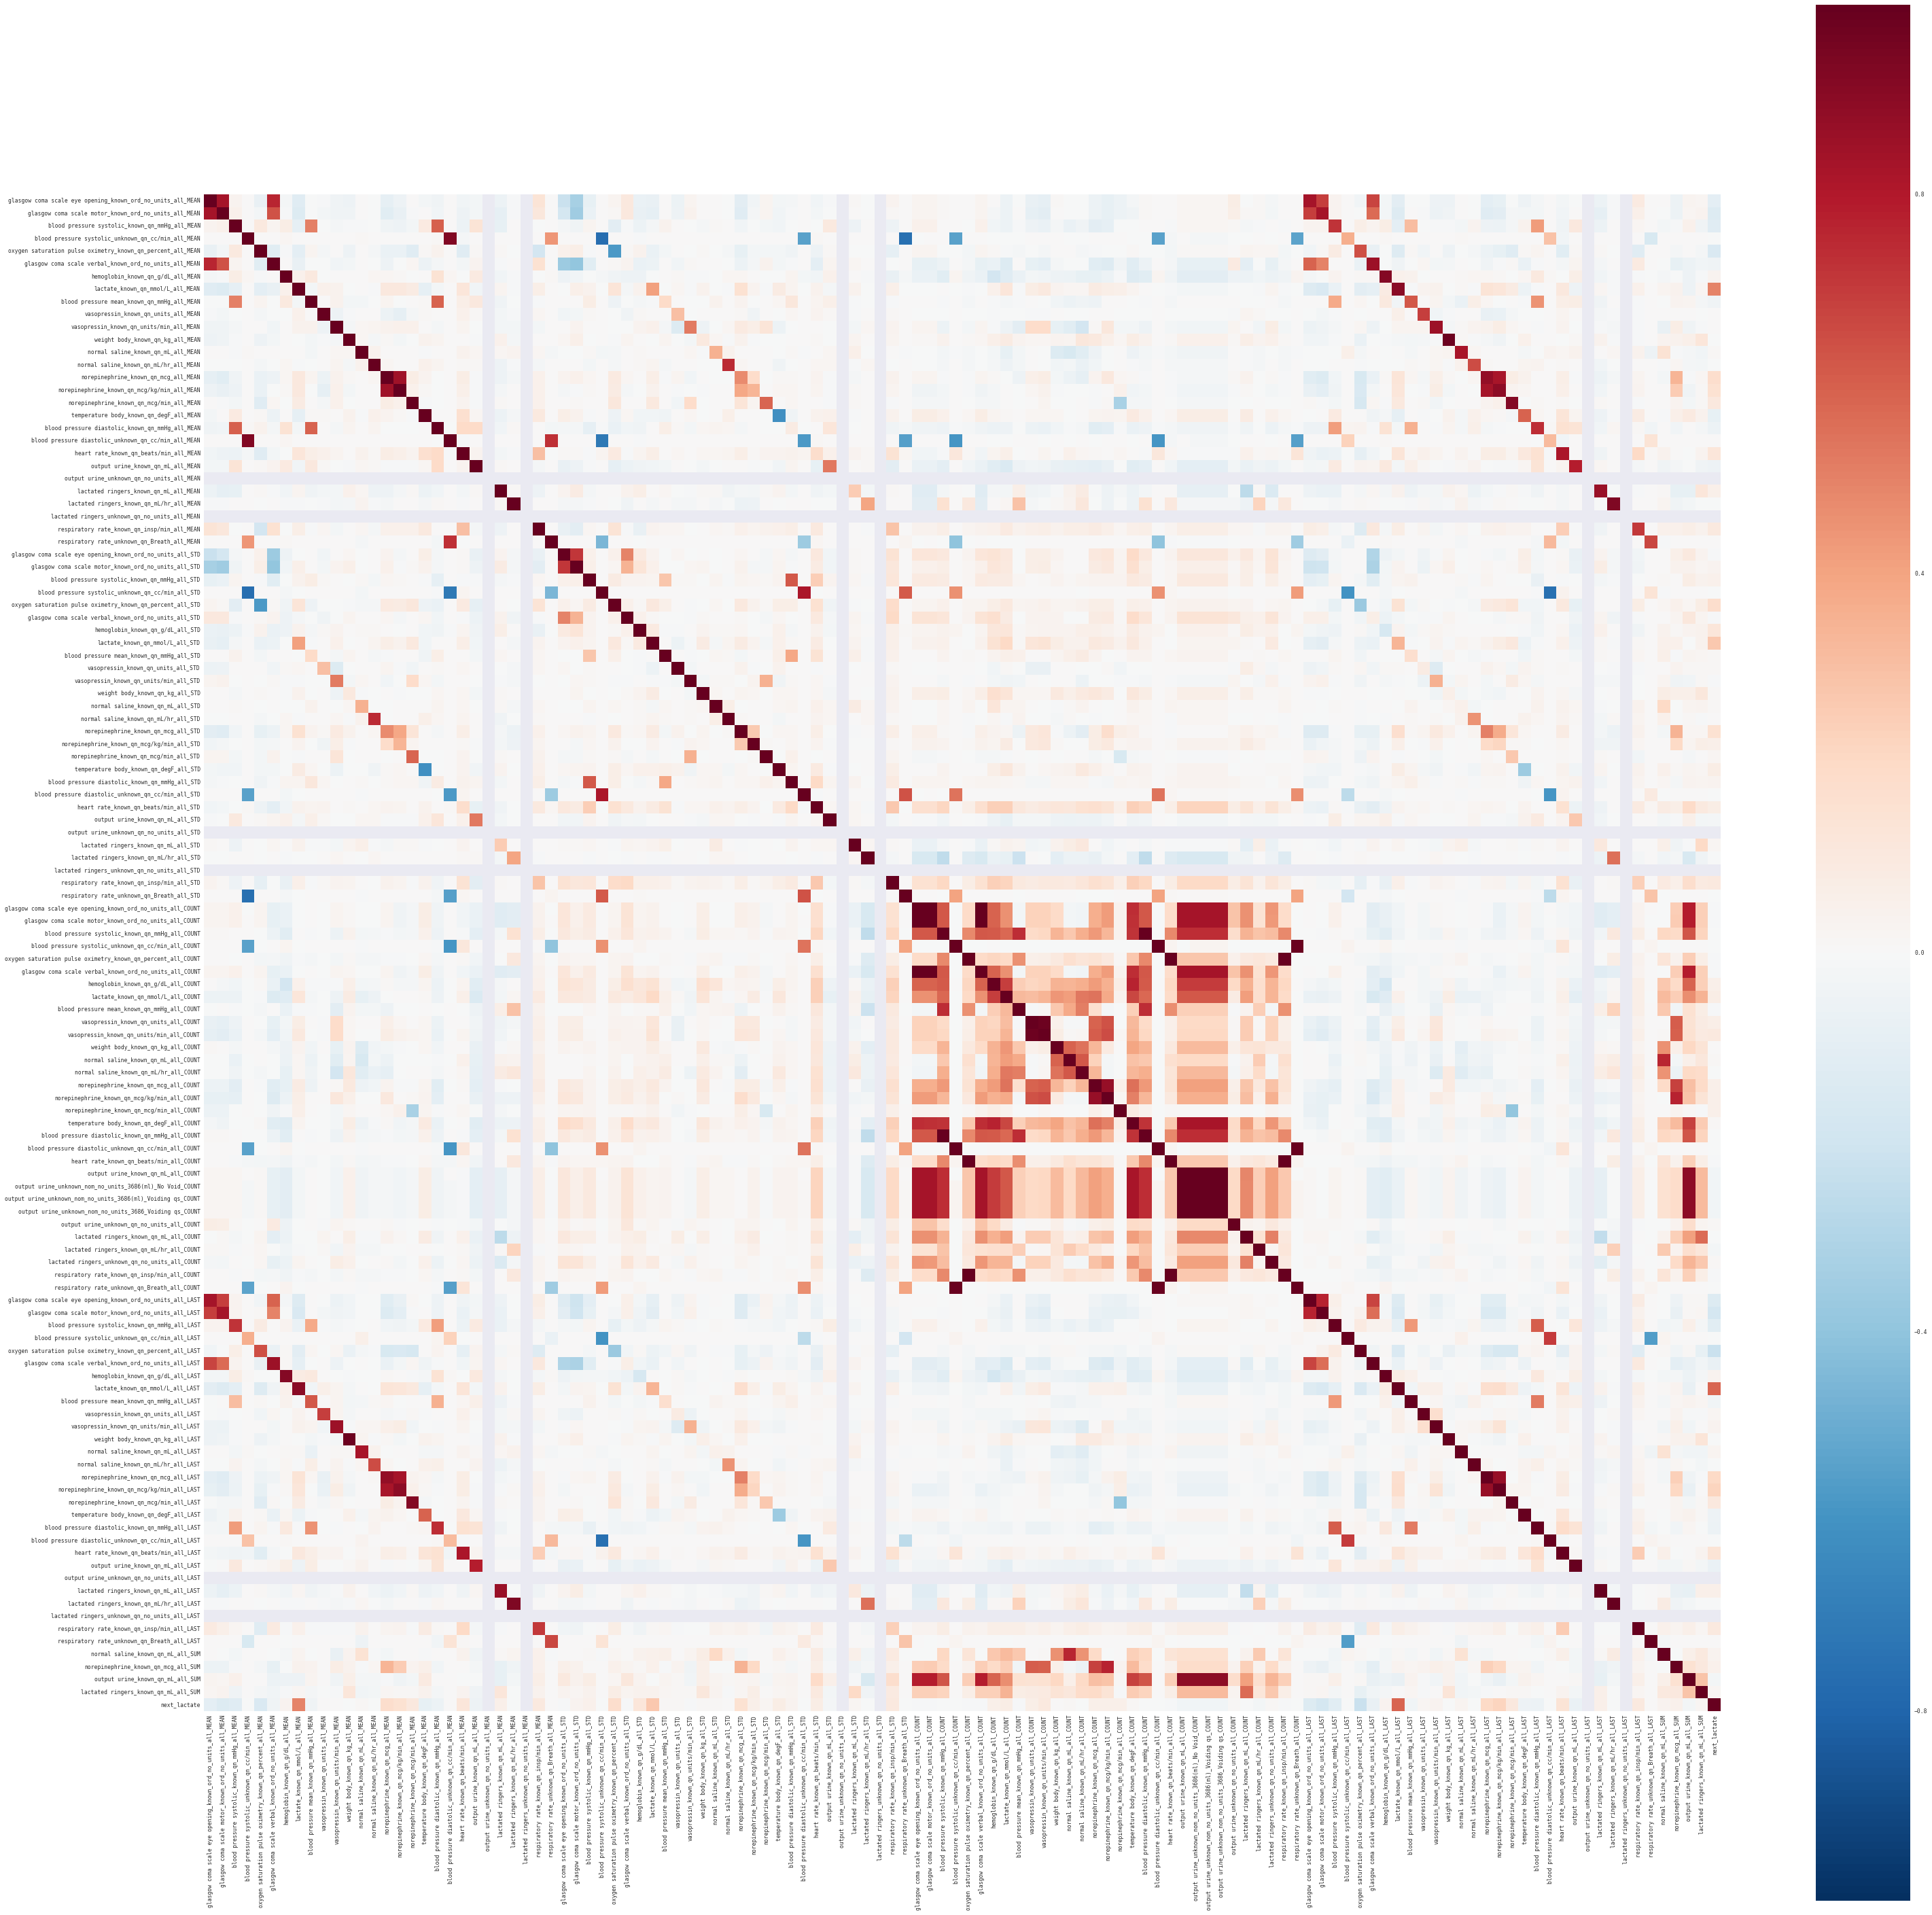

In [103]:
combined = train_ft.copy()
combined['next_lactate'] = train_lbl.reset_index(drop=True)
heatmap(combined)

In [3]:
#helper methods

reload(logger)



def create_df(hdf5_fname,components,ids=constants.ALL):
    #Load up our data dict and simple data components
    
    df_all = None
    logger.log('Make DF ...'.format(len(hadm_ids)),new_level=True)
    
    id_filter = transformers.filter_ids(ids=ids)
    
    for component in components:
        logger.log(component.upper(),new_level=True)

        logger.log('Opening...')
        df = utils.open_df(hdf5_fname,'cleaned/{}'.format(component))
        if ids != constants.ALL: 
            df_filtered = id_filter.transform(df)
        else: df_filtered = df
        logger.log('Join {} to {}'.format(df_filtered.shape, None if df_all is None else df_all.shape))
        if df_all is None: 
            df_all = df_filtered
        else: 
            df_all = df_all.join(df_filtered,how='outer')
            del df,df_filtered
        
        logger.end_log_level()
    logger.end_log()
    
    df_all.sort_index(axis=1,inplace=True)
    df_all.sort_index(inplace=True)
    
    
    return df_all



def clean_and_combine_simple_data(hadm_ids,data_dict):
    #Load up our data dict and simple data components
    hdf5_fname = 'data/mimic_simple_all'
    components = data_dict.get_panel_defintions(12).component.unique().tolist() #12 is "simple data"
    
    filter_ids =transformers.filter_ids(hadm_ids)
    #This will be our cleaning pipeline
    custom_cleaners = Pipeline([
            ('filter_ids',filter_ids),
            ('one_hotter',transformers.nominal_to_onehot()),
            ('drop_small_columns5',transformers.remove_small_columns(threshold=5)),
            ('drop_oob_values',transformers.oob_value_remover(data_dict)),
            ('drop_small_columns50',transformers.remove_small_columns(threshold=50)),
            ('combine_like_columns',transformers.combine_like_cols())
        ])
    
    df_all = None
    logger.log('Make DF for {} admission'.format(len(hadm_ids)),new_level=True)
    for component in components:
        logger.log(component.upper(),new_level=True)

        logger.log('Opening...')
        df = utils.open_df(hdf5_fname,'cleaned/{}'.format(component))

        display(df.describe())

        logger.log('Clean {}'.format(df.shape))
        df_cleaned = custom_cleaners.fit_transform(df)

        display(df_cleaned.describe())

        print utils.data_loss(filter_ids.transform(df),df_cleaned)
        
        logger.log('Join {} to {}'.format(df_cleaned.shape, None if df_all is None else df_all.shape))
        if df_all is None: df_all = df_cleaned
        else : df_all = df_all.join(df_cleaned,how='outer')
        del df,df_cleaned
        
        logger.end_log_level()
    logger.end_log()

    return df_all


def features_and_labels(df,data_dict,random_state,n_hrs,feature_tuples):
    
    labels = create_lactate_labels(df,data_dict,random_state)
    valid_ids = labels.index.get_level_values(constants.column_names.ID).unique().tolist()
    
    end_dt = labels.reset_index(constants.column_names.DATETIME,drop=False).iloc[:,0]
    df_context = mimic.get_context_data(valid_ids)
    
    
    pipeline = Pipeline([
        ('filter',transformers.filter_ids(valid_ids)),
        ('segmenter',segmenting.n_hrs_before(end_dt,df_context,n_hrs)),
        ('featurizer',features.featurizer(feature_tuples)),
        ('feature_cleaner',features.pdFeatureUnion())
    ])
    
    return pipeline.transform(df),labels
    


In [4]:
def clean_and_combine_data(hdf5_fname,components,cleaners,train_ids,test_ids):
    filter_ids = transformers.filter_ids(hadm_ids)
    
    df_all = None
    logger.log('Make DF for {} admission - {}'.format(len(hadm_ids),components),new_level=True)
    for component in components:
        logger.log(component.upper(),new_level=True)

        logger.log('Opening...')
        df = utils.open_df(hdf5_fname,'cleaned/{}'.format(component))
        df_test = transformers.filter_ids(test_ids).transform(test_ids).sort_index(axis=1).sort_index()
        df_train = transformers.filter_ids(train_ids).transform(test_ids).sort_index(axis=1).sort_index()
        
        display(df.describe())

        logger.log('Clean {}'.format(df.shape))
        df_cleaned = cleaners.fit_transform(df_test)

        display(df_cleaned.describe())

        print utils.data_loss(df,df_cleaned)
        
        logger.log('Join {} to {}'.format(df_cleaned.shape, None if df_all is None else df_all.shape))
        if df_all is None: df_all = df_cleaned
        else : df_all = df_all.join(df_cleaned,how='outer')
        del df,df_cleaned
        
        logger.end_log_level()
    logger.end_log()

    return df_all


def lin_reg_feature_pipeline(labels,feature_tuples):
    valid_ids = labels.index.get_level_values(constants.column_names.ID).unique().tolist()
    df_context = mimic.get_context_data(valid_ids)
    end_dt = labels.reset_index(constants.column_names.DATETIME,drop=False).iloc[:,0]
   
    return Pipeline([
            ('filter_ids',transformers.filter_ids(ids=valid_ids)),
            ('segmenter',segmenting.n_hrs_before(end_dt,df_context,n_hrs=None)), #we are doing multivariate regression, so need to segment in this way for now
            ('featurizer',features.pdFeatureUnion(feature_tuples)),
            ('feature_cleaner',features.feature_cleaner())
        ])

def lin_reg_features_and_labels(hadm_ids,hdf5_fname,feature_components,label_components,cleaners,
                                    feature_tuples,n_hrs=constants.ALL):
    #get all data, both for features and labels
    components = list(set(feature_components + label_components))
    df_all = clean_and_combine_data(hdf5_fname,components,cleaners,hadm_ids)

    #extract labels
    labels = label_extractor.transform(df_all)

    #feature pipeline
    feature_pipeline = lin_reg_feature_pipeline(labels,feature_tuples)
    feature_pipeline.set_params(segmenter__n_hrs=n_hrs)
    df_features = feature_pipeline.transform(df_all)
    return df_features,labels

In [6]:
import pandas as pd

In [7]:
left = pd.DataFrame([(1,2,3,4),(5,6,7,8),(9,10,11,12)],columns=['A','B','C','D'])
r1 = pd.DataFrame([(3,4),(5,6)],columns=['E','F'],index=[0,1])
r2 = pd.DataFrame([(34,234),(5,6)],columns=['E','F'],index=[2,3])

partitions = [r1,r2]
left

A   B   C   D
0  1   2   3   4
1  5   6   7   8
2  9  10  11  12

In [10]:
left.iloc[:,0].dropna().index.get_level_values(0).unique().size

3

In [21]:
for df_partition in partitions:
    display(left)
    display(df_partition)
    in_index = df_partition.index.isin(left.index)
    in_column = df_partition.columns.isin(left.columns)

    left = left.join(df_partition.loc[in_index,~in_column], how='outer')
    left = pd.concat([left,df_partition.loc[~in_index,:]])
    left.update(df_partition.loc[in_index,in_column])
    display(left)
left

A   B   C   D
0  1   2   3   4
1  5   6   7   8
2  9  10  11  12

E  F
0  3  4
1  5  6

A     B     C     D    E    F
0  1.0   2.0   3.0   4.0  3.0  4.0
1  5.0   6.0   7.0   8.0  5.0  6.0
2  9.0  10.0  11.0  12.0  NaN  NaN

A     B     C     D    E    F
0  1.0   2.0   3.0   4.0  3.0  4.0
1  5.0   6.0   7.0   8.0  5.0  6.0
2  9.0  10.0  11.0  12.0  NaN  NaN

E    F
2  34  234
3   5    6

A     B     C     D     E      F
0  1.0   2.0   3.0   4.0   3.0    4.0
1  5.0   6.0   7.0   8.0   5.0    6.0
2  9.0  10.0  11.0  12.0  34.0  234.0
3  NaN   NaN   NaN   NaN   5.0    6.0

A     B     C     D     E      F
0  1.0   2.0   3.0   4.0   3.0    4.0
1  5.0   6.0   7.0   8.0   5.0    6.0
2  9.0  10.0  11.0  12.0  34.0  234.0
3  NaN   NaN   NaN   NaN   5.0    6.0

A   B   C   D    E    F
0  1   2   3   4  3.0  4.0
1  5   6   7   8  5.0  6.0
2  9  10  11  12  NaN  NaN

In [91]:
df_joined

A    B    C    D     E      F
0  1.0  2.0  3.0  4.0   NaN    NaN
1  5.0  6.0  7.0  8.0   3.0    4.0
2  NaN  5.0  NaN  6.0  34.0  234.0

In [ ]:
df2.loc[in_index,~in_column]

In [39]:
pd.concat([df1,df2])

A    B    C    D    E    F
0  1.0  2.0  3.0  4.0  NaN  NaN
1  5.0  6.0  7.0  8.0  NaN  NaN
1  NaN  NaN  NaN  NaN  3.0  4.0
2  NaN  5.0  NaN  6.0  7.0  8.0

In [43]:
df1.update(df2,join='left')

In [44]:
df1

A  B  C  D
0  1  2  3  4
1  5  6  7  8

In [ ]:
class lactate_label_extractor(BaseEstimator,TransformerMixin,has_data_needs):

    def __init__(self,lactate_component,random_state):
        self.lactate_component = lactate_component
        self.random_state = random_state
        super(lactate_label_extractor,self).__init__((lactate_component,ALL))
        
    def fit(self, df, y=None):
        return self

    def transform(self, df):
        logger.log('Extract lactate label',new_level=True)
        lactate = df.groupby(level=constants.column_names.ID).apply(self.sample_lactate).dropna().reset_index(level=0,drop=True)
        logger.end_log_level()
        return labels

    def sample_lactate(grp):
        eligible_lactate = grp.iloc[1:].loc[:,self.lactate_component]
        if eligible_lactate.size == 0: return pd.np.nan
        
        return eligible_lactate.sample(n=1,random_state=self.random_state)